# LoL Esports Predictions
## Freiwald Scholars Project, Summer 2023
### By Avery Wang
This is a Jupyter Notebook which will read in data from many different CSV files, containing match data from various time periods in the LCS, LEC, LCK, and LPL, and update the player ELOs in each one. There will then be a cell that predicts the playoffs result for each split and evaluates the accuracy of the prediction.

In [1]:
# Import statements

import numpy as np
import pandas as pd
from datetime import datetime

pd.set_option("display.max_rows", None)
PATH = "C:/Users/aw/Documents/WashU/2022-2023/Spring Semester/Math 401/OE Match Data/" # Edit this variable accordingly

In [2]:
# Some important constants which will be used in later functions.

ideal_gold = {"top": 11445.894, "jng": 9890.908, "mid": 12046.563, "bot": 12855.070, "sup": 7122.977} # Averaged 2019 Spring-2023 Spring
norm_constants = {} # 1000 ELO = constant * gold
for k, v in ideal_gold.items():
    norm_constants[k] = 1000/v

In [3]:
# Some function definitions

def get_player_data(df, playername):
    # Given a DataFrame, finds all rows corresponding to that player. Takes into account the possibility of name changes.

    playerid = list(set(df[(df["playername"]==playername)]["playerid"]))
    assert len(playerid) == 1

    return df[(df["playerid"]==playerid[0])]

def get_players(df):
    # Given a DataFrame, returns a list of all unique player names.

    return list(set(df["playername"]))

def new_elo(row, k, mode=1):
    # Given a row corresponding to a player, calculates the new ELO of the player and the opponent based on the gold statistics.
    # Mode 1: default, modified
    # Mode 2: traditional, result is 1, 0.5, or 0 depending on gold difference
    # K-factors were calculated using IdealK.py, minimizing the Mean Squared Error. 
    # The LCS and LPL have K-factors slightly lower and the LEC and LCK have slightly higher, the K-factors chosen are around the median.

    assert mode in [1, 2]
    elo = row["ELO"]
    opp_elo = row["opp_ELO"]
    constant = norm_constants[row["position"]]
    variance = 400

    match mode:
        case 1:
            actual = constant*row["golddiff"] # actual performance
            expected = (elo-opp_elo) # expected performance
            elo += k*f(actual-expected, variance)
            opp_elo += k*f(expected-actual, variance)
            return (elo, opp_elo)
        case 2:
            golddiff = row["golddiff"]
            n = 500
            if golddiff > n:
                actual = 1 # "win"
                multiplier = (golddiff/n + 3)**0.8/(7.5 + 0.006*(elo-opp_elo))
            if abs(golddiff) <= n:
                actual = 0.5 # "draw"
                multiplier = 1
            if golddiff < -n:
                actual = 0 # "lose"
                multiplier = (-golddiff/n + 3)**0.8/(7.5 + 0.006*(opp_elo-elo))
            expected = g(elo-opp_elo, variance)
            elo += k*multiplier*(actual-expected)
            opp_elo += k*multiplier*(expected-actual)
            return (elo, opp_elo)

def f(x, variance):
    # Sigmoid function, used in updating ELO.

    return 1/(1+10**(-x/variance))-0.5

def g(x, variance):
    # Alternate sigmoid function

    return 1/(1+10**(-x/variance))

In [4]:
# Defining the Prediction and ELO classes
# The ELO class contains all of the functions used to generate predictions, hence the length.

class Prediction:
    # Stores the result of a prediction using ELOs. Lists the winner first, so the percentage must always be at least 50%.
    def __init__(self, team, elo, opp, opp_elo, bestof, percentage):
        assert bestof in [1, 3, 5]
        assert 0.5 <= percentage <= 1
        self.team = team
        self.elo = elo
        self.opp = opp
        self.opp_elo = opp_elo
        self.bestof = bestof
        self.percentage = percentage
    
    def __repr__(self):
        return "Winner: %s\nWinner ELO: %s\nLoser: %s\nLoser ELO: %s\nBest-of-%s\nProbability: %s" % (self.team, self.elo, self.opp, self.opp_elo, self.bestof, self.percentage)

class ELO:
    # Packages a dictionary of player ELOs with the DataFrame it came from
    def __init__(self, elos, df):
        self.elos = elos
        self.df = df
    
    def __repr__(self):
        return "ELOs:%s\nDF: %s" % (self.elos, self.df)
    
    def get_player_elo(self, playername):
        # Given a player name, returns their ELO.
        return self.elos[playername]
    
    def get_player_elo_prog(self, playername):
        # Given a player name, returns an array showing a player's ELO progression over time.
        return self.df[(self.df["playername"]==playername)].filter(items=["date", "teamname", "ELO"])

    def get_team_elo(self, team):
        # Given a list of players, returns the sum of their ELOs.
        return np.mean(list(map(self.get_player_elo, team)))

    def split(self, n=1000):
        # Returns a tuple with the first integer being the number of players with rating equal to or below n and the second being the number of players with rating above n.

        above = {}
        below = {}

        for k, v in self.elos.items():
            if v <= n:
                below[k] = v
            else: 
                above[k] = v
        return (len(below), len(above))

    def between(self, m, n):
        # Returns the number of players with rating in interval [m, n).

        return self.split(n)[0]-self.split(m)[0]
    
    def predict_winner(self, team1, team2, bestof=5):
        # Given two teams, returns a Prediction containing which team will win and percentage certainty, using the traditional ELO calculations.
        # If a perfect 50-50 tie is predicted, returns a Prediction with the teams in the same order as they were inputted and 50%.
        # Default is Best-of-5 because that is the most common.

        assert bestof in [1, 3, 5]
        elo1 = self.get_team_elo(team1)
        elo2 = self.get_team_elo(team2)
        variance = 400

        if elo1 > elo2:
            winner = team1
            winner_elo = elo1
            loser = team2
            loser_elo = elo2
            prob = g(elo1-elo2, variance)
        if elo1 < elo2:
            winner = team2
            winner_elo = elo2
            loser = team1
            loser_elo = elo1
            prob = g(elo2-elo1, variance)
        if elo1 == elo2:
            return Prediction(team1, elo1, team2, elo2, bestof, 0.5)
        
        match bestof:
            case 1:
                return Prediction(winner, winner_elo, loser, loser_elo, bestof, prob)
            case 3:
                prob = prob**2 + prob**2*(1-prob)*2
                return Prediction(winner, winner_elo, loser, loser_elo, bestof, prob)
            case 5:
                prob = prob**3 + prob**3*(1-prob)*3 + prob**3*(1-prob)**2*6
                return Prediction(winner, winner_elo, loser, loser_elo, bestof, prob)
    
    # --- PREDICTION FUNCTIONS ---
    # Each function assumes the teams are listed in order of seeding. This may need to be changed depending on situations where a team can choose its opponent.

    def LCS_Playoffs_Old(self, team1, team2, team3, team4, team5, team6, third_place=False):
        # Given the 6 teams (lists of 5 players) that make the LCS playoffs, prints the Prediction for each round. Returns a list of the winners of each match in order.
        # Includes an option for a Third-place match; this is only played in Summer.
        # This is the Single Elimination version used in 2019.

        # Quarterfinal 1
        predict1 = self.predict_winner(team4, team5)
        print("Quarterfinal 1")
        print(predict1)
        print("\n")
        winner1 = predict1.team

        # Quarterfinal 2
        predict2 = self.predict_winner(team3, team6)
        print("Quarterfinal 2")
        print(predict2)
        print("\n")
        winner2 = predict2.team

        # Semifinal 1
        predict3 = self.predict_winner(team1, winner1)
        print("Semifinal 1")
        print(predict3)
        print("\n")
        winner3 = predict3.team
        loser3 = predict3.opp

        # Semifinal 2
        predict4 = self.predict_winner(team2, winner2)
        print("Semifinal 2")
        print(predict4)
        print("\n")
        winner4 = predict4.team
        loser4 = predict4.opp

        if third_place:
            # Third-place match
            predict5 = self.predict_winner(loser3, loser4)
            print("Third-place match")
            print(predict5)
            print("\n")
            winner5 = predict5.team

        # Final
        predict6 = self.predict_winner(winner3, winner4)
        print("Final")
        print(predict6)
        print("\n")
        winner6 = predict6.team

        # Print the predicted champion, runner-up, and third place team
        print("Champion:")
        print(winner6)
        print("Runner-up:")
        print(predict6.opp)
        if third_place:
            print("Third place:")
            print(winner5)
        print("\n\n\n")

        if third_place:
            return np.array([winner1, winner2, winner3, winner4, winner5, winner6])
        else:
            return np.array([winner1, winner2, winner3, winner4, winner6])

    def LCSSpring_Playoffs_New(self, team1, team2, team3, team4, team5, team6):
        # Given the 6 teams (lists of 5 players) that make the LCS Spring playoffs, prints the Prediction for each round. Returns a list of the winners of each match in order.
        # This is the Double Elimination version used from 2020-present.

        # Winner's Semifinal 1
        predict1 = self.predict_winner(team1, team4)
        print("Winner's Semifinal 1")
        print(predict1)
        print("\n")
        winner1 = predict1.team
        loser1 = predict1.opp

        # Winner's Semifinal 2
        predict2 = self.predict_winner(team2, team3)
        print("Winner's Semifinal 2")
        print(predict2)
        print("\n")
        winner2 = predict2.team
        loser2 = predict2.opp

        # Loser's Semifinal 1
        predict3 = self.predict_winner(team6, loser2)
        print("Loser's Semifinal 1")
        print(predict3)
        print("\n")
        winner3 = predict3.team

        # Loser's Semifinal 2
        predict4 = self.predict_winner(team5, loser1)
        print("Loser's Semifinal 2")
        print(predict4)
        print("\n")
        winner4 = predict4.team

        # Winner's Final
        predict5 = self.predict_winner(winner1, winner2)
        print("Winner's Final")
        print(predict5)
        print("\n")
        winner5 = predict5.team
        loser5 = predict5.opp

        # Loser's Final
        predict6 = self.predict_winner(winner3, winner4)
        print("Loser's Final")
        print(predict6)
        print("\n")
        winner6 = predict6.team

        # Semifinal
        predict7 = self.predict_winner(loser5, winner6)
        print("Semifinal")
        print(predict7)
        print("\n")
        winner7 = predict7.team

        # Final
        predict8 = self.predict_winner(winner5, winner7)
        print("Final")
        print(predict8)
        print("\n")
        winner8 = predict8.team

        # Print the predicted champion, runner-up, and third place team
        print("Champion:")
        print(winner8)
        print("Runner-up:")
        print(predict8.opp)
        print("Third place:")
        print(predict7.opp)
        print("\n\n\n")

        return np.array([winner1, winner2, winner3, winner4, winner5, winner6, winner7, winner8])

    def LCSSummer_Playoffs_New(self, team1, team2, team3, team4, team5, team6, team7, team8):
        # Given the 8 teams (lists of 5 players) that make the LCS Summer playoffs, prints the Prediction for each round. Returns a list of the winners of each match in order.
        # This is the Double Elimination version used from 2020-present.

        # Winner's Quarterfinal 1
        predict1 = self.predict_winner(team3, team6)
        print("Winner's Quarterfinal 1")
        print(predict1)
        print("\n")
        winner1 = predict1.team
        loser1 = predict1.opp

        # Winner's Quarterfinal 2
        predict2 = self.predict_winner(team4, team5)
        print("Winner's Quarterfinal 2")
        print(predict2)
        print("\n")
        winner2 = predict2.team
        loser2 = predict2.opp

        # Loser's Quarterfinal 1
        predict3 = self.predict_winner(team8, loser2)
        print("Loser's Quarterfinal 1")
        print(predict3)
        print("\n")
        winner3 = predict3.team

        # Loser's Quarterfinal 2
        predict4 = self.predict_winner(team7, loser1)
        print("Loser's Quarterfinal 2")
        print(predict4)
        print("\n")
        winner4 = predict4.team

        # Winner's Semifinal 1
        predict5 = self.predict_winner(team1, winner2)
        print("Winner's Semifinal 1")
        print(predict5)
        print("\n")
        winner5 = predict5.team
        loser5 = predict5.opp

        # Winner's Semifinal 2
        predict6 = self.predict_winner(team2, winner1)
        print("Winner's Semifinal 2")
        print(predict6)
        print("\n")
        winner6 = predict6.team
        loser6 = predict6.opp

        # Loser's Semifinal 1
        predict7 = self.predict_winner(winner3, loser5)
        print("Loser's Semifinal 1")
        print(predict7)
        print("\n")
        winner7 = predict7.team

        # Loser's Semifinal 2
        predict8 = self.predict_winner(winner4, loser6)
        print("Loser's Semifinal 2")
        print(predict8)
        print("\n")
        winner8 = predict8.team

        # Winner's Final
        predict9 = self.predict_winner(winner5, winner6)
        print("Winner's Final")
        print(predict9)
        print("\n")
        winner9 = predict9.team
        loser9 = predict9.opp

        # Loser's Final
        predict10 = self.predict_winner(winner7, winner8)
        print("Loser's Final")
        print(predict10)
        print("\n")
        winner10 = predict10.team

        # Semifinal
        predict11 = self.predict_winner(loser9, winner10)
        print("Semifinal")
        print(predict11)
        print("\n")
        winner11 = predict11.team

        # Final
        predict12 = self.predict_winner(winner9, winner11)
        print("Final")
        print(predict12)
        print("\n")
        winner12 = predict12.team

        # Print the predicted champion, runner-up, and third place team
        print("Champion:")
        print(winner12)
        print("Runner-up:")
        print(predict12.opp)
        print("Third place:")
        print(predict11.opp)
        print("\n\n\n")

        return np.array([winner1, winner2, winner3, winner4, winner5, winner6, winner7, winner8, winner9, winner10, winner11, winner12])
    
    def LEC_Playoffs_Old(self, team1, team2, team3, team4, team5, team6):
        # Given the 6 teams (lists of 5 players) that make the LEC playoffs, prints the Prediction for each round. Returns a list of the winners of each match in order.
        # This is the format used in 2019.

        # Loser's Semifinal 1
        predict1 = self.predict_winner(team3, team6)
        print("Loser's Semifinal 1")
        print(predict1)
        print("\n")
        winner1 = predict1.team

        # Loser's Semifinal 2
        predict2 = self.predict_winner(team4, team5)
        print("Loser's Semifinal 2")
        print(predict2)
        print("\n")
        winner2 = predict2.team

        # Winner's Final
        predict3 = self.predict_winner(team1, team2)
        print("Winner's Final")
        print(predict3)
        print("\n")
        winner3 = predict3.team
        loser3 = predict3.opp

        # Loser's Final
        predict4 = self.predict_winner(winner1, winner2)
        print("Loser's Final")
        print(predict4)
        print("\n")
        winner4 = predict4.team

        # Semifinal
        predict5 = self.predict_winner(loser3, winner4)
        print("Semifinal")
        print(predict5)
        print("\n")
        winner5 = predict5.team

        # Final
        predict6 = self.predict_winner(winner3, winner5)
        print("Final")
        print(predict6)
        print("\n")
        winner6 = predict6.team

        # Print the predicted champion, runner-up, and third place team
        print("Champion:")
        print(winner6)
        print("Runner-up:")
        print(predict6.opp)
        print("Third place:")
        print(predict5.opp)
        print("\n\n\n")

        return np.array([winner1, winner2, winner3, winner4, winner5, winner6])
    
    def LEC_Playoffs_Gauntlet(self, team1, team2, team3, team4, team5, team6, choice=True):
        # Given the 6 teams (lists of 5 players) that make the LEC playoffs, prints the Prediction for each round. Returns a list of the winners of each match in order.
        # The choice variable is True if team1 chooses to play team4 in the first round and False if team1 chooses to play team3 in the first round.
        # This is the format used in 2020-2022.
        
        seeds = {tuple(team1):1, tuple(team2):2, tuple(team3):3, tuple(team4):4}
        if choice:
            opp1 = team4
            opp2 = team3
        else:
            opp1 = team3
            opp2 = team4

        # Winner's Semifinal 1
        predict1 = self.predict_winner(team1, opp1)
        print("Winner's Semifinal 1")
        print(predict1)
        print("\n")
        winner1 = predict1.team
        loser1 = predict1.opp

        # Winner's Semifinal 2
        predict2 = self.predict_winner(team2, opp2)
        print("Winner's Semifinal 2")
        print(predict2)
        print("\n")
        winner2 = predict2.team
        loser2 = predict2.opp

        # Loser's Round 1
        predict3 = self.predict_winner(team5, team6)
        print("Loser's Round 1")
        print(predict3)
        print("\n")
        winner3 = predict3.team

        if seeds[tuple(loser1)] > seeds[tuple(loser2)]:
            opp3 = loser1
            opp4 = loser2
        else:
            opp3 = loser2
            opp4 = loser1
        
        # Loser's Round 2
        predict4 = self.predict_winner(winner3, opp3)
        print("Loser's Round 2")
        print(predict4)
        print("\n")
        winner4 = predict4.team

        # Loser's Round 3
        predict5 = self.predict_winner(winner4, opp4)
        print("Loser's Round 3")
        print(predict5)
        print("\n")
        winner5 = predict5.team

        # Winner's Final
        predict6 = self.predict_winner(winner1, winner2)
        print("Winner's Final")
        print(predict6)
        print("\n")
        winner6 = predict6.team
        loser6 = predict6.opp

        # Semifinal
        predict7 = self.predict_winner(winner5, loser6)
        print("Semifinal")
        print(predict7)
        print("\n")
        winner7 = predict7.team

        # Final
        predict8 = self.predict_winner(winner6, winner7)
        print("Final")
        print(predict8)
        print("\n")
        winner8 = predict8.team

        # Print the predicted champion, runner-up, and third place team
        print("Champion:")
        print(winner8)
        print("Runner-up:")
        print(predict8.opp)
        print("Third place:")
        print(predict7.opp)
        print("\n\n\n")

        return np.array([winner1, winner2, winner3, winner4, winner5, winner6, winner7, winner8])
    
    def LEC_Playoffs_New(self, team1, team2, team3, team4):
        # Given the 4 teams (lists of 5 players) that make the LEC playoffs, prints the Prediction for each round. Returns a list of the winners of each match in order.
        # This is the format used in 2023.
        # Note that the 2023 format has Regular Season (10 teams), Group Stage (8 teams), and Playoffs (4 teams), but only the Playoffs are marked as playoffs=1 in the CSV file.
        # This means that the 4 teams that make the playoffs are not necessarily the top 4 in Regular Season. However, Group Stage games will be used to update their ELO.

        # Winner's Final
        predict1 = self.predict_winner(team1, team2)
        print("Winner's Final")
        print(predict1)
        print("\n")
        winner1 = predict1.team
        loser1 = predict1.opp

        # Loser's Final
        predict2 = self.predict_winner(team3, team4)
        print("Loser's Final")
        print(predict2)
        print("\n")
        winner2 = predict2.team

        # Semifinal
        predict3 = self.predict_winner(loser1, winner2)
        print("Semifinal")
        print(predict3)
        print("\n")
        winner3 = predict3.team

        # Final
        predict4 = self.predict_winner(winner1, winner3)
        print("Final")
        print(predict4)
        print("\n")
        winner4 = predict4.team

        # Print the predicted champion, runner-up, and third place team
        print("Champion:")
        print(winner4)
        print("Runner-up:")
        print(predict4.opp)
        print("Third place:")
        print(predict3.opp)
        print("\n\n\n")

        return np.array([winner1, winner2, winner3, winner4])

    def LCK_Playoffs_Old(self, team1, team2, team3, team4, team5):
        # Given the 6 teams (lists of 5 players) that make the LCK playoffs, prints the Prediction for each round. Returns a list of the winners of each match in order.
        # This is the format used in 2019-2020.

        # Round 1
        predict1 = self.predict_winner(team4, team5, 3)
        print("Round 1")
        print(predict1)
        print("\n")
        winner1 = predict1.team

        # Round 2
        predict2 = self.predict_winner(team3, winner1)
        print("Round 2")
        print(predict2)
        print("\n")
        winner2 = predict2.team

        # Round 3
        predict3 = self.predict_winner(team2, winner2)
        print("Round 3")
        print(predict3)
        print("\n")
        winner3 = predict3.team

        # Final
        predict4 = self.predict_winner(team1, winner3)
        print("Final")
        print(predict4)
        print("\n")
        winner4 = predict4.team

        # Print the predicted champion, runner-up, and third place team
        print("Champion:")
        print(winner4)
        print("Runner-up:")
        print(predict4.opp)
        print("Third place:")
        print(predict3.opp)
        print("\n\n\n")

        return np.array([winner1, winner2, winner3, winner4])

    def LCK_Playoffs_New(self, team1, team2, team3, team4, team5, team6):
        # Given the 6 teams (lists of 5 players) that make the LCK playoffs, prints the Prediction for each round. Returns a list of the winners of each match in order.
        # This is the format used in 2021-2022. It is identical to the LCS playoff format in 2019.

        return self.LCS_Playoffs_Old(team1, team2, team3, team4, team5, team6)

    def LCK_Playoffs_Newer(self, team1, team2, team3, team4, team5, team6):
        # Given the 6 teams (lists of 5 players) that make the LCK playoffs, prints the Prediction for each round. Returns a list of the winners of each match in order.
        # This is the format used in 2023.

        # Quarterfinal 1
        predict1 = self.predict_winner(team4, team5)
        print("Quarterfinal 1")
        print(predict1)
        print("\n")
        winner1 = predict1.team

        # Quarterfinal 2
        predict2 = self.predict_winner(team3, team6)
        print("Quarterfinal 2")
        print(predict2)
        print("\n")
        winner2 = predict2.team

        # Winner's Semifinal 1
        predict3 = self.predict_winner(team1, winner1)
        print("Winner's Semifinal 1")
        print(predict3)
        print("\n")
        winner3 = predict3.team
        loser3 = predict3.opp

        # Winner's Semifinal 2
        predict4 = self.predict_winner(team2, winner2)
        print("Winner's Semifinal 2")
        print(predict4)
        print("\n")
        winner4 = predict4.team
        loser4 = predict4.opp

        # Loser's Final
        predict5 = self.predict_winner(loser3, loser4)
        print("Loser's Final")
        print(predict5)
        print("\n")
        winner5 = predict5.team

        # Winner's Final
        predict6 = self.predict_winner(winner3, winner4)
        print("Winner's Final")
        print(predict6)
        print("\n")
        winner6 = predict6.team
        loser6 = predict6.opp

        # Semifinal
        predict7 = self.predict_winner(winner5, loser6)
        print("Semifinal")
        print(predict7)
        print("\n")
        winner7 = predict7.team

        # Final
        predict8 = self.predict_winner(winner6, winner7)
        print("Final")
        print(predict8)
        print("\n")
        winner8 = predict8.team

        # Print the predicted champion, runner-up, and third place team
        print("Champion:")
        print(winner8)
        print("Runner-up:")
        print(predict8.opp)
        print("Third place:")
        print(predict7.opp)
        print("\n\n\n")
        
        return np.array([winner1, winner2, winner3, winner4, winner5, winner6, winner7, winner8])

    def LPL_Playoffs(self, team1, team2, team3, team4, team5, team6, team7, team8, team9, team10):
        # Given the 10 teams (lists of 5 players) that make the LPL playoffs, prints the Prediction for each round. Returns a list of the winners of each match in order.
        # This is the format used in 2021-present.

        # Round 1 Match 1
        predict1 = self.predict_winner(team8, team9)
        print("Round 1 Match 1")
        print(predict1)
        print("\n")
        winner1 = predict1.team

        # Round 1 Match 2
        predict2 = self.predict_winner(team7, team10)
        print("Round 1 Match 2")
        print(predict2)
        print("\n")
        winner2 = predict2.team

        # Round 2 Match 1
        predict3 = self.predict_winner(team5, winner1)
        print("Round 2 Match 1")
        print(predict3)
        print("\n")
        winner3 = predict3.team

        # Round 2 Match 2
        predict4 = self.predict_winner(team6, winner2)
        print("Round 2 Match 2")
        print(predict4)
        print("\n")
        winner4 = predict4.team

        # Round 3 Match 1
        predict5 = self.predict_winner(team4, winner3)
        print("Round 3 Match 1")
        print(predict5)
        print("\n")
        winner5 = predict5.team

        # Round 3 Match 2
        predict6 = self.predict_winner(team3, winner4)
        print("Round 3 Match 2")
        print(predict6)
        print("\n")
        winner6 = predict6.team

        # Winner's Semifinal 1
        predict7 = self.predict_winner(team1, winner5)
        print("Winner's Semifinal 1")
        print(predict7)
        print("\n")
        winner7 = predict7.team
        loser7 = predict7.opp

        # Winner's Semifinal 2
        predict8 = self.predict_winner(team2, winner6)
        print("Winner's Semifinal 2")
        print(predict8)
        print("\n")
        winner8 = predict8.team
        loser8 = predict8.opp

        # Loser's Final
        predict9 = self.predict_winner(loser7, loser8)
        print("Loser's Final")
        print(predict9)
        print("\n")
        winner9 = predict9.team

        # Winner's Final
        predict10 = self.predict_winner(winner7, winner8)
        print("Winner's Final")
        print(predict10)
        print("\n")
        winner10 = predict10.team
        loser10 = predict10.opp

        # Semifinal
        predict11 = self.predict_winner(winner9, loser10)
        print("Semifinal")
        print(predict11)
        print("\n")
        winner11 = predict11.team

        # Final
        predict12 = self.predict_winner(winner10, winner11)
        print("Final")
        print(predict12)
        print("\n")
        winner12 = predict12.team
        # Print the predicted champion, runner-up, and third place team
        print("Champion:")
        print(winner12)
        print("Runner-up:")
        print(predict12.opp)
        print("Third place:")
        print(predict11.opp)
        print("\n\n\n")

        return np.array([winner1, winner2, winner3, winner4, winner5, winner6, winner7, winner8, winner9, winner10, winner11, winner12])

In [5]:
# Functions used to score the predictions, one point is awarded each time the correct winner of a match is predicted
# The loser of the match does not matter for calculations
# The expected value is included in the definition of each function (NOT DONE YET)
# The names of the functions correspond to the names of the methods in the ELO class.

def PredictionScore(list1, list2):
    x = len(list1)
    assert len(list2) == x
    compare = list1 == list2
    acc = np.zeros(x)
    for i in range(x):
        acc[i] = all(compare[i]) # We assume that the list will be all True or all False, this will return True if all True and False if at least one False.

    score = int(sum(acc))
    total = x
    print("Raw Score: ", score)
    print("Full Score: ", total)
    return (score, total)

def LCS_Playoffs_Old_Score(list1, list2, third_place=False):
    if third_place:
        x = 6
    else:
        x = 5
    assert len(list1) == len(list2) == x
    return PredictionScore(list1, list2)

def LCSSpring_Playoffs_New_Score(list1, list2):
    assert len(list1) == len(list2) == 8
    return PredictionScore(list1, list2)

def LCSSummer_Playoffs_New_Score(list1, list2):
    assert len(list1) == len(list2) == 12
    return PredictionScore(list1, list2)

def LEC_Playoffs_Old_Score(list1, list2):
    assert len(list1) == len(list2) == 6
    return PredictionScore(list1, list2)

def LEC_Playoffs_Gauntlet_Score(list1, list2):
    assert len(list1) == len(list2) == 8
    return PredictionScore(list1, list2)

def LEC_Playoffs_New_Score(list1, list2):
    assert len(list1) == len(list2) == 4
    return PredictionScore(list1, list2)

def LCK_Playoffs_Old_Score(list1, list2):
    assert len(list1) == len(list2) == 4
    return PredictionScore(list1, list2)

def LCK_Playoffs_New_Score(list1, list2):
    return LCS_Playoffs_Old_Score(list1, list2)

def LCK_Playoffs_Newer_Score(list1, list2):
    assert len(list1) == len(list2) == 8
    return PredictionScore(list1, list2)

def LPL_Playoffs_Score(list1, list2):
    assert len(list1) == len(list2) == 12
    return PredictionScore(list1, list2)

In [6]:
# The all-important update_elos function, which populates match data with player ELOs.

def update_elos(df, k, mode=1):
    # Given a DataFrame, loops through all of the rows and updates each player's ELO recursively. Assumes the DataFrame is in chronological order.
    # Mode 1: modified
    # Mode 2: traditional

    assert mode in [1, 2]
    df = df.copy()
    players = get_players(df)
    elos = {player:1000 for player in players} # locally stores ELO

    split = df.iloc[0]["split"]
    year = df.iloc[0]["year"]

    for index, row in df.iterrows():
        # Regress to the mean every year and split
        
        if row["year"] != year:
            j = 0.10

            year = row["year"]
            split = row["split"]
            for i, v in elos.items():
                elos[i] = 1000*j + v*(1-j)
   
        if row["split"] != split:
            j = 0.05

            split = row["split"]

            for i, v in elos.items():
                elos[i] = 1000*j + v*(1-j)
        
        # Update ELOs for each row but only calculate new ELO on red side, because of nearly duplicate columns
        if row["side"] == "Blue":
            df.at[index, "ELO"] = elos[row["playername"]] 
            df.at[index, "opp_ELO"] = elos[row["opp_playername"]]
        
        if row["side"] == "Red":
            df.at[index, "ELO"] = elos[row["playername"]] 
            df.at[index, "opp_ELO"] = elos[row["opp_playername"]]

            match mode:
                case 1:
                    new = new_elo(df.loc[index], k)
                    elos[row["playername"]] = new[0]
                    elos[row["opp_playername"]] = new[1]
                case 2:
                    new = new_elo(df.loc[index], k, mode=2)
                    elos[row["playername"]] = new[0]
                    elos[row["opp_playername"]] = new[1]
    
    sorted_elos = sorted(elos.items(), key=lambda x:x[1])
    return ELO(dict(sorted_elos), df)

## Reading in CSV Files
The following code will be used to read in the CSV files and update their ELOs. It only needs to be run once.

In [7]:
# K-factors
k1 = 15
k2 = 20

In [8]:
# LCS

start = datetime.now()

LCS_splits = []
for i in range(9):
    LCS_splits.append(pd.read_csv(PATH + "LCS" + str(i) + ".csv"))

LCS_ELOs = []
year = 2019
season = "Spring"
for i in LCS_splits:
    i = i[(i["playoffs"]!=1) | (i["year"]!=year) | (i["split"]!=season)]
    print("Updating LCS ELOs through " + str(year) + " " + season + " using modified algorithm...")
    LCS_ELOs.append(update_elos(i, k1, mode=1))
    print("Done!")
    print("Updating LCS ELOs through " + str(year) + " " + season + " using traditional algorithm...")
    LCS_ELOs.append(update_elos(i, k2, mode=2))
    print("Done!")
    if season == "Spring":
        season = "Summer"
        continue
    if season == "Summer":
        season = "Spring"
        year += 1

end = datetime.now()
print("Runtime: ", end-start)

Updating LCS ELOs through 2019 Spring using modified algorithm...
Done!
Updating LCS ELOs through 2019 Spring using traditional algorithm...
Done!
Updating LCS ELOs through 2019 Summer using modified algorithm...
Done!
Updating LCS ELOs through 2019 Summer using traditional algorithm...
Done!
Updating LCS ELOs through 2020 Spring using modified algorithm...
Done!
Updating LCS ELOs through 2020 Spring using traditional algorithm...
Done!
Updating LCS ELOs through 2020 Summer using modified algorithm...
Done!
Updating LCS ELOs through 2020 Summer using traditional algorithm...
Done!
Updating LCS ELOs through 2021 Spring using modified algorithm...
Done!
Updating LCS ELOs through 2021 Spring using traditional algorithm...
Done!
Updating LCS ELOs through 2021 Summer using modified algorithm...
Done!
Updating LCS ELOs through 2021 Summer using traditional algorithm...
Done!
Updating LCS ELOs through 2022 Spring using modified algorithm...
Done!
Updating LCS ELOs through 2022 Spring using tr

In [9]:
# LEC

start = datetime.now()

LEC_splits = []
for i in range(10):
    LEC_splits.append(pd.read_csv(PATH + "LEC" + str(i) + ".csv"))

LEC_ELOs = []
year = 2019
season = "Spring"
for i in LEC_splits:
    i = i[(i["playoffs"]!=1) | (i["year"]!=year) | (i["split"]!=season)]
    print("Updating LEC ELOs through " + str(year) + " " + season + " using modified algorithm...")
    LEC_ELOs.append(update_elos(i, k1, mode=1))
    print("Done!")
    print("Updating LEC ELOs through " + str(year) + " " + season + " using traditional algorithm...")
    LEC_ELOs.append(update_elos(i, k2, mode=2))
    print("Done!")
    if season == "Winter":
        season = "Spring"
        continue
    if season == "Spring":
        season = "Summer"
        continue
    if season == "Summer":
        if year == 2022:
            season = "Winter"
        else: 
            season = "Spring"
        year += 1

end = datetime.now()
print("Runtime: ", end-start)

Updating LEC ELOs through 2019 Spring using modified algorithm...
Done!
Updating LEC ELOs through 2019 Spring using traditional algorithm...
Done!
Updating LEC ELOs through 2019 Summer using modified algorithm...
Done!
Updating LEC ELOs through 2019 Summer using traditional algorithm...
Done!
Updating LEC ELOs through 2020 Spring using modified algorithm...
Done!
Updating LEC ELOs through 2020 Spring using traditional algorithm...
Done!
Updating LEC ELOs through 2020 Summer using modified algorithm...
Done!
Updating LEC ELOs through 2020 Summer using traditional algorithm...
Done!
Updating LEC ELOs through 2021 Spring using modified algorithm...
Done!
Updating LEC ELOs through 2021 Spring using traditional algorithm...
Done!
Updating LEC ELOs through 2021 Summer using modified algorithm...
Done!
Updating LEC ELOs through 2021 Summer using traditional algorithm...
Done!
Updating LEC ELOs through 2022 Spring using modified algorithm...
Done!
Updating LEC ELOs through 2022 Spring using tr

In [10]:
# LCK

start = datetime.now()

LCK_splits = []
for i in range(9):
    LCK_splits.append(pd.read_csv(PATH + "LCK" + str(i) + ".csv"))

LCK_ELOs = []
year = 2019
season = "Spring"
for i in LCK_splits:
    i = i[(i["playoffs"]!=1) | (i["year"]!=year) | (i["split"]!=season)]
    print("Updating LCK ELOs through " + str(year) + " " + season + " using modified algorithm...")
    LCK_ELOs.append(update_elos(i, k1, mode=1))
    print("Done!")
    print("Updating LCK ELOs through " + str(year) + " " + season + " using traditional algorithm...")
    LCK_ELOs.append(update_elos(i, k2, mode=2))
    print("Done!")
    if season == "Spring":
        season = "Summer"
        continue
    if season == "Summer":
        season = "Spring"
        year += 1

end = datetime.now()
print("Runtime: ", end-start)

Updating LCK ELOs through 2019 Spring using modified algorithm...
Done!
Updating LCK ELOs through 2019 Spring using traditional algorithm...
Done!
Updating LCK ELOs through 2019 Summer using modified algorithm...
Done!
Updating LCK ELOs through 2019 Summer using traditional algorithm...
Done!
Updating LCK ELOs through 2020 Spring using modified algorithm...
Done!
Updating LCK ELOs through 2020 Spring using traditional algorithm...
Done!
Updating LCK ELOs through 2020 Summer using modified algorithm...
Done!
Updating LCK ELOs through 2020 Summer using traditional algorithm...
Done!
Updating LCK ELOs through 2021 Spring using modified algorithm...
Done!
Updating LCK ELOs through 2021 Spring using traditional algorithm...
Done!
Updating LCK ELOs through 2021 Summer using modified algorithm...
Done!
Updating LCK ELOs through 2021 Summer using traditional algorithm...
Done!
Updating LCK ELOs through 2022 Spring using modified algorithm...
Done!
Updating LCK ELOs through 2022 Spring using tr

In [11]:
# LPL

start = datetime.now()
LPL_splits = []
for i in range(4):
    LPL_splits.append(pd.read_csv(PATH + "LPL" + str(i) + ".csv"))

LPL_ELOs = []
year = 2021
season = "Summer"
for i in LPL_splits:
    i = i[(i["playoffs"]!=1) | (i["year"]!=year) | (i["split"]!=season)]
    print("Updating LPL ELOs through " + str(year) + " " + season + " using modified algorithm...")
    LPL_ELOs.append(update_elos(i, k1, mode=1))
    print("Done!")
    print("Updating LPL ELOs through " + str(year) + " " + season + " using traditional algorithm...")
    LPL_ELOs.append(update_elos(i, k2, mode=2))
    print("Done!")
    if season == "Spring":
        season = "Summer"
        continue
    if season == "Summer":
        season = "Spring"
        year += 1

end = datetime.now()
print("Runtime: ", end-start)

Updating LPL ELOs through 2021 Summer using modified algorithm...
Done!
Updating LPL ELOs through 2021 Summer using traditional algorithm...
Done!
Updating LPL ELOs through 2022 Spring using modified algorithm...
Done!
Updating LPL ELOs through 2022 Spring using traditional algorithm...
Done!
Updating LPL ELOs through 2022 Summer using modified algorithm...
Done!
Updating LPL ELOs through 2022 Summer using traditional algorithm...
Done!
Updating LPL ELOs through 2023 Spring using modified algorithm...
Done!
Updating LPL ELOs through 2023 Spring using traditional algorithm...
Done!
Runtime:  0:00:12.515478


## Playoff Predictions
- All teams must have exactly 5 players, so they will not include subs. To account for this, the player that is listed on the playoff roster, if applicable, is listed.
- Otherwise, the player that played the majority of the games is listed, with recency used as a tiebreaker.
-  Where possible, if multiple players played during playoffs, different teams are listed with each rostr combination.
- Whenre teams choose their oppone, we rearrange seeds as much as possible so that the predicted bracket aligns closely with real events.e.

In [12]:
# LCS 2019 Spring

LCS2019_Spring_Teams = {
    "100": ["Ssumday", "AnDa", "huhi", "Bang", "aphromoo"],
    "C9": ["Licorice", "Svenskeren", "Nisqy", "Sneaky", "Zeyzal"],
    "CG": ["Huni", "Lira", "Damonte", "Cody Sun", "Vulcan"],
    "CLG": ["Darshan", "Griffin", "PowerOfEvil", "Stixxay", "Biofrost"],
    "FOX": ["Solo", "Rush", "Fenix", "Apollo", "Hakuho"],
    "FLY": ["V1per", "Santorin", "Pobelter", "WildTurtle", "JayJ"],
    "GG": ["Hauntzer", "Contractz", "Froggen", "Deftly", "Olleh"],
    "OPT": ["Dhokla", "Meteos", "Crown", "Arrow", "Big"],
    "TL": ["Impact", "Xmithie", "Jensen", "Doublelift", "CoreJJ"],
    "TSM": ["BrokenBlade", "Akaadian", "Bjergsen", "Zven", "Smoothie"]
}

for k, v in LCS2019_Spring_Teams.items():
    print(k)
    print(LCS_ELOs[0].get_team_elo(v))
    print(LCS_ELOs[1].get_team_elo(v))

LCS2019_Spring_Modified = LCS_ELOs[0].LCS_Playoffs_Old(LCS2019_Spring_Teams["TL"],
                                                       LCS2019_Spring_Teams["C9"],
                                                       LCS2019_Spring_Teams["TSM"],
                                                       LCS2019_Spring_Teams["FLY"],
                                                       LCS2019_Spring_Teams["GG"],
                                                       LCS2019_Spring_Teams["FOX"])
LCS2019_Spring_Traditional = LCS_ELOs[1].LCS_Playoffs_Old(LCS2019_Spring_Teams["TL"],
                                                          LCS2019_Spring_Teams["C9"],
                                                          LCS2019_Spring_Teams["TSM"],
                                                          LCS2019_Spring_Teams["FLY"],
                                                          LCS2019_Spring_Teams["GG"],
                                                          LCS2019_Spring_Teams["FOX"])

LCS2019_Spring_Actual = np.array([LCS2019_Spring_Teams["FLY"],
                                  LCS2019_Spring_Teams["TSM"],
                                  LCS2019_Spring_Teams["TL"],
                                  LCS2019_Spring_Teams["TSM"],
                                  LCS2019_Spring_Teams["TL"]])

print(LCS_Playoffs_Old_Score(LCS2019_Spring_Modified, LCS2019_Spring_Actual))
print(LCS_Playoffs_Old_Score(LCS2019_Spring_Traditional, LCS2019_Spring_Actual))

100
982.3485501484236
975.6110268272159
C9
1026.0292249964023
1036.3471798654448
CG
988.9982569994276
979.8606327469427
CLG
987.9397934066334
984.4620550269732
FOX
1000.439956405396
998.1447899073501
FLY
1000.8889898273995
1002.6426144330317
GG
998.1397201274076
999.9815751008706
OPT
986.1897705441243
974.8922761624488
TL
1027.9474008890586
1042.251068516743
TSM
1020.1435351900933
1037.5776360503544
Quarterfinal 1
Winner: ['V1per', 'Santorin', 'Pobelter', 'WildTurtle', 'JayJ']
Winner ELO: 1000.8889898273995
Loser: ['Hauntzer', 'Contractz', 'Froggen', 'Deftly', 'Olleh']
Loser ELO: 998.1397201274076
Best-of-5
Probability: 0.5074180051553402


Quarterfinal 2
Winner: ['BrokenBlade', 'Akaadian', 'Bjergsen', 'Zven', 'Smoothie']
Winner ELO: 1020.1435351900933
Loser: ['Solo', 'Rush', 'Fenix', 'Apollo', 'Hakuho']
Loser ELO: 1000.439956405396
Best-of-5
Probability: 0.5529965456131491


Semifinal 1
Winner: ['Impact', 'Xmithie', 'Jensen', 'Doublelift', 'CoreJJ']
Winner ELO: 1027.9474008890586
Lose

In [13]:
# LCS 2019 Summer

LCS2019_Summer_Teams = {
    "100": ["FakeGod", "Amazing", "Ryu", "Bang", "aphromoo"],
    "C9": ["Licorice", "Svenskeren", "Nisqy", "Sneaky", "Zeyzal"],
    "CG": ["Huni", "Lira", "Damonte", "Cody Sun", "Vulcan"],
    "CLG": ["Ruin", "Griffin", "PowerOfEvil", "Stixxay", "Biofrost"],
    "FOX": ["Solo", "MikeYeung", "Fenix", "Apollo", "Hakuho"],
    "FLY": ["V1per", "Santorin", "Pobelter", "WildTurtle", "Wadid"],
    "GG": ["Hauntzer", "Contractz", "Froggen", "FBI", "huhi"],
    "OPT": ["Dhokla", "Meteos", "Crown", "Arrow", "Big"],
    "TL": ["Impact", "Xmithie", "Jensen", "Doublelift", "CoreJJ"],
    "TSM": ["BrokenBlade", "Spica", "Bjergsen", "Zven", "Smoothie"]
}

for k, v in LCS2019_Summer_Teams.items():
    print(k)
    print(LCS_ELOs[2].get_team_elo(v))
    print(LCS_ELOs[3].get_team_elo(v))

LCS2019_Summer_Modified = LCS_ELOs[2].LCS_Playoffs_Old(LCS2019_Summer_Teams["TL"],
                                                       LCS2019_Summer_Teams["C9"],
                                                       LCS2019_Summer_Teams["CLG"],
                                                       LCS2019_Summer_Teams["TSM"],
                                                       LCS2019_Summer_Teams["CG"],
                                                       LCS2019_Summer_Teams["OPT"],
                                                       True)
LCS2019_Summer_Traditional = LCS_ELOs[3].LCS_Playoffs_Old(LCS2019_Summer_Teams["TL"],
                                                          LCS2019_Summer_Teams["C9"],
                                                          LCS2019_Summer_Teams["CLG"],
                                                          LCS2019_Summer_Teams["TSM"],
                                                          LCS2019_Summer_Teams["CG"],
                                                          LCS2019_Summer_Teams["OPT"],
                                                          True)

LCS2019_Summer_Actual = np.array([LCS2019_Summer_Teams["CG"],
                                  LCS2019_Summer_Teams["CLG"],
                                  LCS2019_Summer_Teams["TL"],
                                  LCS2019_Summer_Teams["C9"],
                                  LCS2019_Summer_Teams["CLG"],
                                  LCS2019_Summer_Teams["TL"]])

print(LCS_Playoffs_Old_Score(LCS2019_Summer_Modified, LCS2019_Summer_Actual, True))
print(LCS_Playoffs_Old_Score(LCS2019_Summer_Traditional, LCS2019_Summer_Actual, True))

100
981.7487581444126
974.317287636704
C9
1042.6922801706792
1058.4283310284225
CG
995.479182380205
997.0699384954469
CLG
1009.6519621545834
1017.5992227750824
FOX
980.9316949859689
968.0214347961053
FLY
980.4032513615751
970.7330972132343
GG
989.4192648322467
987.2247690736051
OPT
999.1937765912792
1003.4469671574643
TL
1059.6009261861946
1085.1396866476018
TSM
1002.8325769397758
1004.5135635827977
Quarterfinal 1
Winner: ['BrokenBlade', 'Spica', 'Bjergsen', 'Zven', 'Smoothie']
Winner ELO: 1002.8325769397758
Loser: ['Huni', 'Lira', 'Damonte', 'Cody Sun', 'Vulcan']
Loser ELO: 995.479182380205
Best-of-5
Probability: 0.5198330885076483


Quarterfinal 2
Winner: ['Ruin', 'Griffin', 'PowerOfEvil', 'Stixxay', 'Biofrost']
Winner ELO: 1009.6519621545834
Loser: ['Dhokla', 'Meteos', 'Crown', 'Arrow', 'Big']
Loser ELO: 999.1937765912792
Best-of-5
Probability: 0.5281942142979021


Semifinal 1
Winner: ['Impact', 'Xmithie', 'Jensen', 'Doublelift', 'CoreJJ']
Winner ELO: 1059.6009261861946
Loser: ['Bro

In [14]:
# LCS 2020 Spring

LCS2020_Spring_Teams = {
    "100": ["Ssumday", "Meteos", "ry0ma", "Cody Sun", "Stunt"],
    "C9": ["Licorice", "Blaber", "Nisqy", "Zven", "Vulcan"],
    "CLG": ["Ruin", "Griffin", "Pobelter", "Stixxay", "Smoothie"],
    "DIG": ["Huni", "Armao", "Froggen", "Johnsun", "aphromoo"],
    "EG": ["Kumo", "Svenskeren", "Jiizuke", "Bang", "Zeyzal"],
    "FLY": ["V1per", "Santorin", "PowerOfEvil", "WildTurtle", "IgNar"],
    "GG": ["Hauntzer", "Closer", "Goldenglue", "FBI", "huhi"],
    "IMT": ["sOAZ", "Xmithie", "Eika", "Apollo", "Hakuho"],
    "TL": ["Impact", "Broxah", "Jensen", "Doublelift", "CoreJJ"],
    "TSM": ["BrokenBlade", "Dardoch", "Bjergsen", "Kobbe", "Biofrost"]
}

for k, v in LCS2020_Spring_Teams.items():
    print(k)
    print(LCS_ELOs[4].get_team_elo(v))
    print(LCS_ELOs[5].get_team_elo(v))

LCS2020_Spring_Modified = LCS_ELOs[4].LCSSpring_Playoffs_New(LCS2020_Spring_Teams["C9"],
                                                             LCS2020_Spring_Teams["EG"],
                                                             LCS2020_Spring_Teams["FLY"],
                                                             LCS2020_Spring_Teams["100"],
                                                             LCS2020_Spring_Teams["TSM"],
                                                             LCS2020_Spring_Teams["GG"])
LCS2020_Spring_Traditional = LCS_ELOs[5].LCSSpring_Playoffs_New(LCS2020_Spring_Teams["C9"],
                                                                LCS2020_Spring_Teams["EG"],
                                                                LCS2020_Spring_Teams["FLY"],
                                                                LCS2020_Spring_Teams["100"],
                                                                LCS2020_Spring_Teams["TSM"],
                                                                LCS2020_Spring_Teams["GG"])

LCS2020_Spring_Actual = np.array([LCS2020_Spring_Teams["C9"],
                                  LCS2020_Spring_Teams["EG"],
                                  LCS2020_Spring_Teams["FLY"],
                                  LCS2020_Spring_Teams["TSM"],
                                  LCS2020_Spring_Teams["C9"],
                                  LCS2020_Spring_Teams["FLY"],
                                  LCS2020_Spring_Teams["FLY"],
                                  LCS2020_Spring_Teams["C9"]])

print(LCSSpring_Playoffs_New_Score(LCS2020_Spring_Modified, LCS2020_Spring_Actual))
print(LCSSpring_Playoffs_New_Score(LCS2020_Spring_Traditional, LCS2020_Spring_Actual))

100
1003.5518336597819
1008.7453929416309
C9
1065.0907339718465
1095.6197740806824
CLG
974.0437213283485
964.1312633269856
DIG
986.5762814779715
981.9544242932745
EG
1024.092746659158
1039.3549755459048
FLY
993.5689351268304
990.2136193085786
GG
994.5174459486
995.0633164094008
IMT
988.7168664193348
983.8248255686474
TL
1036.8251218216149
1041.1318843961847
TSM
1007.8576493628416
1010.0231341974583
Winner's Semifinal 1
Winner: ['Licorice', 'Blaber', 'Nisqy', 'Zven', 'Vulcan']
Winner ELO: 1065.0907339718465
Loser: ['Ssumday', 'Meteos', 'ry0ma', 'Cody Sun', 'Stunt']
Loser ELO: 1003.5518336597819
Best-of-5
Probability: 0.6610025270299067


Winner's Semifinal 2
Winner: ['Kumo', 'Svenskeren', 'Jiizuke', 'Bang', 'Zeyzal']
Winner ELO: 1024.092746659158
Loser: ['V1per', 'Santorin', 'PowerOfEvil', 'WildTurtle', 'IgNar']
Loser ELO: 993.5689351268304
Best-of-5
Probability: 0.5817328353079462


Loser's Semifinal 1
Winner: ['Hauntzer', 'Closer', 'Goldenglue', 'FBI', 'huhi']
Winner ELO: 994.51744594

In [15]:
# LCS 2020 Summer

LCS2020_Summer_Teams = {
    "100": ["Ssumday", "Contractz", "ry0ma", "Cody Sun", "Poome"],
    "C9": ["Licorice", "Blaber", "Nisqy", "Sneaky", "Zeyzal"],
    "CLG": ["Ruin", "Griffin", "Pobelter", "Stixxay", "Smoothie"],
    "DIG": ["V1per", "Dardoch", "Fenix", "Johnsun", "aphromoo"],
    "EG": ["Huni", "Svenskeren", "Goldenglue", "Bang", "Zeyzal"],
    "FLY": ["Solo", "Santorin", "PowerOfEvil", "WildTurtle", "IgNar"],
    "GG": ["Hauntzer", "Closer", "Damonte", "FBI", "huhi"],
    "IMT": ["Allorim", "Xmithie", "Insanity", "Apollo", "Hakuho"],
    "TL": ["Impact", "Broxah", "Jensen", "Tactical", "CoreJJ"],
    "TSM": ["BrokenBlade", "Spica", "Bjergsen", "Doublelift", "Biofrost"] # Treatz played two series during playoffs, but Biofrost played the majority of the time
}

for k, v in LCS2020_Summer_Teams.items():
    print(k)
    print(LCS_ELOs[6].get_team_elo(v))
    print(LCS_ELOs[7].get_team_elo(v))

LCS2020_Summer_Modified = LCS_ELOs[6].LCSSummer_Playoffs_New(LCS2020_Summer_Teams["TL"],
                                                             LCS2020_Summer_Teams["C9"],
                                                             LCS2020_Summer_Teams["FLY"],
                                                             LCS2020_Summer_Teams["TSM"],
                                                             LCS2020_Summer_Teams["GG"],
                                                             LCS2020_Summer_Teams["EG"],
                                                             LCS2020_Summer_Teams["100"],
                                                             LCS2020_Summer_Teams["DIG"])
LCS2020_Summer_Traditional = LCS_ELOs[7].LCSSummer_Playoffs_New(LCS2020_Summer_Teams["TL"],
                                                                LCS2020_Summer_Teams["C9"],
                                                                LCS2020_Summer_Teams["FLY"],
                                                                LCS2020_Summer_Teams["TSM"],
                                                                LCS2020_Summer_Teams["GG"],
                                                                LCS2020_Summer_Teams["EG"],
                                                                LCS2020_Summer_Teams["100"],
                                                                LCS2020_Summer_Teams["DIG"])

LCS2020_Summer_Actual = np.array([LCS2020_Summer_Teams["FLY"],
                                  LCS2020_Summer_Teams["GG"],
                                  LCS2020_Summer_Teams["TSM"],
                                  LCS2020_Summer_Teams["EG"],
                                  LCS2020_Summer_Teams["TL"],
                                  LCS2020_Summer_Teams["FLY"],
                                  LCS2020_Summer_Teams["TSM"],
                                  LCS2020_Summer_Teams["C9"],
                                  LCS2020_Summer_Teams["FLY"],
                                  LCS2020_Summer_Teams["TSM"],
                                  LCS2020_Summer_Teams["TSM"],
                                  LCS2020_Summer_Teams["TSM"]])

print(LCSSummer_Playoffs_New_Score(LCS2020_Summer_Modified, LCS2020_Summer_Actual))
print(LCSSummer_Playoffs_New_Score(LCS2020_Summer_Traditional, LCS2020_Summer_Actual))

100
1002.2965179911392
1008.8563703312411
C9
1075.2961446228658
1096.1884785120383
CLG
953.4686127699339
938.02151774083
DIG
975.9414119682908
973.9118484139395
EG
996.6317812085181
989.6521667359954
FLY
1031.193536664255
1054.8182255932227
GG
997.4153724668133
1001.7534606384233
IMT
976.6805772430095
961.7747466966177
TL
1051.2418359131148
1072.6074987701868
TSM
1022.2713347291556
1033.527515265529
Winner's Quarterfinal 1
Winner: ['Solo', 'Santorin', 'PowerOfEvil', 'WildTurtle', 'IgNar']
Winner ELO: 1031.193536664255
Loser: ['Huni', 'Svenskeren', 'Goldenglue', 'Bang', 'Zeyzal']
Loser ELO: 996.6317812085181
Best-of-5
Probability: 0.5923456269179096


Winner's Quarterfinal 2
Winner: ['BrokenBlade', 'Spica', 'Bjergsen', 'Doublelift', 'Biofrost']
Winner ELO: 1022.2713347291556
Loser: ['Hauntzer', 'Closer', 'Damonte', 'FBI', 'huhi']
Loser ELO: 997.4153724668133
Best-of-5
Probability: 0.5667283602799498


Loser's Quarterfinal 1
Winner: ['Hauntzer', 'Closer', 'Damonte', 'FBI', 'huhi']
Winner

In [16]:
# LCS 2021 Spring

LCS2021_Spring_Teams = {
    "100": ["Ssumday", "Closer", "ry0ma", "FBI", "huhi"],
    "C9": ["Fudge", "Blaber", "Perkz", "Zven", "Vulcan"],
    "CLG": ["Finn", "Broxah", "Pobelter", "WildTurtle", "Smoothie"],
    "DIG": ["FakeGod", "Dardoch", "Soligo", "Neo", "aphromoo"],
    "EG": ["Impact", "Svenskeren", "Jiizuke", "Deftly", "IgNar"],
    "FLY": ["Licorice", "Josedeodo", "Palafox", "Johnsun", "Diamond"],
    "GG": ["Niles", "wallflower", "Ablazeolive", "Stixxay", "Newbie"],
    "IMT": ["Revenge", "Xerxe", "Insanity", "Raes", "Destiny"],
    "TL": ["Alphari", "Armao", "Jensen", "Tactical", "CoreJJ"], # Santorin played two series and Armao played two series, Armao played in the Semifinal and Final
    "TSM": ["Huni", "Spica", "PowerOfEvil", "Lost", "SwordArt"],
}

for k, v in LCS2021_Spring_Teams.items():
    print(k)
    print(LCS_ELOs[8].get_team_elo(v))
    print(LCS_ELOs[9].get_team_elo(v))

LCS2021_Spring_Modified = LCS_ELOs[8].LCSSpring_Playoffs_New(LCS2021_Spring_Teams["C9"],
                                                             LCS2021_Spring_Teams["TSM"],
                                                             LCS2021_Spring_Teams["TL"],
                                                             LCS2021_Spring_Teams["100"],
                                                             LCS2021_Spring_Teams["DIG"],
                                                             LCS2021_Spring_Teams["EG"])
LCS2021_Spring_Traditional = LCS_ELOs[9].LCSSpring_Playoffs_New(LCS2021_Spring_Teams["C9"],
                                                                LCS2021_Spring_Teams["TSM"],
                                                                LCS2021_Spring_Teams["TL"],
                                                                LCS2021_Spring_Teams["100"],
                                                                LCS2021_Spring_Teams["DIG"],
                                                                LCS2021_Spring_Teams["EG"])

LCS2021_Spring_Actual = np.array([LCS2021_Spring_Teams["C9"],
                                  LCS2021_Spring_Teams["TL"],
                                  LCS2021_Spring_Teams["TSM"],
                                  LCS2021_Spring_Teams["100"],
                                  LCS2021_Spring_Teams["C9"],
                                  LCS2021_Spring_Teams["TSM"],
                                  LCS2021_Spring_Teams["TL"],
                                  LCS2021_Spring_Teams["C9"]])

print(LCSSpring_Playoffs_New_Score(LCS2021_Spring_Modified, LCS2021_Spring_Actual))
print(LCSSpring_Playoffs_New_Score(LCS2021_Spring_Traditional, LCS2021_Spring_Actual))

100
1009.4898668625368
1011.5281057164782
C9
1066.0185596142069
1079.8767016902905
CLG
978.026078952169
976.9997305238203
DIG
992.13591829704
993.6124592581757
EG
1016.3324037127761
1026.4033018814303
FLY
1000.7196563496382
995.488733935337
GG
956.0376206712663
938.2539181829991
IMT
989.0435605157229
987.0790851760981
TL
1052.4266753942957
1072.3748852926087
TSM
1035.348388833359
1054.1968095038205
Winner's Semifinal 1
Winner: ['Fudge', 'Blaber', 'Perkz', 'Zven', 'Vulcan']
Winner ELO: 1066.0185596142069
Loser: ['Ssumday', 'Closer', 'ry0ma', 'FBI', 'huhi']
Loser ELO: 1009.4898668625368
Best-of-5
Probability: 0.6486003068614833


Winner's Semifinal 2
Winner: ['Alphari', 'Armao', 'Jensen', 'Tactical', 'CoreJJ']
Winner ELO: 1052.4266753942957
Loser: ['Huni', 'Spica', 'PowerOfEvil', 'Lost', 'SwordArt']
Loser ELO: 1035.348388833359
Best-of-5
Probability: 0.5459719770766001


Loser's Semifinal 1
Winner: ['Huni', 'Spica', 'PowerOfEvil', 'Lost', 'SwordArt']
Winner ELO: 1035.348388833359
Loser: 

In [17]:
# LCS 2021 Summer

LCS2021_Summer_Teams = {
    "100": ["Ssumday", "Closer", "Abbedagge", "FBI", "huhi"],
    "C9": ["Fudge", "Blaber", "Perkz", "Zven", "Vulcan"],
    "CLG": ["Finn", "Broxah", "Pobelter", "WildTurtle", "Smoothie"],
    "DIG": ["FakeGod", "Akaadian", "Yusui", "Neo", "aphromoo"],
    "EG": ["Impact", "Contractz", "Jiizuke", "Deftly", "IgNar"], # Svenskeren was the main Jungle for most of the regular season and played two individual games during playoffs, but Contractz took over the starting Jungle spot for playoffs
    "FLY": ["Licorice", "Josedeodo", "Palafox", "Johnsun", "Dreams"],
    "GG": ["Licorice", "wallflower", "Ablazeolive", "Stixxay", "Newbie"], # Licorice joined GG after being benched by FLY
    "IMT": ["Revenge", "Xerxe", "Insanity", "Raes", "Destiny"],
    "TL": ["Alphari", "Santorin", "Jensen", "Tactical", "CoreJJ"],
    "TSM": ["Huni", "Spica", "PowerOfEvil", "Lost", "SwordArt"],
}

for k, v in LCS2021_Summer_Teams.items():
    print(k)
    print(LCS_ELOs[10].get_team_elo(v))
    print(LCS_ELOs[11].get_team_elo(v))

LCS2021_Summer_Modified = LCS_ELOs[10].LCSSummer_Playoffs_New(LCS2021_Summer_Teams["TSM"],
                                                              LCS2021_Summer_Teams["100"],
                                                              LCS2021_Summer_Teams["EG"],
                                                              LCS2021_Summer_Teams["C9"],
                                                              LCS2021_Summer_Teams["TL"],
                                                              LCS2021_Summer_Teams["DIG"],
                                                              LCS2021_Summer_Teams["IMT"],
                                                              LCS2021_Summer_Teams["GG"])
LCS2021_Summer_Traditional = LCS_ELOs[11].LCSSummer_Playoffs_New(LCS2021_Summer_Teams["TSM"],
                                                                 LCS2021_Summer_Teams["100"],
                                                                 LCS2021_Summer_Teams["EG"],
                                                                 LCS2021_Summer_Teams["C9"],
                                                                 LCS2021_Summer_Teams["TL"],
                                                                 LCS2021_Summer_Teams["DIG"],
                                                                 LCS2021_Summer_Teams["IMT"],
                                                                 LCS2021_Summer_Teams["GG"])

LCS2021_Summer_Actual = np.array([LCS2021_Summer_Teams["EG"],
                                  LCS2021_Summer_Teams["TL"],
                                  LCS2021_Summer_Teams["C9"],
                                  LCS2021_Summer_Teams["IMT"],
                                  LCS2021_Summer_Teams["TL"],
                                  LCS2021_Summer_Teams["100"],
                                  LCS2021_Summer_Teams["TSM"],
                                  LCS2021_Summer_Teams["C9"],
                                  LCS2021_Summer_Teams["C9"],
                                  LCS2021_Summer_Teams["TL"],
                                  LCS2021_Summer_Teams["100"],
                                  LCS2021_Summer_Teams["100"]])

print(LCSSummer_Playoffs_New_Score(LCS2021_Summer_Modified, LCS2021_Summer_Actual))
print(LCSSummer_Playoffs_New_Score(LCS2021_Summer_Traditional, LCS2021_Summer_Actual))

100
1049.5547674031864
1060.9135183120825
C9
1093.0279595395227
1115.0823467728776
CLG
956.3560663617576
947.7793619244927
DIG
992.2640232552218
995.2978372402749
EG
1032.2318054733362
1054.4410686853794
FLY
967.8661348620778
956.384021412118
GG
970.6484992670096
964.3333475208303
IMT
986.5761144856617
982.4216952652916
TL
1078.5218621034305
1098.3094855436698
TSM
1039.3367014474707
1054.3854921327709
Winner's Quarterfinal 1
Winner: ['Impact', 'Contractz', 'Jiizuke', 'Deftly', 'IgNar']
Winner ELO: 1032.2318054733362
Loser: ['FakeGod', 'Akaadian', 'Yusui', 'Neo', 'aphromoo']
Loser ELO: 992.2640232552218
Best-of-5
Probability: 0.6064382320645825


Winner's Quarterfinal 2
Winner: ['Fudge', 'Blaber', 'Perkz', 'Zven', 'Vulcan']
Winner ELO: 1093.0279595395227
Loser: ['Alphari', 'Santorin', 'Jensen', 'Tactical', 'CoreJJ']
Loser ELO: 1078.5218621034305
Best-of-5
Probability: 0.5390742954742094


Loser's Quarterfinal 1
Winner: ['Alphari', 'Santorin', 'Jensen', 'Tactical', 'CoreJJ']
Winner ELO: 

In [18]:
# LCS 2022 Spring

LCS2022_Spring_Teams = {
    "100": ["Ssumday", "Closer", "Abbedagge", "FBI", "huhi"],
    "C9": ["Summit", "Blaber", "Fudge", "Berserker", "Winsome"], # Isles was subbed in for part of playoffs, but he does not have any games played up until this point, so his ELO is unknown
    "CLG": ["Jenkins", "Contractz", "Palafox", "Luger", "Poome"],
    "DIG": ["FakeGod", "River", "Blue", "Neo", "Biofrost"],
    "EG": ["Impact", "Inspired", "jojopyun", "Danny", "Vulcan"],
    "FLY": ["Kumo", "Josedeodo", "toucouille", "Johnsun", "aphromoo"],
    "GG": ["Licorice", "Pridestalkr", "Ablazeolive", "Lost", "Olleh"],
    "IMT": ["Revenge", "Xerxe", "PowerOfEvil", "WildTurtle", "Destiny"],
    "TL": ["Bwipo", "Santorin", "Bjergsen", "Hans Sama", "CoreJJ"],
    "TSM": ["Huni", "Spica", "Takeover", "Tactical", "Shenyi"],
}

for k, v in LCS2022_Spring_Teams.items():
    print(k)
    print(LCS_ELOs[12].get_team_elo(v))
    print(LCS_ELOs[13].get_team_elo(v))

LCS2022_Spring_Modified = LCS_ELOs[12].LCSSpring_Playoffs_New(LCS2022_Spring_Teams["TL"],
                                                              LCS2022_Spring_Teams["C9"],
                                                              LCS2022_Spring_Teams["100"],
                                                              LCS2022_Spring_Teams["EG"],
                                                              LCS2022_Spring_Teams["FLY"],
                                                              LCS2022_Spring_Teams["GG"])
LCS2022_Spring_Traditional = LCS_ELOs[13].LCSSpring_Playoffs_New(LCS2022_Spring_Teams["TL"],
                                                                 LCS2022_Spring_Teams["C9"],
                                                                 LCS2022_Spring_Teams["100"],
                                                                 LCS2022_Spring_Teams["EG"],
                                                                 LCS2022_Spring_Teams["FLY"],
                                                                 LCS2022_Spring_Teams["GG"])

LCS2022_Spring_Actual = np.array([LCS2022_Spring_Teams["TL"],
                                  LCS2022_Spring_Teams["100"],
                                  LCS2022_Spring_Teams["C9"],
                                  LCS2022_Spring_Teams["EG"],
                                  LCS2022_Spring_Teams["100"],
                                  LCS2022_Spring_Teams["EG"],
                                  LCS2022_Spring_Teams["EG"],
                                  LCS2022_Spring_Teams["EG"]])

print(LCSSpring_Playoffs_New_Score(LCS2022_Spring_Modified, LCS2022_Spring_Actual))
print(LCSSpring_Playoffs_New_Score(LCS2022_Spring_Traditional, LCS2022_Spring_Actual))

100
1070.4547382814733
1090.2221239816922
C9
1056.815640199829
1076.9339109158414
CLG
977.2888939917345
972.7307066875013
DIG
992.7249372743779
991.7551545429421
EG
1027.2948362047678
1037.1890840174897
FLY
967.3642736248245
962.214851344654
GG
1004.0965229599573
1005.6953541000232
IMT
986.5318713183073
982.4610168697949
TL
1057.7779843298822
1083.8162424962034
TSM
1010.8238725990899
1010.0065791387478
Winner's Semifinal 1
Winner: ['Bwipo', 'Santorin', 'Bjergsen', 'Hans Sama', 'CoreJJ']
Winner ELO: 1057.7779843298822
Loser: ['Impact', 'Inspired', 'jojopyun', 'Danny', 'Vulcan']
Loser ELO: 1027.2948362047678
Best-of-5
Probability: 0.5816256165439705


Winner's Semifinal 2
Winner: ['Ssumday', 'Closer', 'Abbedagge', 'FBI', 'huhi']
Winner ELO: 1070.4547382814733
Loser: ['Summit', 'Blaber', 'Fudge', 'Berserker', 'Winsome']
Loser ELO: 1056.815640199829
Best-of-5
Probability: 0.5367463212304784


Loser's Semifinal 1
Winner: ['Summit', 'Blaber', 'Fudge', 'Berserker', 'Winsome']
Winner ELO: 1056

In [19]:
# LCS 2022 Summer

LCS2022_Summer_Teams = {
    "100": ["Ssumday", "Closer", "Abbedagge", "FBI", "huhi"],
    "C9": ["Fudge", "Blaber", "Jensen", "Berserker", "Zven"],
    "CLG": ["Dhokla", "Contractz", "Palafox", "Luger", "Poome"],
    "DIG": ["Gamsu", "River", "Blue", "Spawn", "Biofrost"],
    "EG": ["Impact", "Inspired", "jojopyun", "Danny", "Vulcan"], # Kaori was subbed in for part of playoffs, but he does not have any games played up until this point, so his ELO is unknown
    "FLY": ["Philip", "Josedeodo", "toucouille", "Johnsun", "aphromoo"],
    "GG": ["Licorice", "River", "Ablazeolive", "Stixxay", "Olleh"], # River joined GG after being benched by DIG
    "IMT": ["Revenge", "Kenvi", "PowerOfEvil", "Lost", "IgNar"],
    "TL": ["Bwipo", "Santorin", "Bjergsen", "Hans Sama", "CoreJJ"],
    "TSM": ["Solo", "Spica", "Maple", "Tactical", "Chime"], # Instinct played two individual games during playoffs and was replaced by Tactical for the remainder of playoffs
}

for k, v in LCS2022_Summer_Teams.items():
    print(k)
    print(LCS_ELOs[14].get_team_elo(v))
    print(LCS_ELOs[15].get_team_elo(v))

LCS2022_Summer_Modified = LCS_ELOs[14].LCSSummer_Playoffs_New(LCS2022_Summer_Teams["EG"],
                                                              LCS2022_Summer_Teams["100"],
                                                              LCS2022_Summer_Teams["TL"],
                                                              LCS2022_Summer_Teams["CLG"],
                                                              LCS2022_Summer_Teams["C9"],
                                                              LCS2022_Summer_Teams["FLY"],
                                                              LCS2022_Summer_Teams["TSM"],
                                                              LCS2022_Summer_Teams["GG"])
LCS2022_Summer_Traditional = LCS_ELOs[15].LCSSummer_Playoffs_New(LCS2022_Summer_Teams["EG"],
                                                                 LCS2022_Summer_Teams["100"],
                                                                 LCS2022_Summer_Teams["TL"],
                                                                 LCS2022_Summer_Teams["CLG"],
                                                                 LCS2022_Summer_Teams["C9"],
                                                                 LCS2022_Summer_Teams["FLY"],
                                                                 LCS2022_Summer_Teams["TSM"],
                                                                 LCS2022_Summer_Teams["GG"])

LCS2022_Summer_Actual = np.array([LCS2022_Summer_Teams["TL"],
                                  LCS2022_Summer_Teams["C9"],
                                  LCS2022_Summer_Teams["CLG"],
                                  LCS2022_Summer_Teams["TSM"],
                                  LCS2022_Summer_Teams["C9"],
                                  LCS2022_Summer_Teams["100"],
                                  LCS2022_Summer_Teams["EG"],
                                  LCS2022_Summer_Teams["TL"],
                                  LCS2022_Summer_Teams["C9"],
                                  LCS2022_Summer_Teams["EG"],
                                  LCS2022_Summer_Teams["100"],
                                  LCS2022_Summer_Teams["C9"]])

print(LCSSummer_Playoffs_New_Score(LCS2022_Summer_Modified, LCS2022_Summer_Actual))
print(LCSSummer_Playoffs_New_Score(LCS2022_Summer_Traditional, LCS2022_Summer_Actual))

100
1081.3698963096122
1107.5383558197664
C9
1069.8024378054465
1087.1906406978069
CLG
993.3942681700194
999.3742192436306
DIG
983.8503646779933
972.0312925978535
EG
1065.8688272794475
1095.1101246082567
FLY
992.3198907411115
1001.0027739269635
GG
972.6550746903725
959.4041604926915
IMT
980.0779358062193
968.4967783193204
TL
1083.485067715795
1114.968093444327
TSM
1000.0521798138418
998.8012396575992
Winner's Quarterfinal 1
Winner: ['Bwipo', 'Santorin', 'Bjergsen', 'Hans Sama', 'CoreJJ']
Winner ELO: 1083.485067715795
Loser: ['Philip', 'Josedeodo', 'toucouille', 'Johnsun', 'aphromoo']
Loser ELO: 992.3198907411115
Best-of-5
Probability: 0.7301572607089788


Winner's Quarterfinal 2
Winner: ['Fudge', 'Blaber', 'Jensen', 'Berserker', 'Zven']
Winner ELO: 1069.8024378054465
Loser: ['Dhokla', 'Contractz', 'Palafox', 'Luger', 'Poome']
Loser ELO: 993.3942681700194
Best-of-5
Probability: 0.6966662907176309


Loser's Quarterfinal 1
Winner: ['Dhokla', 'Contractz', 'Palafox', 'Luger', 'Poome']
Winne

In [20]:
LCS2023_Spring_Teams = {
    "100": ["Tenacity", "Closer", "Bjergsen", "Doublelift", "Busio"],
    "C9": ["Fudge", "Blaber", "EMENES", "Berserker", "Zven"],
    "CLG": ["Dhokla", "Contractz", "Palafox", "Luger", "Poome"],
    "DIG": ["Armut", "Santorin", "Jensen", "Tomo", "IgNar"],
    "EG": ["Ssumday", "Inspired", "jojopyun", "FBI", "Vulcan"],
    "FLY": ["Impact", "Spica", "VicLa", "Prince", "Eyla"], # Winsome played one series during playoffs
    "GG": ["Licorice", "River", "Gori", "Stixxay", "huhi"],
    "IMT": ["Revenge", "Kenvi", "Ablazeolive", "Tactical", "Fleshy"],
    "TL": ["Summit", "Pyosik", "Haeri", "Yeon", "CoreJJ"],
    "TSM": ["Solo", "Bugi", "Maple", "Neo", "Chime"],
}

for k, v in LCS2023_Spring_Teams.items():
    print(k)
    print(LCS_ELOs[16].get_team_elo(v))
    print(LCS_ELOs[17].get_team_elo(v))

LCS2023_Spring_Modified = LCS_ELOs[16].LCSSpring_Playoffs_New(LCS2023_Spring_Teams["C9"],
                                                              LCS2023_Spring_Teams["FLY"],
                                                              LCS2023_Spring_Teams["100"],
                                                              LCS2023_Spring_Teams["CLG"],
                                                              LCS2023_Spring_Teams["EG"],
                                                              LCS2023_Spring_Teams["GG"])
LCS2023_Spring_Traditional = LCS_ELOs[17].LCSSpring_Playoffs_New(LCS2023_Spring_Teams["C9"],
                                                                 LCS2023_Spring_Teams["FLY"],
                                                                 LCS2023_Spring_Teams["100"],
                                                                 LCS2023_Spring_Teams["CLG"],
                                                                 LCS2023_Spring_Teams["EG"],
                                                                 LCS2023_Spring_Teams["GG"])

LCS2023_Spring_Actual = np.array([LCS2023_Spring_Teams["C9"],
                                  LCS2023_Spring_Teams["FLY"],
                                  LCS2023_Spring_Teams["GG"],
                                  LCS2023_Spring_Teams["EG"],
                                  LCS2023_Spring_Teams["C9"],
                                  LCS2023_Spring_Teams["GG"],
                                  LCS2023_Spring_Teams["GG"],
                                  LCS2023_Spring_Teams["C9"]])

print(LCSSpring_Playoffs_New_Score(LCS2023_Spring_Modified, LCS2023_Spring_Actual))
print(LCSSpring_Playoffs_New_Score(LCS2023_Spring_Traditional, LCS2023_Spring_Actual))

100
1038.6275550108226
1053.4226444316191
C9
1091.386805915062
1116.747194194339
CLG
1012.7262420101897
1031.7160310719746
DIG
989.5690770640931
977.8937958281556
EG
1050.739117736511
1060.9610130309907
FLY
1038.6248222004783
1060.2880585084667
GG
1009.9104365139628
1013.5352244997697
IMT
966.1900072173314
957.8073981500214
TL
1024.038522692226
1028.2473680033713
TSM
985.8549875970244
983.5957123941514
Winner's Semifinal 1
Winner: ['Fudge', 'Blaber', 'EMENES', 'Berserker', 'Zven']
Winner ELO: 1091.386805915062
Loser: ['Dhokla', 'Contractz', 'Palafox', 'Luger', 'Poome']
Loser ELO: 1012.7262420101897
Best-of-5
Probability: 0.7019069353421232


Winner's Semifinal 2
Winner: ['Tenacity', 'Closer', 'Bjergsen', 'Doublelift', 'Busio']
Winner ELO: 1038.6275550108226
Loser: ['Impact', 'Spica', 'VicLa', 'Prince', 'Eyla']
Loser ELO: 1038.6248222004783
Best-of-5
Probability: 0.5000073740566722


Loser's Semifinal 1
Winner: ['Impact', 'Spica', 'VicLa', 'Prince', 'Eyla']
Winner ELO: 1038.624822200478

In [21]:
# LEC 2019 Spring

LEC2019_Spring_Teams = {
    "XL": ["Expect", "Caedrel", "Special", "Jeskla", "Kasing"],
    "S04": ["Odoamne", "Memento", "Abbedagge", "Upset", "IgNar"],
    "FNC": ["Bwipo", "Broxah", "Nemesis", "Rekkles", "Hylissang"],
    "G2": ["Wunder", "Jankos", "Caps", "Perkz", "Mikyx"],
    "MSF": ["sOAZ", "Maxlore", "FEBIVEN", "Hans Sama", "GorillA"],
    "OG": ["Alphari", "Kold", "Nukeduck", "Patrik", "Mithy"],
    "RGE": ["Profit", "Kikis", "Sencux", "HeaQ", "Wadid"],
    "SK": ["Werlyb", "Selfmade", "Pirean", "Crownie", "Dreams"],
    "SPY": ["Vizicsacsi", "Xerxe", "Humanoid", "Kobbe", "Tore"],
    "VIT": ["Cabochard", "Mowgli", "Jiizuke", "Attila", "Jactroll"]
}

for k, v in LEC2019_Spring_Teams.items():
    print(k)
    print(LEC_ELOs[0].get_team_elo(v))
    print(LEC_ELOs[1].get_team_elo(v))

LEC2019_Spring_Modified = LEC_ELOs[0].LEC_Playoffs_Old(LEC2019_Spring_Teams["G2"],
                                                       LEC2019_Spring_Teams["OG"],
                                                       LEC2019_Spring_Teams["FNC"],
                                                       LEC2019_Spring_Teams["SPY"],
                                                       LEC2019_Spring_Teams["SK"],
                                                       LEC2019_Spring_Teams["VIT"])
LEC2019_Spring_Traditional = LEC_ELOs[1].LEC_Playoffs_Old(LEC2019_Spring_Teams["G2"],
                                                          LEC2019_Spring_Teams["OG"],
                                                          LEC2019_Spring_Teams["FNC"],
                                                          LEC2019_Spring_Teams["SPY"],
                                                          LEC2019_Spring_Teams["SK"],
                                                          LEC2019_Spring_Teams["VIT"])

LEC2019_Spring_Actual = np.array([LEC2019_Spring_Teams["FNC"],
                                  LEC2019_Spring_Teams["SPY"],
                                  LEC2019_Spring_Teams["G2"],
                                  LEC2019_Spring_Teams["FNC"],
                                  LEC2019_Spring_Teams["OG"],
                                  LEC2019_Spring_Teams["G2"]])

print(LEC_Playoffs_Old_Score(LEC2019_Spring_Modified, LEC2019_Spring_Actual))
print(LEC_Playoffs_Old_Score(LEC2019_Spring_Traditional, LEC2019_Spring_Actual))

XL
983.9262060866652
974.42495040173
S04
992.7806934901033
988.1230137136797
FNC
1012.9570236459392
1023.7743658884516
G2
1031.482348635917
1043.4749376907796
MSF
991.2008930461418
987.760245380767
OG
1018.0684499679943
1031.6553861523766
RGE
960.5687924425667
939.9546128711847
SK
998.9286576783195
998.8597329984308
SPY
1011.89575920521
1016.7654888516057
VIT
1006.9288285122205
1008.609678315248
Loser's Semifinal 1
Winner: ['Bwipo', 'Broxah', 'Nemesis', 'Rekkles', 'Hylissang']
Winner ELO: 1012.9570236459392
Loser: ['Cabochard', 'Mowgli', 'Jiizuke', 'Attila', 'Jactroll']
Loser ELO: 1006.9288285122205
Best-of-5
Probability: 0.5162612362431505


Loser's Semifinal 2
Winner: ['Vizicsacsi', 'Xerxe', 'Humanoid', 'Kobbe', 'Tore']
Winner ELO: 1011.89575920521
Loser: ['Werlyb', 'Selfmade', 'Pirean', 'Crownie', 'Dreams']
Loser ELO: 998.9286576783195
Best-of-5
Probability: 0.5349410021998122


Winner's Final
Winner: ['Wunder', 'Jankos', 'Caps', 'Perkz', 'Mikyx']
Winner ELO: 1031.482348635917
Loser

In [22]:
# LEC 2019 Summer

LEC2019_Summer_Teams = {
    "XL": ["Expect", "Caedrel", "Mickey", "Jeskla", "Mystiques"],
    "S04": ["Odoamne", "Trick", "Abbedagge", "Upset", "IgNar"],
    "FNC": ["Bwipo", "Broxah", "Nemesis", "Rekkles", "Hylissang"],
    "G2": ["Wunder", "Jankos", "Caps", "Perkz", "Mikyx"],
    "MSF": ["Dan Dan", "Kirei", "LIDER", "Hans Sama", "Hiiva"],
    "OG": ["Alphari", "Kold", "Nukeduck", "Patrik", "Mithy"],
    "RGE": ["Finn", "Inspired", "Larssen", "Woolite", "Vander"],
    "SK": ["Sacre", "Selfmade", "Pirean", "Crownie", "Dreams"],
    "SPY": ["Vizicsacsi", "Xerxe", "Humanoid", "Kobbe", "Tore"],
    "VIT": ["Cabochard", "Mowgli", "Jiizuke", "Attila", "Jactroll"]
}

for k, v in LEC2019_Summer_Teams.items():
    print(k)
    print(LEC_ELOs[2].get_team_elo(v))
    print(LEC_ELOs[3].get_team_elo(v))

LEC2019_Summer_Modified = LEC_ELOs[2].LEC_Playoffs_Old(LEC2019_Summer_Teams["G2"],
                                                       LEC2019_Summer_Teams["FNC"],
                                                       LEC2019_Summer_Teams["SPY"],
                                                       LEC2019_Summer_Teams["S04"],
                                                       LEC2019_Summer_Teams["VIT"],
                                                       LEC2019_Summer_Teams["RGE"])
LEC2019_Summer_Traditional = LEC_ELOs[3].LEC_Playoffs_Old(LEC2019_Summer_Teams["G2"],
                                                          LEC2019_Summer_Teams["FNC"],
                                                          LEC2019_Summer_Teams["SPY"],
                                                          LEC2019_Summer_Teams["S04"],
                                                          LEC2019_Summer_Teams["VIT"],
                                                          LEC2019_Summer_Teams["RGE"])

LEC2019_Summer_Actual = np.array([LEC2019_Summer_Teams["RGE"],
                                  LEC2019_Summer_Teams["S04"],
                                  LEC2019_Summer_Teams["G2"],
                                  LEC2019_Summer_Teams["S04"],
                                  LEC2019_Summer_Teams["FNC"],
                                  LEC2019_Summer_Teams["G2"]])

print(LEC_Playoffs_Old_Score(LEC2019_Summer_Modified, LEC2019_Summer_Actual))
print(LEC_Playoffs_Old_Score(LEC2019_Summer_Traditional, LEC2019_Summer_Actual))

XL
964.602965840351
952.2957816485392
S04
1007.740132748193
1014.3927605535688
FNC
1051.373159001068
1071.193885827735
G2
1081.5659652679772
1106.7038089452042
MSF
984.6964131623641
976.524430699581
OG
996.931265606343
998.3044703820697
RGE
985.1582576156063
982.8070472945798
SK
985.0906433506319
979.0737895087008
SPY
1027.317847414307
1042.0351711220617
VIT
991.3678808760114
992.1123444116795
Loser's Semifinal 1
Winner: ['Vizicsacsi', 'Xerxe', 'Humanoid', 'Kobbe', 'Tore']
Winner ELO: 1027.317847414307
Loser: ['Finn', 'Inspired', 'Larssen', 'Woolite', 'Vander']
Loser ELO: 985.1582576156063
Best-of-5
Probability: 0.6121102507877018


Loser's Semifinal 2
Winner: ['Odoamne', 'Trick', 'Abbedagge', 'Upset', 'IgNar']
Winner ELO: 1007.740132748193
Loser: ['Cabochard', 'Mowgli', 'Jiizuke', 'Attila', 'Jactroll']
Loser ELO: 991.3678808760114
Best-of-5
Probability: 0.5440800496939786


Winner's Final
Winner: ['Wunder', 'Jankos', 'Caps', 'Perkz', 'Mikyx']
Winner ELO: 1081.5659652679772
Loser: ['Bw

In [23]:
# LEC 2020 Spring

LEC2020_Spring_Teams = {
    "XL": ["Expect", "Caedrel", "Mickey", "Patrik", "Tore"],
    "S04": ["Odoamne", "Lurox", "Abbedagge", "Innaxe", "Dreams"],
    "FNC": ["Bwipo", "Selfmade", "Nemesis", "Rekkles", "Hylissang"],
    "G2": ["Wunder", "Jankos", "Perkz", "Caps", "Mikyx"],
    "MAD": ["Orome", "shad0w", "Humanoid", "Carzzy", "Kaiser"],
    "MSF": ["Dan Dan", "Razork", "FEBIVEN", "Bvoy", "denyk"],
    "OG": ["Alphari", "Xerxe", "Nukeduck", "Upset", "Destiny"],
    "RGE": ["Finn", "Inspired", "Larssen", "Hans Sama", "Vander"],
    "SK": ["Sacre", "Trick", "JNX", "Crownie", "LIMIT"],
    "VIT": ["Cabochard", "Skeanz", "Saken", "Comp", "Jactroll"]
}

for k, v in LEC2020_Spring_Teams.items():
    print(k)
    print(LEC_ELOs[4].get_team_elo(v))
    print(LEC_ELOs[5].get_team_elo(v))

LEC2020_Spring_Modified = LEC_ELOs[4].LEC_Playoffs_Gauntlet(LEC2020_Spring_Teams["G2"],
                                                            LEC2020_Spring_Teams["FNC"],
                                                            LEC2020_Spring_Teams["OG"],
                                                            LEC2020_Spring_Teams["MAD"],
                                                            LEC2020_Spring_Teams["MSF"],
                                                            LEC2020_Spring_Teams["RGE"])
LEC2020_Spring_Traditional = LEC_ELOs[5].LEC_Playoffs_Gauntlet(LEC2020_Spring_Teams["G2"],
                                                               LEC2020_Spring_Teams["FNC"],
                                                               LEC2020_Spring_Teams["OG"],
                                                               LEC2020_Spring_Teams["MAD"],
                                                               LEC2020_Spring_Teams["MSF"],
                                                               LEC2020_Spring_Teams["RGE"])

LEC2020_Spring_Actual = np.array([LEC2020_Spring_Teams["MAD"],
                                  LEC2020_Spring_Teams["FNC"],
                                  LEC2020_Spring_Teams["RGE"],
                                  LEC2020_Spring_Teams["OG"],
                                  LEC2020_Spring_Teams["G2"],
                                  LEC2020_Spring_Teams["FNC"],
                                  LEC2020_Spring_Teams["G2"],
                                  LEC2020_Spring_Teams["G2"]])

print(LEC_Playoffs_Gauntlet_Score(LEC2020_Spring_Modified, LEC2020_Spring_Actual))
print(LEC_Playoffs_Gauntlet_Score(LEC2020_Spring_Traditional, LEC2020_Spring_Actual))

XL
976.6224271071408
971.1243449872065
S04
990.7936526922152
990.4243067623781
FNC
1057.8044171428028
1081.632880923993
G2
1094.781497199777
1120.5751951175125
MAD
1013.0725204456148
1017.7819856214395
MSF
1006.0697425715231
1013.7437745911581
OG
1034.7465168700624
1056.3494598832149
RGE
1002.8905859425516
1005.0947166608519
SK
979.865577358328
971.8245077693553
VIT
972.0975391886113
956.227985730687
Winner's Semifinal 1
Winner: ['Wunder', 'Jankos', 'Perkz', 'Caps', 'Mikyx']
Winner ELO: 1094.781497199777
Loser: ['Orome', 'shad0w', 'Humanoid', 'Carzzy', 'Kaiser']
Loser ELO: 1013.0725204456148
Best-of-5
Probability: 0.7089275616152333


Winner's Semifinal 2
Winner: ['Bwipo', 'Selfmade', 'Nemesis', 'Rekkles', 'Hylissang']
Winner ELO: 1057.8044171428028
Loser: ['Alphari', 'Xerxe', 'Nukeduck', 'Upset', 'Destiny']
Loser ELO: 1034.7465168700624
Best-of-5
Probability: 0.5619452648811147


Loser's Round 1
Winner: ['Dan Dan', 'Razork', 'FEBIVEN', 'Bvoy', 'denyk']
Winner ELO: 1006.0697425715231
L

In [24]:
# LEC 2020 Summer

LEC2020_Summer_Teams = {
    "XL": ["Kryze", "Caedrel", "Mickey", "Patrik", "Tore"],
    "S04": ["Odoamne", "Gilius", "Abbedagge", "Neon", "Dreams"],
    "FNC": ["Bwipo", "Selfmade", "Nemesis", "Rekkles", "Hylissang"],
    "G2": ["Wunder", "Jankos", "Caps", "Perkz", "Mikyx"],
    "MAD": ["Orome", "shad0w", "Humanoid", "Carzzy", "Kaiser"],
    "MSF": ["Dan Dan", "Razork", "FEBIVEN", "Kobbe", "Doss"],
    "OG": ["Alphari", "Xerxe", "Nukeduck", "Upset", "Jactroll"],
    "RGE": ["Finn", "Inspired", "Larssen", "Hans Sama", "Vander"],
    "SK": ["JNX", "Trick", "ZaZee", "Crownie", "LIMIT"],
    "VIT": ["Cabochard", "Skeanz", "Milica", "Comp", "Labrov"]
}

for k, v in LEC2020_Summer_Teams.items():
    print(k)
    print(LEC_ELOs[6].get_team_elo(v))
    print(LEC_ELOs[7].get_team_elo(v))

LEC2020_Summer_Modified = LEC_ELOs[6].LEC_Playoffs_Gauntlet(LEC2020_Summer_Teams["RGE"],
                                                            LEC2020_Summer_Teams["MAD"],
                                                            LEC2020_Summer_Teams["G2"],
                                                            LEC2020_Summer_Teams["FNC"],
                                                            LEC2020_Summer_Teams["SK"],
                                                            LEC2020_Summer_Teams["S04"])
LEC2020_Summer_Traditional = LEC_ELOs[7].LEC_Playoffs_Gauntlet(LEC2020_Summer_Teams["RGE"],
                                                               LEC2020_Summer_Teams["MAD"],
                                                               LEC2020_Summer_Teams["G2"],
                                                               LEC2020_Summer_Teams["FNC"],
                                                               LEC2020_Summer_Teams["SK"],
                                                               LEC2020_Summer_Teams["S04"])

LEC2020_Summer_Actual = np.array([LEC2020_Summer_Teams["FNC"],
                                  LEC2020_Summer_Teams["G2"],
                                  LEC2020_Summer_Teams["S04"],
                                  LEC2020_Summer_Teams["MAD"],
                                  LEC2020_Summer_Teams["RGE"],
                                  LEC2020_Summer_Teams["FNC"],
                                  LEC2020_Summer_Teams["G2"],
                                  LEC2020_Summer_Teams["G2"]])

print(LEC_Playoffs_Gauntlet_Score(LEC2020_Summer_Modified, LEC2020_Summer_Actual))
print(LEC_Playoffs_Gauntlet_Score(LEC2020_Summer_Traditional, LEC2020_Summer_Actual))

XL
985.9998546228328
985.0063241669174
S04
1001.815171386995
1009.7442395555324
FNC
1052.4998420506254
1062.1431813107959
G2
1085.115737376019
1100.8370276318897
MAD
1028.206556147275
1044.4503253794098
MSF
998.5186418843729
996.5853597196407
OG
1005.9476011029617
1011.8444922603497
RGE
1025.335783459589
1044.7976200028754
SK
991.8957384144969
992.2136616286574
VIT
986.5223368155896
981.8437269049452
Winner's Semifinal 1
Winner: ['Bwipo', 'Selfmade', 'Nemesis', 'Rekkles', 'Hylissang']
Winner ELO: 1052.4998420506254
Loser: ['Finn', 'Inspired', 'Larssen', 'Hans Sama', 'Vander']
Loser ELO: 1025.335783459589
Best-of-5
Probability: 0.5728525858487518


Winner's Semifinal 2
Winner: ['Wunder', 'Jankos', 'Caps', 'Perkz', 'Mikyx']
Winner ELO: 1085.115737376019
Loser: ['Orome', 'shad0w', 'Humanoid', 'Carzzy', 'Kaiser']
Loser ELO: 1028.206556147275
Best-of-5
Probability: 0.6495484389646886


Loser's Round 1
Winner: ['Odoamne', 'Gilius', 'Abbedagge', 'Neon', 'Dreams']
Winner ELO: 1001.815171386995

In [25]:
# LEC 2021 Spring

LEC2021_Spring_Teams = {
    "AST": ["WhiteKnight", "Zanzarah", "MagiFelix", "Jeskla", "promisq"],
    "XL": ["Kryze", "Dan", "Czekolad", "Patrik", "Tore"],
    "S04": ["BrokenBlade", "Gilius", "Abbedagge", "Neon", "LIMIT"],
    "FNC": ["Bwipo", "Selfmade", "Nisqy", "Upset", "Hylissang"],
    "G2": ["Wunder", "Jankos", "Caps", "Rekkles", "Mikyx"],
    "MAD": ["Armut", "Elyoya", "Humanoid", "Carzzy", "Kaiser"],
    "MSF": ["HiRit", "Razork", "Vetheo", "Kobbe", "Vander"],
    "RGE": ["Odoamne", "Inspired", "Larssen", "Hans Sama", "Trymbi"],
    "SK": ["JNX", "TynX", "Blue", "Jezu", "Treatz"],
    "VIT": ["Szygenda", "Skeanz", "Milica", "Crownie", "Labrov"]
}

for k, v in LEC2021_Spring_Teams.items():
    print(k)
    print(LEC_ELOs[8].get_team_elo(v))
    print(LEC_ELOs[9].get_team_elo(v))

LEC2021_Spring_Modified = LEC_ELOs[8].LEC_Playoffs_Gauntlet(LEC2021_Spring_Teams["G2"],
                                                            LEC2021_Spring_Teams["RGE"],
                                                            LEC2021_Spring_Teams["MAD"],
                                                            LEC2021_Spring_Teams["S04"],
                                                            LEC2021_Spring_Teams["FNC"],
                                                            LEC2021_Spring_Teams["SK"])
LEC2021_Spring_Traditional = LEC_ELOs[9].LEC_Playoffs_Gauntlet(LEC2021_Spring_Teams["G2"],
                                                               LEC2021_Spring_Teams["RGE"],
                                                               LEC2021_Spring_Teams["MAD"],
                                                               LEC2021_Spring_Teams["S04"],
                                                               LEC2021_Spring_Teams["FNC"],
                                                               LEC2021_Spring_Teams["SK"])

LEC2021_Spring_Actual = np.array([LEC2021_Spring_Teams["G2"],
                                  LEC2021_Spring_Teams["MAD"],
                                  LEC2021_Spring_Teams["FNC"],
                                  LEC2021_Spring_Teams["S04"],
                                  LEC2021_Spring_Teams["RGE"],
                                  LEC2021_Spring_Teams["MAD"],
                                  LEC2021_Spring_Teams["RGE"],
                                  LEC2021_Spring_Teams["MAD"]])

print(LEC_Playoffs_Gauntlet_Score(LEC2021_Spring_Modified, LEC2021_Spring_Actual))
print(LEC_Playoffs_Gauntlet_Score(LEC2021_Spring_Traditional, LEC2021_Spring_Actual))

AST
979.1625084278994
973.0176516647332
XL
979.5894685574816
970.4387506129639
S04
1003.8047712239695
1011.6101913504975
FNC
1032.5248294318897
1032.4462389032565
G2
1086.1377804379306
1109.4955093590274
MAD
1025.3828850945818
1038.188036443898
MSF
1009.3164292416275
1010.5147332765152
RGE
1051.9300844147951
1079.045076795283
SK
988.7024085182053
985.8641254541124
VIT
984.0338834204916
981.0028111211204
Winner's Semifinal 1
Winner: ['Wunder', 'Jankos', 'Caps', 'Rekkles', 'Mikyx']
Winner ELO: 1086.1377804379306
Loser: ['BrokenBlade', 'Gilius', 'Abbedagge', 'Neon', 'LIMIT']
Loser ELO: 1003.8047712239695
Best-of-5
Probability: 0.710354340836992


Winner's Semifinal 2
Winner: ['Odoamne', 'Inspired', 'Larssen', 'Hans Sama', 'Trymbi']
Winner ELO: 1051.9300844147951
Loser: ['Armut', 'Elyoya', 'Humanoid', 'Carzzy', 'Kaiser']
Loser ELO: 1025.3828850945818
Best-of-5
Probability: 0.571217629954945


Loser's Round 1
Winner: ['Bwipo', 'Selfmade', 'Nisqy', 'Upset', 'Hylissang']
Winner ELO: 1032.5248

In [26]:
# LEC 2021 Summer

LEC2021_Summer_Teams = {
    "AST": ["WhiteKnight", "Zanzarah", "MagiFelix", "Jeskla", "promisq"],
    "XL": ["Kryze", "Markoon", "Czekolad", "Patrik", "Advienne"],
    "S04": ["BrokenBlade", "Kirei", "nuc", "Neon", "LIMIT"],
    "FNC": ["Adam", "Bwipo", "Nisqy", "Upset", "Hylissang"],
    "G2": ["Wunder", "Jankos", "Caps", "Rekkles", "Mikyx"],
    "MAD": ["Armut", "Elyoya", "Humanoid", "Carzzy", "Kaiser"],
    "MSF": ["HiRit", "Razork", "Vetheo", "Kobbe", "Vander"],
    "RGE": ["Odoamne", "Inspired", "Larssen", "Hans Sama", "Trymbi"],
    "SK": ["JNX", "Treatz", "Blue", "Jezu", "Lilipp"],
    "VIT": ["Szygenda", "Selfmade", "LIDER", "Crownie", "Labrov"]
}

for k, v in LEC2021_Summer_Teams.items():
    print(k)
    print(LEC_ELOs[10].get_team_elo(v))
    print(LEC_ELOs[11].get_team_elo(v))

LEC2021_Summer_Modified = LEC_ELOs[10].LEC_Playoffs_Gauntlet(LEC2021_Summer_Teams["RGE"],
                                                             LEC2021_Summer_Teams["G2"],
                                                             LEC2021_Summer_Teams["MAD"],
                                                             LEC2021_Summer_Teams["MSF"],
                                                             LEC2021_Summer_Teams["FNC"],
                                                             LEC2021_Summer_Teams["VIT"])
LEC2021_Summer_Traditional = LEC_ELOs[11].LEC_Playoffs_Gauntlet(LEC2021_Summer_Teams["RGE"],
                                                                LEC2021_Summer_Teams["G2"],
                                                                LEC2021_Summer_Teams["MAD"],
                                                                LEC2021_Summer_Teams["MSF"],
                                                                LEC2021_Summer_Teams["FNC"],
                                                                LEC2021_Summer_Teams["VIT"])

LEC2021_Summer_Actual = np.array([LEC2021_Summer_Teams["RGE"],
                                  LEC2021_Summer_Teams["MAD"],
                                  LEC2021_Summer_Teams["FNC"],
                                  LEC2021_Summer_Teams["FNC"],
                                  LEC2021_Summer_Teams["FNC"],
                                  LEC2021_Summer_Teams["MAD"],
                                  LEC2021_Summer_Teams["FNC"],
                                  LEC2021_Summer_Teams["MAD"]])

print(LEC_Playoffs_Gauntlet_Score(LEC2021_Summer_Modified, LEC2021_Summer_Actual))
print(LEC_Playoffs_Gauntlet_Score(LEC2021_Summer_Traditional, LEC2021_Summer_Actual))

AST
969.1742178655006
962.0258309640154
XL
992.524041221176
988.3597060752385
S04
969.3456053610837
954.1742602353527
FNC
1030.2287956592334
1037.5288851664022
G2
1066.765090722923
1084.139579768738
MAD
1052.1135634257748
1075.7150447965741
MSF
1022.3684839163996
1031.0153698370589
RGE
1071.9206537976836
1099.8413908752973
SK
970.8337698747071
964.5712672356236
VIT
1009.8903413923447
1008.0084236467001
Winner's Semifinal 1
Winner: ['Odoamne', 'Inspired', 'Larssen', 'Hans Sama', 'Trymbi']
Winner ELO: 1071.9206537976836
Loser: ['HiRit', 'Razork', 'Vetheo', 'Kobbe', 'Vander']
Loser ELO: 1022.3684839163996
Best-of-5
Probability: 0.63104325344584


Winner's Semifinal 2
Winner: ['Wunder', 'Jankos', 'Caps', 'Rekkles', 'Mikyx']
Winner ELO: 1066.765090722923
Loser: ['Armut', 'Elyoya', 'Humanoid', 'Carzzy', 'Kaiser']
Loser ELO: 1052.1135634257748
Best-of-5
Probability: 0.5394646481672806


Loser's Round 1
Winner: ['Adam', 'Bwipo', 'Nisqy', 'Upset', 'Hylissang']
Winner ELO: 1030.2287956592334
Los

In [27]:
# LEC 2022 Spring

LEC2022_Spring_Teams = {
    "AST": ["WhiteKnight", "Zanzarah", "Dajor", "Kobbe", "promisq"],
    "XL": ["Finn", "Markoon", "Nukeduck", "Patrik", "Mikyx"],
    "FNC": ["Wunder", "Razork", "Humanoid", "Upset", "Hylissang"],
    "G2": ["BrokenBlade", "Jankos", "Caps", "Flakked", "Targamas"],
    "MAD": ["Armut", "Elyoya", "Reeker", "UNF0RGIVEN", "Kaiser"],
    "MSF": ["HiRit", "Shlatan", "Vetheo", "Neon", "Mersa"],
    "RGE": ["Odoamne", "Malrang", "Larssen", "Comp", "Trymbi"],
    "SK": ["JNX", "Gilius", "Sertuss", "Jezu", "Treatz"],
    "BDS": ["Adam", "Cinkrof", "nuc", "xMatty", "LIMIT"],
    "VIT": ["Alphari", "Selfmade", "Perkz", "Carzzy", "Labrov"]
}

for k, v in LEC2022_Spring_Teams.items():
    print(k)
    print(LEC_ELOs[12].get_team_elo(v))
    print(LEC_ELOs[13].get_team_elo(v))

LEC2022_Spring_Modified = LEC_ELOs[12].LEC_Playoffs_Gauntlet(LEC2022_Spring_Teams["RGE"],
                                                             LEC2022_Spring_Teams["FNC"],
                                                             LEC2022_Spring_Teams["MSF"],
                                                             LEC2022_Spring_Teams["G2"],
                                                             LEC2022_Spring_Teams["XL"],
                                                             LEC2022_Spring_Teams["VIT"],
                                                             False)
LEC2022_Spring_Traditional = LEC_ELOs[13].LEC_Playoffs_Gauntlet(LEC2022_Spring_Teams["RGE"],
                                                                LEC2022_Spring_Teams["FNC"],
                                                                LEC2022_Spring_Teams["MSF"],
                                                                LEC2022_Spring_Teams["G2"],
                                                                LEC2022_Spring_Teams["XL"],
                                                                LEC2022_Spring_Teams["VIT"],
                                                                False)

LEC2022_Spring_Actual = np.array([LEC2022_Spring_Teams["RGE"],
                                  LEC2022_Spring_Teams["FNC"],
                                  LEC2022_Spring_Teams["VIT"],
                                  LEC2022_Spring_Teams["G2"],
                                  LEC2022_Spring_Teams["G2"],
                                  LEC2022_Spring_Teams["RGE"],
                                  LEC2022_Spring_Teams["G2"],
                                  LEC2022_Spring_Teams["G2"]])

print(LEC_Playoffs_Gauntlet_Score(LEC2022_Spring_Modified, LEC2022_Spring_Actual))
print(LEC_Playoffs_Gauntlet_Score(LEC2022_Spring_Traditional, LEC2022_Spring_Actual))

AST
965.2682321852377
949.3838955882259
XL
1002.9381301608089
1007.8068076157422
FNC
1073.962905191056
1096.1255073091565
G2
1024.218990659183
1033.2838238321135
MAD
1034.3187077667865
1045.5216042166844
MSF
1018.493683762634
1029.1109010260982
RGE
1051.4600407696903
1069.7636761072488
SK
967.4268037331315
961.8633074220785
BDS
971.1507080179566
953.3719066717811
VIT
1034.5097079217
1039.2631537168843
Winner's Semifinal 1
Winner: ['Odoamne', 'Malrang', 'Larssen', 'Comp', 'Trymbi']
Winner ELO: 1051.4600407696903
Loser: ['HiRit', 'Shlatan', 'Vetheo', 'Neon', 'Mersa']
Loser ELO: 1018.493683762634
Best-of-5
Probability: 0.5881607878600823


Winner's Semifinal 2
Winner: ['Wunder', 'Razork', 'Humanoid', 'Upset', 'Hylissang']
Winner ELO: 1073.962905191056
Loser: ['BrokenBlade', 'Jankos', 'Caps', 'Flakked', 'Targamas']
Loser ELO: 1024.218990659183
Best-of-5
Probability: 0.6315300028027553


Loser's Round 1
Winner: ['Alphari', 'Selfmade', 'Perkz', 'Carzzy', 'Labrov']
Winner ELO: 1034.5097079217

In [28]:
# LEC 2022 Summer

LEC2022_Summer_Teams = {
    "AST": ["Vizicsacsi", "Xerxe", "Dajor", "Kobbe", "JeongHoon"],
    "XL": ["Finn", "Markoon", "Nukeduck", "Patrik", "Mikyx"],
    "FNC": ["Wunder", "Razork", "Humanoid", "Upset", "Hylissang"],
    "G2": ["BrokenBlade", "Jankos", "Caps", "Flakked", "Targamas"],
    "MAD": ["Armut", "Elyoya", "Nisqy", "UNF0RGIVEN", "Kaiser"],
    "MSF": ["Irrelevant", "Zanzarah", "Vetheo", "Neon", "Mersa"],
    "RGE": ["Odoamne", "Malrang", "Larssen", "Comp", "Trymbi"],
    "SK": ["JNX", "Gilius", "Sertuss", "Jezu", "Treatz"],
    "BDS": ["Adam", "Cinkrof", "nuc", "xMatty", "Erdote"],
    "VIT": ["Alphari", "Haru", "Perkz", "Carzzy", "Labrov"]
}

for k, v in LEC2022_Summer_Teams.items():
    print(k)
    print(LEC_ELOs[14].get_team_elo(v))
    print(LEC_ELOs[15].get_team_elo(v))

LEC2022_Summer_Modified = LEC_ELOs[14].LEC_Playoffs_Gauntlet(LEC2022_Summer_Teams["G2"],
                                                             LEC2022_Summer_Teams["MAD"],
                                                             LEC2022_Summer_Teams["RGE"],
                                                             LEC2022_Summer_Teams["MSF"],
                                                             LEC2022_Summer_Teams["FNC"],
                                                             LEC2022_Summer_Teams["XL"])
LEC2022_Summer_Traditional = LEC_ELOs[15].LEC_Playoffs_Gauntlet(LEC2022_Summer_Teams["G2"],
                                                                LEC2022_Summer_Teams["MAD"],
                                                                LEC2022_Summer_Teams["RGE"],
                                                                LEC2022_Summer_Teams["MSF"],
                                                                LEC2022_Summer_Teams["FNC"],
                                                                LEC2022_Summer_Teams["XL"])

LEC2022_Summer_Actual = np.array([LEC2022_Summer_Teams["G2"],
                                  LEC2022_Summer_Teams["RGE"],
                                  LEC2022_Summer_Teams["FNC"],
                                  LEC2022_Summer_Teams["FNC"],
                                  LEC2022_Summer_Teams["FNC"],
                                  LEC2022_Summer_Teams["G2"],
                                  LEC2022_Summer_Teams["RGE"],
                                  LEC2022_Summer_Teams["RGE"]])

print(LEC_Playoffs_Gauntlet_Score(LEC2022_Summer_Modified, LEC2022_Summer_Actual))
print(LEC_Playoffs_Gauntlet_Score(LEC2022_Summer_Traditional, LEC2022_Summer_Actual))

AST
989.0405931680998
982.8828280262705
XL
1007.6540547512153
1013.4516219432459
FNC
1041.852530650404
1040.4419366161726
G2
1068.9732444388217
1099.3730567231273
MAD
1053.803368925438
1073.4684000281752
MSF
997.4191868467567
999.4320344457294
RGE
1055.4183184200951
1069.7665077676804
SK
967.2396702287945
971.1499387838594
BDS
958.182435510889
941.0807049126264
VIT
1022.0501397574017
1024.8476293377457
Winner's Semifinal 1
Winner: ['BrokenBlade', 'Jankos', 'Caps', 'Flakked', 'Targamas']
Winner ELO: 1068.9732444388217
Loser: ['Irrelevant', 'Zanzarah', 'Vetheo', 'Neon', 'Mersa']
Loser ELO: 997.4191868467567
Best-of-5
Probability: 0.6852227903775175


Winner's Semifinal 2
Winner: ['Odoamne', 'Malrang', 'Larssen', 'Comp', 'Trymbi']
Winner ELO: 1055.4183184200951
Loser: ['Armut', 'Elyoya', 'Nisqy', 'UNF0RGIVEN', 'Kaiser']
Loser ELO: 1053.803368925438
Best-of-5
Probability: 0.5043575917482422


Loser's Round 1
Winner: ['Wunder', 'Razork', 'Humanoid', 'Upset', 'Hylissang']
Winner ELO: 1041.85

In [29]:
# LEC 2023 Winter

LEC2023_Winter_Teams = {
    "AST": ["Finn", "113", "Dajor", "Kobbe", "JeongHoon"],
    "XL": ["Odoamne", "Xerxe", "Vetheo", "Patrik", "Targamas"],
    "FNC": ["Wunder", "Razork", "Humanoid", "Rekkles", "Rhuckz"],
    "G2": ["BrokenBlade", "Yike", "Caps", "Hans Sama", "Mikyx"],
    "KOI": ["Szygenda", "Malrang", "Larssen", "Comp", "Trymbi"],
    "MAD": ["Chasy", "Elyoya", "Nisqy", "Carzzy", "Hylissang"],
    "SK": ["Irrelevant", "Markoon", "Sertuss", "Exakick", "Doss"],
    "BDS": ["Adam", "Sheo", "nuc", "Crownie", "Labrov"],
    "TH": ["Evi", "Jankos", "Ruby", "Jackspektra", "Mersa"],
    "VIT": ["Photon", "Bo", "Perkz", "Neon", "Kaiser"]
}

for k, v in LEC2023_Winter_Teams.items():
    print(k)
    print(LEC_ELOs[16].get_team_elo(v))
    print(LEC_ELOs[17].get_team_elo(v))

LEC2023_Winter_Modified = LEC_ELOs[16].LEC_Playoffs_New(LEC2023_Winter_Teams["G2"],
                                                        LEC2023_Winter_Teams["KOI"],
                                                        LEC2023_Winter_Teams["SK"],
                                                        LEC2023_Winter_Teams["MAD"])
LEC2023_Winter_Traditional = LEC_ELOs[17].LEC_Playoffs_New(LEC2023_Winter_Teams["G2"],
                                                           LEC2023_Winter_Teams["KOI"],
                                                           LEC2023_Winter_Teams["SK"],
                                                           LEC2023_Winter_Teams["MAD"])

LEC2023_Winter_Actual = np.array([LEC2023_Winter_Teams["G2"],
                                  LEC2023_Winter_Teams["MAD"],
                                  LEC2023_Winter_Teams["MAD"],
                                  LEC2023_Winter_Teams["G2"]])

print(LEC_Playoffs_New_Score(LEC2023_Winter_Modified, LEC2023_Winter_Actual))
print(LEC_Playoffs_New_Score(LEC2023_Winter_Traditional, LEC2023_Winter_Actual))

AST
987.8014143251745
985.9334299184638
XL
1016.1382155287563
1013.5938965225305
FNC
1011.6172638302038
1008.4095353357795
G2
1071.5322087807654
1095.7012700320552
KOI
1047.1156027515199
1061.6867731286588
MAD
1038.037121719633
1048.953371824074
SK
1003.3948065295451
1009.4238908816081
BDS
991.0060592606764
991.2523485486138
TH
1004.622355215437
1004.9481745209507
VIT
1012.7227723609758
1015.9178018333203
Winner's Final
Winner: ['BrokenBlade', 'Yike', 'Caps', 'Hans Sama', 'Mikyx']
Winner ELO: 1071.5322087807654
Loser: ['Szygenda', 'Malrang', 'Larssen', 'Comp', 'Trymbi']
Loser ELO: 1047.1156027515199
Best-of-5
Probability: 0.5655605613083963


Loser's Final
Winner: ['Chasy', 'Elyoya', 'Nisqy', 'Carzzy', 'Hylissang']
Winner ELO: 1038.037121719633
Loser: ['Irrelevant', 'Markoon', 'Sertuss', 'Exakick', 'Doss']
Loser ELO: 1003.3948065295451
Best-of-5
Probability: 0.5925566419511554


Semifinal
Winner: ['Szygenda', 'Malrang', 'Larssen', 'Comp', 'Trymbi']
Winner ELO: 1047.1156027515199
Loser:

In [30]:
# LEC 2023 Spring

LEC2023_Spring_Teams = {
    "AST": ["Finn", "113", "LIDER", "Kobbe", "JeongHoon"],
    "XL": ["Odoamne", "Xerxe", "Vetheo", "Patrik", "LIMIT"],
    "FNC": ["Oscarinin", "Razork", "Humanoid", "Rekkles", "Advienne"],
    "G2": ["BrokenBlade", "Yike", "Caps", "Hans Sama", "Mikyx"],
    "KOI": ["Szygenda", "Malrang", "Larssen", "Comp", "Trymbi"],
    "MAD": ["Chasy", "Elyoya", "Nisqy", "Carzzy", "Hylissang"],
    "SK": ["Irrelevant", "Markoon", "Sertuss", "Exakick", "Doss"],
    "BDS": ["Adam", "Sheo", "nuc", "Crownie", "Labrov"],
    "TH": ["Evi", "Jankos", "Ruby", "Jackspektra", "Mersa"],
    "VIT": ["Photon", "Bo", "Perkz", "Upset", "Kaiser"]
}

for k, v in LEC2023_Spring_Teams.items():
    print(k)
    print(LEC_ELOs[18].get_team_elo(v))
    print(LEC_ELOs[19].get_team_elo(v))

LEC2023_Spring_Modified = LEC_ELOs[18].LEC_Playoffs_New(LEC2023_Spring_Teams["VIT"],
                                                        LEC2023_Spring_Teams["BDS"],
                                                        LEC2023_Spring_Teams["MAD"],
                                                        LEC2023_Spring_Teams["G2"])
LEC2023_Spring_Traditional = LEC_ELOs[19].LEC_Playoffs_New(LEC2023_Spring_Teams["VIT"],
                                                           LEC2023_Spring_Teams["BDS"],
                                                           LEC2023_Spring_Teams["MAD"],
                                                           LEC2023_Spring_Teams["G2"])

LEC2023_Spring_Actual = np.array([LEC2023_Spring_Teams["BDS"],
                                  LEC2023_Spring_Teams["MAD"],
                                  LEC2023_Spring_Teams["MAD"],
                                  LEC2023_Spring_Teams["MAD"]])

print(LEC_Playoffs_New_Score(LEC2023_Spring_Modified, LEC2023_Spring_Actual))
print(LEC_Playoffs_New_Score(LEC2023_Spring_Traditional, LEC2023_Spring_Actual))

AST
991.871510155361
992.2078419596779
XL
985.5225286716186
972.6735689203285
FNC
1010.1406697369146
1007.8514892206069
G2
1093.1789093930458
1114.8682137243686
KOI
1021.8207671939119
1029.3670256845844
MAD
1026.9575368319925
1033.9654487067444
SK
983.0744552641618
979.1410930480081
BDS
1015.7451320768356
1029.6028828538317
TH
1000.5998034026892
999.2301344049416
VIT
1061.234342943862
1082.340632728538
Winner's Final
Winner: ['Photon', 'Bo', 'Perkz', 'Upset', 'Kaiser']
Winner ELO: 1061.234342943862
Loser: ['Adam', 'Sheo', 'nuc', 'Crownie', 'Labrov']
Loser ELO: 1015.7451320768356
Best-of-5
Probability: 0.6206768440751844


Loser's Final
Winner: ['BrokenBlade', 'Yike', 'Caps', 'Hans Sama', 'Mikyx']
Winner ELO: 1093.1789093930458
Loser: ['Chasy', 'Elyoya', 'Nisqy', 'Carzzy', 'Hylissang']
Loser ELO: 1026.9575368319925
Best-of-5
Probability: 0.6724249642843719


Semifinal
Winner: ['BrokenBlade', 'Yike', 'Caps', 'Hans Sama', 'Mikyx']
Winner ELO: 1093.1789093930458
Loser: ['Adam', 'Sheo', 'nu

In [31]:
# LCK 2019 Spring

LCK2019_Spring_Teams = {
    "AF": ["Kiin", "Dread", "ucal", "Aiming", "Jelly"],
    "DWG": ["Nuguri", "Canyon", "ShowMaker", "Nuclear", "BeryL"], # Hoit played one individual game during playoffs
    "GEN": ["CuVee", "Peanut", "Fly", "Ruler", "Life"],
    "GRF": ["Sw0rd", "Tarzan", "Chovy", "Viper", "Lehends"],
    "HLE": ["Thal", "bonO", "Lava", "Sangyoon", "Key"],
    "JAG": ["Lindarang", "Malrang", "Yaharong", "Route", "Kellin"],
    "KZ": ["Rascal", "Cuzz", "PawN", "Deft", "TusiN"],
    "KT": ["Smeb", "Score", "Bdd", "Zenit", "SnowFlower"],
    "SB": ["Summit", "OnFleek", "Dove", "Ghost", "Joker"],
    "SKT": ["Khan", "Clid", "Faker", "Teddy", "Mata"]
}

for k, v in LCK2019_Spring_Teams.items():
    print(k)
    print(LCK_ELOs[0].get_team_elo(v))
    print(LCK_ELOs[1].get_team_elo(v))

LCK2019_Spring_Modified = LCK_ELOs[0].LCK_Playoffs_Old(LCK2019_Spring_Teams["GRF"],
                                                       LCK2019_Spring_Teams["SKT"],
                                                       LCK2019_Spring_Teams["KZ"],
                                                       LCK2019_Spring_Teams["DWG"],
                                                       LCK2019_Spring_Teams["SB"])
LCK2019_Spring_Traditional = LCK_ELOs[1].LCK_Playoffs_Old(LCK2019_Spring_Teams["GRF"],
                                                          LCK2019_Spring_Teams["SKT"],
                                                          LCK2019_Spring_Teams["KZ"],
                                                          LCK2019_Spring_Teams["DWG"],
                                                          LCK2019_Spring_Teams["SB"])

LCK2019_Spring_Actual = np.array([LCK2019_Spring_Teams["DWG"],
                                  LCK2019_Spring_Teams["KZ"],
                                  LCK2019_Spring_Teams["SKT"],
                                  LCK2019_Spring_Teams["SKT"]])

print(LCK_Playoffs_Old_Score(LCK2019_Spring_Modified, LCK2019_Spring_Actual))
print(LCK_Playoffs_Old_Score(LCK2019_Spring_Traditional, LCK2019_Spring_Actual))

AF
981.2234306486259
977.2774738258535
DWG
1021.6360015698141
1032.9624686252043
GEN
982.0985591476125
975.6340761421673
GRF
1065.9177762468455
1086.609528299175
HLE
986.6492786158293
986.9117739196854
JAG
941.0003819645024
919.7136801291042
KZ
1037.928240999532
1053.0302188765086
KT
965.907435084286
952.5196710692256
SB
1033.5742487603704
1049.3392925615703
SKT
1045.155326560868
1069.4484671888072
Round 1
Winner: ['Summit', 'OnFleek', 'Dove', 'Ghost', 'Joker']
Winner ELO: 1033.5742487603704
Loser: ['Nuguri', 'Canyon', 'ShowMaker', 'Nuclear', 'BeryL']
Loser ELO: 1021.6360015698141
Best-of-3
Probability: 0.525750510183207


Round 2
Winner: ['Rascal', 'Cuzz', 'PawN', 'Deft', 'TusiN']
Winner ELO: 1037.928240999532
Loser: ['Summit', 'OnFleek', 'Dove', 'Ghost', 'Joker']
Loser ELO: 1033.5742487603704
Best-of-5
Probability: 0.5117467149428383


Round 3
Winner: ['Khan', 'Clid', 'Faker', 'Teddy', 'Mata']
Winner ELO: 1045.155326560868
Loser: ['Rascal', 'Cuzz', 'PawN', 'Deft', 'TusiN']
Loser ELO:

In [32]:
# LCK 2019 Summer

LCK2019_Summer_Teams = {
    "AF": ["Kiin", "Dread", "ucal", "Aiming", "Test Sup"],
    "DWG": ["Nuguri", "Canyon", "ShowMaker", "Nuclear", "BeryL"],
    "GEN": ["CuVee", "Peanut", "Fly", "Ruler", "Life"],
    "GRF": ["Doran", "Tarzan", "Chovy", "Viper", "Lehends"],
    "HLE": ["SoHwan", "bonO", "Lava", "Sangyoon", "Key"],
    "JAG": ["Lindarang", "Malrang", "Yaharong", "Route", "Kellin"],
    "KZ": ["Rascal", "Cuzz", "Naehyun", "Deft", "TusiN"],
    "KT": ["Kingen", "Score", "Bdd", "PraY", "SnowFlower"],
    "SB": ["Summit", "OnFleek", "Dove", "Ghost", "Joker"],
    "SKT": ["Khan", "Clid", "Faker", "Teddy", "Effort"]
}

for k, v in LCK2019_Summer_Teams.items():
    print(k)
    print(LCK_ELOs[2].get_team_elo(v))
    print(LCK_ELOs[3].get_team_elo(v))

LCK2019_Summer_Modified = LCK_ELOs[2].LCK_Playoffs_Old(LCK2019_Summer_Teams["GRF"],
                                                       LCK2019_Summer_Teams["DWG"],
                                                       LCK2019_Summer_Teams["SB"],
                                                       LCK2019_Summer_Teams["SKT"],
                                                       LCK2019_Summer_Teams["AF"])
LCK2019_Summer_Traditional = LCK_ELOs[3].LCK_Playoffs_Old(LCK2019_Summer_Teams["GRF"],
                                                          LCK2019_Summer_Teams["DWG"],
                                                          LCK2019_Summer_Teams["SB"],
                                                          LCK2019_Summer_Teams["SKT"],
                                                          LCK2019_Summer_Teams["AF"])

LCK2019_Summer_Actual = np.array([LCK2019_Summer_Teams["SKT"],
                                  LCK2019_Summer_Teams["SKT"],
                                  LCK2019_Summer_Teams["SKT"],
                                  LCK2019_Summer_Teams["SKT"]])

print(LCK_Playoffs_Old_Score(LCK2019_Summer_Modified, LCK2019_Summer_Actual))
print(LCK_Playoffs_Old_Score(LCK2019_Summer_Traditional, LCK2019_Summer_Actual))

AF
1010.741944875024
1021.8146704247447
DWG
1051.4291586153568
1074.1297773544115
GEN
999.328508735842
1000.4444489631944
GRF
1088.755785546379
1117.142451510533
HLE
976.7548610951474
978.0188802388091
JAG
898.5784915813892
864.9578075935324
KZ
1011.4514667732077
1009.5840006699821
KT
981.9056727839743
978.2567869579559
SB
1027.996212236889
1040.7802383121543
SKT
1057.6370131478445
1082.032633873314
Round 1
Winner: ['Khan', 'Clid', 'Faker', 'Teddy', 'Effort']
Winner ELO: 1057.6370131478445
Loser: ['Kiin', 'Dread', 'ucal', 'Aiming', 'Test Sup']
Loser ELO: 1010.741944875024
Best-of-3
Probability: 0.6000171408530501


Round 2
Winner: ['Khan', 'Clid', 'Faker', 'Teddy', 'Effort']
Winner ELO: 1057.6370131478445
Loser: ['Summit', 'OnFleek', 'Dove', 'Ghost', 'Joker']
Loser ELO: 1027.996212236889
Best-of-5
Probability: 0.5794030976753286


Round 3
Winner: ['Khan', 'Clid', 'Faker', 'Teddy', 'Effort']
Winner ELO: 1057.6370131478445
Loser: ['Nuguri', 'Canyon', 'ShowMaker', 'Nuclear', 'BeryL']
Lose

In [33]:
# LCK 2020 Spring

LCK2020_Spring_Teams = {
    "AF": ["Kiin", "Spirit", "Fly", "Mystic", "Jelly"],
    "APK": ["ikssu", "Flawless", "Cover", "HyBriD", "Secret"],
    "DWG": ["Nuguri", "Canyon", "ShowMaker", "Ghost", "BeryL"],
    "DRX": ["Doran", "Pyosik", "Chovy", "Deft", "Keria"],
    "GEN": ["Rascal", "Clid", "Bdd", "Ruler", "Life"],
    "GRF": ["Sw0rd", "Tarzan", "ucal", "Viper", "Kabbie"],
    "HLE": ["CuVee", "Haru", "Tempt", "Vsta", "Lehends"],
    "KT": ["SoHwan", "bonO", "Kuro", "Aiming", "TusiN"],
    "SB": ["Summit", "OnFleek", "Dove", "Route", "Joker"],
    "T1": ["Canna", "Cuzz", "Faker", "Teddy", "Effort"]
}

for k, v in LCK2020_Spring_Teams.items():
    print(k)
    print(LCK_ELOs[4].get_team_elo(v))
    print(LCK_ELOs[5].get_team_elo(v))

LCK2020_Spring_Modified = LCK_ELOs[4].LCK_Playoffs_Old(LCK2020_Spring_Teams["GEN"],
                                                       LCK2020_Spring_Teams["T1"],
                                                       LCK2020_Spring_Teams["DRX"],
                                                       LCK2020_Spring_Teams["KT"],
                                                       LCK2020_Spring_Teams["DWG"])
LCK2020_Spring_Traditional = LCK_ELOs[5].LCK_Playoffs_Old(LCK2020_Spring_Teams["GEN"],
                                                          LCK2020_Spring_Teams["T1"],
                                                          LCK2020_Spring_Teams["DRX"],
                                                          LCK2020_Spring_Teams["KT"],
                                                          LCK2020_Spring_Teams["DWG"])

LCK2020_Spring_Actual = np.array([LCK2020_Spring_Teams["DWG"],
                                  LCK2020_Spring_Teams["DRX"],
                                  LCK2020_Spring_Teams["T1"],
                                  LCK2020_Spring_Teams["T1"]])

print(LCK_Playoffs_Old_Score(LCK2020_Spring_Modified, LCK2020_Spring_Actual))
print(LCK_Playoffs_Old_Score(LCK2020_Spring_Traditional, LCK2020_Spring_Actual))

AF
984.0370501251534
978.2585382513196
APK
984.9322556942154
988.8271686617825
DWG
1043.12474183474
1058.5826415241409
DRX
1072.804593104797
1095.7687127578363
GEN
1070.2522840608467
1093.68223204195
GRF
994.6032018071853
991.9678503709092
HLE
985.7830311334508
978.7835253109135
KT
1024.9168712451974
1036.5626786164237
SB
999.2877685423915
994.6744014454259
T1
1072.460726345615
1103.6354456844397
Round 1
Winner: ['Nuguri', 'Canyon', 'ShowMaker', 'Ghost', 'BeryL']
Winner ELO: 1043.12474183474
Loser: ['SoHwan', 'bonO', 'Kuro', 'Aiming', 'TusiN']
Loser ELO: 1024.9168712451974
Best-of-3
Probability: 0.5392330207549174


Round 2
Winner: ['Doran', 'Pyosik', 'Chovy', 'Deft', 'Keria']
Winner ELO: 1072.804593104797
Loser: ['Nuguri', 'Canyon', 'ShowMaker', 'Ghost', 'BeryL']
Loser ELO: 1043.12474183474
Best-of-5
Probability: 0.5795061928211424


Round 3
Winner: ['Doran', 'Pyosik', 'Chovy', 'Deft', 'Keria']
Winner ELO: 1072.804593104797
Loser: ['Canna', 'Cuzz', 'Faker', 'Teddy', 'Effort']
Loser EL

In [34]:
# LCK 2020 Summer

LCK2020_Summer_Teams = {
    "AF": ["Kiin", "Spirit", "Fly", "Mystic", "Ben"],
    "DWG": ["Nuguri", "Canyon", "ShowMaker", "Ghost", "BeryL"],
    "DRX": ["Doran", "Pyosik", "Chovy", "Deft", "Keria"],
    "GEN": ["Rascal", "Clid", "Bdd", "Ruler", "Life"],
    "HLE": ["DuDu", "Haru", "Mireu", "Viper", "Lehends"],
    "KT": ["Smeb", "bonO", "Kuro", "Aiming", "TusiN"],
    "SB": ["Summit", "OnFleek", "FATE", "Route", "GorillA"],
    "SP": ["ikssu", "Flawless", "Mickey", "HyBriD", "Secret"],
    "T1": ["Canna", "Cuzz", "Faker", "Teddy", "Effort"], # Clozer played one individual game during playoffs
    "TD": ["Rich", "Beyond", "Kuzan", "deokdam", "GuGer"]
}

for k, v in LCK2020_Summer_Teams.items():
    print(k)
    print(LCK_ELOs[6].get_team_elo(v))
    print(LCK_ELOs[7].get_team_elo(v))

LCK2020_Summer_Modified = LCK_ELOs[6].LCK_Playoffs_Old(LCK2020_Summer_Teams["DWG"],
                                                       LCK2020_Summer_Teams["DRX"],
                                                       LCK2020_Summer_Teams["GEN"],
                                                       LCK2020_Summer_Teams["T1"],
                                                       LCK2020_Summer_Teams["AF"])
LCK2020_Summer_Traditional = LCK_ELOs[7].LCK_Playoffs_Old(LCK2020_Summer_Teams["DWG"],
                                                          LCK2020_Summer_Teams["DRX"],
                                                          LCK2020_Summer_Teams["GEN"],
                                                          LCK2020_Summer_Teams["T1"],
                                                          LCK2020_Summer_Teams["AF"])

LCK2020_Summer_Actual = np.array([LCK2020_Summer_Teams["AF"],
                                  LCK2020_Summer_Teams["GEN"],
                                  LCK2020_Summer_Teams["DRX"],
                                  LCK2020_Summer_Teams["DWG"]])

print(LCK_Playoffs_Old_Score(LCK2020_Summer_Modified, LCK2020_Summer_Actual))
print(LCK_Playoffs_Old_Score(LCK2020_Summer_Traditional, LCK2020_Summer_Actual))

AF
993.6678782975717
1003.3294194431771
DWG
1141.0251936966183
1184.9134766031668
DRX
1098.3927563291727
1129.1718425426764
GEN
1094.724742059385
1127.2849231363284
HLE
967.2594965757
944.9664709877977
KT
1010.7329041638901
1019.2243161938115
SB
990.6586172511327
995.6232627949634
SP
924.2795759864894
902.8002347087564
T1
1103.3148163327166
1139.2233948280523
TD
974.086308397207
967.5306846755891
Round 1
Winner: ['Canna', 'Cuzz', 'Faker', 'Teddy', 'Effort']
Winner ELO: 1103.3148163327166
Loser: ['Kiin', 'Spirit', 'Fly', 'Mystic', 'Ben']
Loser ELO: 993.6678782975717
Best-of-3
Probability: 0.722005930215009


Round 2
Winner: ['Canna', 'Cuzz', 'Faker', 'Teddy', 'Effort']
Winner ELO: 1103.3148163327166
Loser: ['Rascal', 'Clid', 'Bdd', 'Ruler', 'Life']
Loser ELO: 1094.724742059385
Best-of-5
Probability: 0.5231647970448257


Round 3
Winner: ['Canna', 'Cuzz', 'Faker', 'Teddy', 'Effort']
Winner ELO: 1103.3148163327166
Loser: ['Doran', 'Pyosik', 'Chovy', 'Deft', 'Keria']
Loser ELO: 1098.3927563

In [35]:
# LCK 2021 Spring

LCK2021_Spring_Teams = {
    "AF": ["Kiin", "Dread", "Fly", "Bang", "Lehends"],
    "DRX": ["Kingen", "Pyosik", "Quad", "BAO", "Pleata"],
    "DK": ["Khan", "Canyon", "ShowMaker", "Ghost", "BeryL"],
    "BRO": ["HOYA", "UmTi", "Lava", "Hena", "Delight"],
    "GEN": ["Rascal", "Clid", "Bdd", "Ruler", "Life"],
    "HLE": ["Morgan", "Winter 7", "Chovy", "Deft", "Vsta"], # Mir played three individual games during playoffs
    "KT": ["Doran", "gideon", "ucal", "HyBriD", "Zzus"],
    "LSB": ["Summit", "Croco", "FATE", "Prince", "Effort"],
    "NS": ["Rich", "Peanut", "Bay", "deokdam", "Kellin"],
    "T1": ["Canna", "Cuzz", "Faker", "Teddy", "Keria"]
}

for k, v in LCK2021_Spring_Teams.items():
    print(k)
    print(LCK_ELOs[8].get_team_elo(v))
    print(LCK_ELOs[9].get_team_elo(v))

LCK2021_Spring_Modified = LCK_ELOs[8].LCK_Playoffs_New(LCK2021_Spring_Teams["DK"],
                                                       LCK2021_Spring_Teams["GEN"],
                                                       LCK2021_Spring_Teams["T1"],
                                                       LCK2021_Spring_Teams["HLE"],
                                                       LCK2021_Spring_Teams["NS"],
                                                       LCK2021_Spring_Teams["DRX"])
LCK2021_Spring_Traditional = LCK_ELOs[9].LCK_Playoffs_New(LCK2021_Spring_Teams["DK"],
                                                          LCK2021_Spring_Teams["GEN"],
                                                          LCK2021_Spring_Teams["T1"],
                                                          LCK2021_Spring_Teams["HLE"],
                                                          LCK2021_Spring_Teams["NS"],
                                                          LCK2021_Spring_Teams["DRX"])

LCK2021_Spring_Actual = np.array([LCK2021_Spring_Teams["HLE"],
                                  LCK2021_Spring_Teams["T1"],
                                  LCK2021_Spring_Teams["DK"],
                                  LCK2021_Spring_Teams["GEN"],
                                  LCK2021_Spring_Teams["DK"]])

print(LCK_Playoffs_New_Score(LCK2021_Spring_Modified, LCK2021_Spring_Actual))
print(LCK_Playoffs_New_Score(LCK2021_Spring_Traditional, LCK2021_Spring_Actual))

AF
997.1567554892814
999.9634755358454
DRX
1007.8155696959764
1002.3850301678315
DK
1122.0926044851124
1163.8292590950548
BRO
955.4691076094866
947.5269580728951
GEN
1102.45727526348
1131.9565007496317
HLE
1047.5505671937526
1064.8318891426836
KT
985.8587309194584
984.7658215856358
LSB
1008.6077326437514
1007.7028785570419
NS
983.5042502472832
985.7931887188345
T1
1100.9917621396123
1133.2769481041826
Quarterfinal 1
Winner: ['Morgan', 'Winter 7', 'Chovy', 'Deft', 'Vsta']
Winner ELO: 1047.5505671937526
Loser: ['Rich', 'Peanut', 'Bay', 'deokdam', 'Kellin']
Loser ELO: 983.5042502472832
Best-of-5
Probability: 0.6671400266596565


Quarterfinal 2
Winner: ['Canna', 'Cuzz', 'Faker', 'Teddy', 'Keria']
Winner ELO: 1100.9917621396123
Loser: ['Kingen', 'Pyosik', 'Quad', 'BAO', 'Pleata']
Loser ELO: 1007.8155696959764
Best-of-5
Probability: 0.7345615099635394


Semifinal 1
Winner: ['Khan', 'Canyon', 'ShowMaker', 'Ghost', 'BeryL']
Winner ELO: 1122.0926044851124
Loser: ['Morgan', 'Winter 7', 'Chovy', 

In [36]:
# LCK 2021 Summer

LCK2021_Summer_Teams = {
    "AF": ["Kiin", "Dread", "Fly", "Leo", "Lehends"],
    "DRX": ["Kingen", "Pyosik", "Quad", "Taeyoon", "Jun"],
    "DK": ["Khan", "Canyon", "ShowMaker", "Ghost", "BeryL"],
    "BRO": ["HOYA", "UmTi", "Lava", "Hena", "Delight"],
    "GEN": ["Rascal", "Clid", "Bdd", "Ruler", "Life"],
    "HLE": ["Morgan", "Willer", "Chovy", "Deft", "Vsta"],
    "KT": ["Doran", "Blank", "Dove", "Noah", "Harp"],
    "LSB": ["Summit", "Croco", "FATE", "Prince", "Effort"],
    "NS": ["Rich", "Peanut", "Gori", "deokdam", "Kellin"],
    "T1": ["Canna", "Oner", "Faker", "Teddy", "Keria"] # Gumayusi played two individual games in playoffs
}

for k, v in LCK2021_Summer_Teams.items():
    print(k)
    print(LCK_ELOs[10].get_team_elo(v))
    print(LCK_ELOs[11].get_team_elo(v))

LCK2021_Summer_Modified = LCK_ELOs[10].LCK_Playoffs_New(LCK2021_Summer_Teams["DK"],
                                                        LCK2021_Summer_Teams["GEN"],
                                                        LCK2021_Summer_Teams["T1"],
                                                        LCK2021_Summer_Teams["NS"],
                                                        LCK2021_Summer_Teams["AF"],
                                                        LCK2021_Summer_Teams["LSB"])
LCK2021_Summer_Traditional = LCK_ELOs[11].LCK_Playoffs_New(LCK2021_Summer_Teams["DK"],
                                                           LCK2021_Summer_Teams["GEN"],
                                                           LCK2021_Summer_Teams["T1"],
                                                           LCK2021_Summer_Teams["NS"],
                                                           LCK2021_Summer_Teams["AF"],
                                                           LCK2021_Summer_Teams["LSB"])

LCK2021_Summer_Actual = np.array([LCK2021_Summer_Teams["NS"],
                                  LCK2021_Summer_Teams["T1"],
                                  LCK2021_Summer_Teams["DK"],
                                  LCK2021_Summer_Teams["T1"],
                                  LCK2021_Summer_Teams["DK"]])

print(LCK_Playoffs_New_Score(LCK2021_Summer_Modified, LCK2021_Summer_Actual))
print(LCK_Playoffs_New_Score(LCK2021_Summer_Traditional, LCK2021_Summer_Actual))

AF
1024.3824611525465
1042.4799057036944
DRX
976.990948041893
962.4260750625369
DK
1119.8428993002406
1144.2760145973357
BRO
984.2715688288256
996.0516006558144
GEN
1074.442136366554
1083.0959047491117
HLE
1017.3340993873302
1022.002971616556
KT
1008.3570219874304
1012.7947645617072
LSB
1017.0691212591558
1031.6762116755285
NS
1032.8133355836828
1054.2393540235848
T1
1069.366289686884
1082.0761272179038
Quarterfinal 1
Winner: ['Rich', 'Peanut', 'Gori', 'deokdam', 'Kellin']
Winner ELO: 1032.8133355836828
Loser: ['Kiin', 'Dread', 'Fly', 'Leo', 'Lehends']
Loser ELO: 1024.3824611525465
Best-of-5
Probability: 0.5227359939387214


Quarterfinal 2
Winner: ['Canna', 'Oner', 'Faker', 'Teddy', 'Keria']
Winner ELO: 1069.366289686884
Loser: ['Summit', 'Croco', 'FATE', 'Prince', 'Effort']
Loser ELO: 1017.0691212591558
Best-of-5
Probability: 0.6379893737458677


Semifinal 1
Winner: ['Khan', 'Canyon', 'ShowMaker', 'Ghost', 'BeryL']
Winner ELO: 1119.8428993002406
Loser: ['Rich', 'Peanut', 'Gori', 'deok

In [37]:
# LCK 2022 Spring

LCK2022_Spring_Teams = {
    "DRX": ["Kingen", "Pyosik", "Zeka", "Deft", "BeryL"],
    "DK": ["Burdol", "Canyon", "ShowMaker", "deokdam", "Kellin"],
    "BRO": ["Morgan", "UmTi", "Lava", "Hena", "Delight"],
    "GEN": ["Doran", "Peanut", "Chovy", "Ruler", "Lehends"],
    "HLE": ["DuDu", "OnFleek", "Karis", "Hans SamD", "Vsta"],
    "KT": ["Rascal", "Cuzz", "Aria", "Aiming", "Life"],
    "KDF": ["Kiin", "Ellim", "FATE", "Teddy", "Hoit"],
    "LSB": ["Dove", "Croco", "Clozer", "Ice", "Kael"],
    "NS": ["Canna", "Dread", "Bdd", "Ghost", "Peter"],
    "T1": ["Zeus", "Oner", "Faker", "Gumayusi", "Keria"]
}

for k, v in LCK2022_Spring_Teams.items():
    print(k)
    print(LCK_ELOs[12].get_team_elo(v))
    print(LCK_ELOs[13].get_team_elo(v))

LCK2022_Spring_Modified = LCK_ELOs[12].LCK_Playoffs_New(LCK2022_Spring_Teams["T1"],
                                                        LCK2022_Spring_Teams["GEN"],
                                                        LCK2022_Spring_Teams["DK"],
                                                        LCK2022_Spring_Teams["DRX"],
                                                        LCK2022_Spring_Teams["KDF"],
                                                        LCK2022_Spring_Teams["BRO"])
LCK2022_Spring_Traditional = LCK_ELOs[13].LCK_Playoffs_New(LCK2022_Spring_Teams["T1"],
                                                           LCK2022_Spring_Teams["GEN"],
                                                           LCK2022_Spring_Teams["DK"],
                                                           LCK2022_Spring_Teams["DRX"],
                                                           LCK2022_Spring_Teams["KDF"],
                                                           LCK2022_Spring_Teams["BRO"])

LCK2022_Spring_Actual = np.array([LCK2022_Spring_Teams["KDF"],
                                  LCK2022_Spring_Teams["DK"],
                                  LCK2022_Spring_Teams["T1"],
                                  LCK2022_Spring_Teams["GEN"],
                                  LCK2022_Spring_Teams["T1"]])

print(LCK_Playoffs_New_Score(LCK2022_Spring_Modified, LCK2022_Spring_Actual))
print(LCK_Playoffs_New_Score(LCK2022_Spring_Traditional, LCK2022_Spring_Actual))

DRX
1034.1719460813665
1049.1367916012764
DK
1076.0691762909012
1104.0096258910728
BRO
1018.9335324079526
1037.3694214633126
GEN
1104.681430818509
1130.0462336149042
HLE
976.7899608883524
965.5514491616057
KT
1031.6661209044391
1036.3517775014896
KDF
1034.3065199671369
1049.2289700434164
LSB
964.7976790970066
955.1587483546409
NS
1013.2165642360951
1008.8649286525515
T1
1114.4935720351345
1152.1068247440571
Quarterfinal 1
Winner: ['Kiin', 'Ellim', 'FATE', 'Teddy', 'Hoit']
Winner ELO: 1034.3065199671369
Loser: ['Kingen', 'Pyosik', 'Zeka', 'Deft', 'BeryL']
Loser ELO: 1034.1719460813665
Best-of-5
Probability: 0.5003631263009283


Quarterfinal 2
Winner: ['Burdol', 'Canyon', 'ShowMaker', 'deokdam', 'Kellin']
Winner ELO: 1076.0691762909012
Loser: ['Morgan', 'UmTi', 'Lava', 'Hena', 'Delight']
Loser ELO: 1018.9335324079526
Best-of-5
Probability: 0.6501122774742917


Semifinal 1
Winner: ['Zeus', 'Oner', 'Faker', 'Gumayusi', 'Keria']
Winner ELO: 1114.4935720351345
Loser: ['Kiin', 'Ellim', 'FATE'

In [38]:
# LCK 2022 Summer

LCK2022_Summer_Teams = {
    "DRX": ["Kingen", "Pyosik", "Zeka", "Deft", "BeryL"],
    "DK": ["Nuguri", "Canyon", "ShowMaker", "deokdam", "Kellin"], # Nuguri played the entire regular season but missed most of playoffs, this is an exception to the above rule
    "BRO": ["Morgan", "UmTi", "Lava", "Hena", "Delight"],
    "GEN": ["Doran", "Peanut", "Chovy", "Ruler", "Lehends"],
    "HLE": ["DuDu", "OnFleek", "Karis", "Hans SamD", "Vsta"],
    "KT": ["Rascal", "Cuzz", "VicLa", "Aiming", "Life"],
    "KDF": ["Kiin", "Ellim", "FATE", "Teddy", "Hoit"],
    "LSB": ["Dove", "Croco", "Clozer", "Prince", "Kael"],
    "NS": ["Canna", "Dread", "Bdd", "Ghost", "Effort"],
    "T1": ["Zeus", "Oner", "Faker", "Gumayusi", "Keria"]
}

for k, v in LCK2022_Summer_Teams.items():
    print(k)
    print(LCK_ELOs[14].get_team_elo(v))
    print(LCK_ELOs[15].get_team_elo(v))

LCK2022_Summer_Modified = LCK_ELOs[14].LCK_Playoffs_New(LCK2022_Summer_Teams["GEN"],
                                                        LCK2022_Summer_Teams["T1"],
                                                        LCK2022_Summer_Teams["DK"],
                                                        LCK2022_Summer_Teams["LSB"],
                                                        LCK2022_Summer_Teams["DRX"],
                                                        LCK2022_Summer_Teams["KT"])
LCK2022_Summer_Traditional = LCK_ELOs[15].LCK_Playoffs_New(LCK2022_Summer_Teams["GEN"],
                                                           LCK2022_Summer_Teams["T1"],
                                                           LCK2022_Summer_Teams["DK"],
                                                           LCK2022_Summer_Teams["LSB"],
                                                           LCK2022_Summer_Teams["DRX"],
                                                           LCK2022_Summer_Teams["KT"])

LCK2022_Summer_Actual = np.array([LCK2022_Summer_Teams["LSB"],
                                  LCK2022_Summer_Teams["DK"],
                                  LCK2022_Summer_Teams["GEN"],
                                  LCK2022_Summer_Teams["T1"],
                                  LCK2022_Summer_Teams["GEN"]])

print(LCK_Playoffs_New_Score(LCK2022_Summer_Modified, LCK2022_Summer_Actual))
print(LCK_Playoffs_New_Score(LCK2022_Summer_Traditional, LCK2022_Summer_Actual))

DRX
1021.7798865723428
1023.3904645554334
DK
1085.4635645560124
1099.8305596491914
BRO
992.5119806670803
994.3260866516932
GEN
1153.874307299689
1198.3291862225608
HLE
948.8505419847537
940.0060682745276
KT
1061.840918313037
1086.8951114055526
KDF
986.2964441191219
985.4575866294366
LSB
1030.3433363477955
1055.6714359964667
NS
995.6266419558506
997.1827837058685
T1
1118.201187470218
1136.0543148437005
Quarterfinal 1
Winner: ['Dove', 'Croco', 'Clozer', 'Prince', 'Kael']
Winner ELO: 1030.3433363477955
Loser: ['Kingen', 'Pyosik', 'Zeka', 'Deft', 'BeryL']
Loser ELO: 1021.7798865723428
Best-of-5
Probability: 0.5230930862535177


Quarterfinal 2
Winner: ['Nuguri', 'Canyon', 'ShowMaker', 'deokdam', 'Kellin']
Winner ELO: 1085.4635645560124
Loser: ['Rascal', 'Cuzz', 'VicLa', 'Aiming', 'Life']
Loser ELO: 1061.840918313037
Best-of-5
Probability: 0.5634486642830306


Semifinal 1
Winner: ['Doran', 'Peanut', 'Chovy', 'Ruler', 'Lehends']
Winner ELO: 1153.874307299689
Loser: ['Dove', 'Croco', 'Clozer',

In [39]:
# LCK 2023 Spring

LCK2023_Spring_Teams = {
    "BRO": ["Morgan", "UmTi", "Lava", "Hena", "Effort"],
    "DK": ["Canna", "Canyon", "ShowMaker", "Deft", "Kellin"],
    "DRX": ["Rascal", "Croco", "FATE", "deokdam", "Pleata"],
    "GEN": ["Doran", "Peanut", "Chovy", "Peyz", "Lehends"],
    "HLE": ["Kingen", "Clid", "Zeka", "Viper", "Life"],
    "KT": ["Kiin", "Cuzz", "Bdd", "Aiming", "Lehends"],
    "KDF": ["DuDu", "YoungJae", "BuLLDoG", "Taeyoon", "Jun"],
    "LSB": ["Burdol", "Willer", "Clozer", "Envyy", "Kael"],
    "NS": ["DnDn", "Sylvie", "FIESTA", "vital", "Peter"],
    "T1": ["Zeus", "Oner", "Faker", "Gumayusi", "Keria"]
}

for k, v in LCK2023_Spring_Teams.items():
    print(k)
    print(LCK_ELOs[16].get_team_elo(v))
    print(LCK_ELOs[17].get_team_elo(v))

LCK2023_Spring_Modified = LCK_ELOs[16].LCK_Playoffs_Newer(LCK2023_Spring_Teams["T1"],
                                                          LCK2023_Spring_Teams["GEN"],
                                                          LCK2023_Spring_Teams["DK"],
                                                          LCK2023_Spring_Teams["KT"],
                                                          LCK2023_Spring_Teams["LSB"],
                                                          LCK2023_Spring_Teams["HLE"])
LCK2023_Spring_Traditional = LCK_ELOs[17].LCK_Playoffs_Newer(LCK2023_Spring_Teams["T1"],
                                                             LCK2023_Spring_Teams["GEN"],
                                                             LCK2023_Spring_Teams["DK"],
                                                             LCK2023_Spring_Teams["KT"],
                                                             LCK2023_Spring_Teams["LSB"],
                                                             LCK2023_Spring_Teams["HLE"])

LCK2023_Spring_Actual = np.array([LCK2023_Spring_Teams["KT"],
                                  LCK2023_Spring_Teams["HLE"],
                                  LCK2023_Spring_Teams["T1"],
                                  LCK2023_Spring_Teams["GEN"],
                                  LCK2023_Spring_Teams["KT"],
                                  LCK2023_Spring_Teams["T1"],
                                  LCK2023_Spring_Teams["GEN"],
                                  LCK2023_Spring_Teams["GEN"]])

print(LCK_Playoffs_Newer_Score(LCK2023_Spring_Modified, LCK2023_Spring_Actual))
print(LCK_Playoffs_Newer_Score(LCK2023_Spring_Traditional, LCK2023_Spring_Actual))

BRO
965.8420255170928
957.0020770303374
DK
1079.8772772263922
1096.2763496415514
DRX
969.0661149626947
953.8152550539446
GEN
1122.3377337164536
1155.024453909316
HLE
1030.7179194144603
1037.2793301146678
KT
1077.3974513594871
1110.8928835045542
KDF
990.2782613834722
987.4215655317646
LSB
1008.7531045829749
1014.8949822400571
NS
937.0275148173187
916.6342407162501
T1
1147.0295225139043
1173.668776776561
Quarterfinal 1
Winner: ['Kiin', 'Cuzz', 'Bdd', 'Aiming', 'Lehends']
Winner ELO: 1077.3974513594871
Loser: ['Burdol', 'Willer', 'Clozer', 'Envyy', 'Kael']
Loser ELO: 1008.7531045829749
Best-of-5
Probability: 0.6782683886253555


Quarterfinal 2
Winner: ['Canna', 'Canyon', 'ShowMaker', 'Deft', 'Kellin']
Winner ELO: 1079.8772772263922
Loser: ['Kingen', 'Clid', 'Zeka', 'Viper', 'Life']
Loser ELO: 1030.7179194144603
Best-of-5
Probability: 0.6300453762687888


Winner's Semifinal 1
Winner: ['Zeus', 'Oner', 'Faker', 'Gumayusi', 'Keria']
Winner ELO: 1147.0295225139043
Loser: ['Kiin', 'Cuzz', 'Bdd'

In [40]:
# LPL 2021 Summer

LPL2021_Summer_Teams = {
    "BLG": ["Biubiu", "Weiwei", "Zeka", "Aiming", "ppgod"],
    "EDG": ["Flandre", "Jiejie", "Scout", "Viper", "Meiko"], # JunJia played three individual games during playoffs
    "FPX": ["Nuguri", "Tian", "Doinb", "Lwx", "Crisp"],
    "IG": ["TheShy", "XUN", "Rookie", "Wink", "XinLiu"], # neny played the first eight series of the regular season, and TheShy played the last eight, neny played one more game than TheShy
    "JDG": ["Zoom", "Kanavi", "Yagao", "LokeN", "LvMao"],
    "LGD": ["fearness", "shad0w", "xiye", "Kramer", "Mark"],
    "LNG": ["Ale", "Tarzan", "icon", "Light", "Iwandy"],
    "OMG": ["New", "Aki", "Creme", "Able", "COLD"],
    "RA": ["Cube", "Leyan", "FoFo", "iBoy", "Hang"],
    "RW": ["Zdz", "Xiaohao", "Forge", "Betty", "QiuQiu"],
    "RNG": ["Xiaohu", "Wei", "Cryin", "GALA", "Ming"],
    "SN": ["Bin", "SofM", "Angel", "huanfeng", "ON"],
    "WE": ["Breathe", "beishang", "Shanks", "Elk", "Missing"],
    "TT": ["Langx", "Xiaopeng", "YeG", "Hans SamD", "yaoyao"],
    "TES": ["369", "Karsa", "knight", "JackeyLove", "Zhuo"],
    "UP": ["zs", "H4cker", "xiaocaobao", "Smlz", "ShiauC"],
    "V5": ["Aliez", "pzx", "ubao", "Kepler", "Missia"]
}

for k, v in LPL2021_Summer_Teams.items():
    print(k)
    print(LPL_ELOs[0].get_team_elo(v))
    print(LPL_ELOs[1].get_team_elo(v))

LPL2021_Summer_Modified = LPL_ELOs[0].LPL_Playoffs(LPL2021_Summer_Teams["FPX"],
                                                   LPL2021_Summer_Teams["EDG"],
                                                   LPL2021_Summer_Teams["RA"],
                                                   LPL2021_Summer_Teams["RNG"],
                                                   LPL2021_Summer_Teams["TES"],
                                                   LPL2021_Summer_Teams["BLG"],
                                                   LPL2021_Summer_Teams["WE"],
                                                   LPL2021_Summer_Teams["LNG"],
                                                   LPL2021_Summer_Teams["SN"],
                                                   LPL2021_Summer_Teams["OMG"])
LPL2021_Summer_Traditional = LPL_ELOs[1].LPL_Playoffs(LPL2021_Summer_Teams["FPX"],
                                                      LPL2021_Summer_Teams["EDG"],
                                                      LPL2021_Summer_Teams["RA"],
                                                      LPL2021_Summer_Teams["RNG"],
                                                      LPL2021_Summer_Teams["TES"],
                                                      LPL2021_Summer_Teams["BLG"],
                                                      LPL2021_Summer_Teams["WE"],
                                                      LPL2021_Summer_Teams["LNG"],
                                                      LPL2021_Summer_Teams["SN"],
                                                      LPL2021_Summer_Teams["OMG"])

LPL2021_Summer_Actual = np.array([LPL2021_Summer_Teams["LNG"],
                                  LPL2021_Summer_Teams["WE"],
                                  LPL2021_Summer_Teams["LNG"],
                                  LPL2021_Summer_Teams["WE"],
                                  LPL2021_Summer_Teams["LNG"],
                                  LPL2021_Summer_Teams["WE"],
                                  LPL2021_Summer_Teams["FPX"],
                                  LPL2021_Summer_Teams["WE"],
                                  LPL2021_Summer_Teams["EDG"],
                                  LPL2021_Summer_Teams["FPX"],
                                  LPL2021_Summer_Teams["EDG"],
                                  LPL2021_Summer_Teams["EDG"]])

print(LPL_Playoffs_Score(LPL2021_Summer_Modified, LPL2021_Summer_Actual))
print(LPL_Playoffs_Score(LPL2021_Summer_Traditional, LPL2021_Summer_Actual))

BLG
1021.8941773703149
1034.5395573818828
EDG
1050.7474031207335
1067.4587363951546
FPX
1048.8201789725367
1069.6526357587663
IG
991.5735903976247
989.3621760528729
JDG
986.2256707510148
972.6032314809275
LGD
986.6524097263142
977.2261575096991
LNG
1010.7443167792226
1011.9114479454629
OMG
985.1126925691135
985.1282085560091
RA
1023.2222465140615
1035.031900574731
RW
983.1586171257525
976.2687854583543
RNG
1043.9317678703542
1068.8799623057607
SN
1031.1966576544585
1044.675150363229
WE
1022.3109243133631
1035.5012948803449
TT
953.436443440122
937.0506768446774
TES
1038.7347408588025
1057.44291920207
UP
966.3748184697515
955.0086007769438
V5
926.673264554054
893.1425422571858
Round 1 Match 1
Winner: ['Bin', 'SofM', 'Angel', 'huanfeng', 'ON']
Winner ELO: 1031.1966576544585
Loser: ['Ale', 'Tarzan', 'icon', 'Light', 'Iwandy']
Loser ELO: 1010.7443167792226
Best-of-5
Probability: 0.554996829713011


Round 1 Match 2
Winner: ['Breathe', 'beishang', 'Shanks', 'Elk', 'Missing']
Winner ELO: 1022.

In [41]:
# LPL 2022 Spring

LPL2022_Spring_Teams = {
    "AL": ["Zdz", "Xiaohao", "Forge", "Betty", "QiuQiu"],
    "BLG": ["Breathe", "Weiwei", "FoFo", "Doggo", "Crisp"],
    "EDG": ["Flandre", "Jiejie", "Scout", "Viper", "Meiko"],
    "FPX": ["Xiaolaohu", "Clid", "Gori", "Lwx", "Hang"],
    "IG": ["Zika", "XUN", "Yuekai", "Wink", "XinLiu"],
    "JDG": ["369", "Kanavi", "Yagao", "Hope", "Missing"],
    "LGD": ["fearness", "shad0w", "Jay", "Eric", "Jinjiao"],
    "LNG": ["Ale", "Tarzan", "Doinb", "Light", "Iwandy"],
    "OMG": ["shanji", "Aki", "Creme", "Able", "COLD"],
    "RA": ["Cube", "Leyan", "Strive", "iBoy", "yuyanjia"],
    "RNG": ["Bin", "Wei", "Xiaohu", "GALA", "Ming"],
    "WE": ["Biubiu", "beishang", "Shanks", "Xing", "Kedaya"],
    "TT": ["New", "Chieftain", "ucal", "Puff", "Southwind"],
    "TES": ["Wayward", "Tian", "knight", "JackeyLove", "Mark"],
    "UP": ["zs", "H4cker", "Cryin", "Elk", "ShiauC"],
    "V5": ["Rich", "Karsa", "Rookie", "Photic", "ppgod"],
    "WBG": ["TheShy", "SofM", "Angel", "huanfeng", "ON"],
}

for k, v in LPL2022_Spring_Teams.items():
    print(k)
    print(LPL_ELOs[2].get_team_elo(v))
    print(LPL_ELOs[3].get_team_elo(v))

LPL2022_Spring_Modified = LPL_ELOs[2].LPL_Playoffs(LPL2022_Spring_Teams["V5"],
                                                   LPL2022_Spring_Teams["RNG"],
                                                   LPL2022_Spring_Teams["JDG"],
                                                   LPL2022_Spring_Teams["LNG"],
                                                   LPL2022_Spring_Teams["TES"],
                                                   LPL2022_Spring_Teams["WBG"],
                                                   LPL2022_Spring_Teams["EDG"],
                                                   LPL2022_Spring_Teams["BLG"],
                                                   LPL2022_Spring_Teams["RA"],
                                                   LPL2022_Spring_Teams["FPX"])
LPL2022_Spring_Traditional = LPL_ELOs[3].LPL_Playoffs(LPL2022_Spring_Teams["V5"],
                                                      LPL2022_Spring_Teams["RNG"],
                                                      LPL2022_Spring_Teams["JDG"],
                                                      LPL2022_Spring_Teams["LNG"],
                                                      LPL2022_Spring_Teams["TES"],
                                                      LPL2022_Spring_Teams["WBG"],
                                                      LPL2022_Spring_Teams["EDG"],
                                                      LPL2022_Spring_Teams["BLG"],
                                                      LPL2022_Spring_Teams["RA"],
                                                      LPL2022_Spring_Teams["FPX"])

LPL2022_Spring_Actual = np.array([LPL2022_Spring_Teams["BLG"],
                                  LPL2022_Spring_Teams["EDG"],
                                  LPL2022_Spring_Teams["TES"],
                                  LPL2022_Spring_Teams["WBG"],
                                  LPL2022_Spring_Teams["TES"],
                                  LPL2022_Spring_Teams["JDG"],
                                  LPL2022_Spring_Teams["TES"],
                                  LPL2022_Spring_Teams["RNG"],
                                  LPL2022_Spring_Teams["V5"],
                                  LPL2022_Spring_Teams["RNG"],
                                  LPL2022_Spring_Teams["TES"],
                                  LPL2022_Spring_Teams["RNG"]])

print(LPL_Playoffs_Score(LPL2022_Spring_Modified, LPL2022_Spring_Actual))
print(LPL_Playoffs_Score(LPL2022_Spring_Traditional, LPL2022_Spring_Actual))

AL
967.4584751271286
962.2745636042558
BLG
1031.2836856832444
1032.0787328008078
EDG
1061.7371056249979
1073.8743988211031
FPX
1018.2675913876352
1025.7846022170513
IG
990.061234376708
987.1007927489272
JDG
1045.467597355779
1068.6749551406829
LGD
951.1466078665387
933.9721846986458
LNG
1039.768389042726
1053.3087418089412
OMG
983.6492452694971
986.9991091522749
RA
1013.1339990904946
1015.7680263772418
RNG
1065.6718922024986
1085.940469314351
WE
983.7876036067561
978.524240346416
TT
968.9296972883367
959.3163768237682
TES
1051.0674176536095
1072.4919939921301
UP
971.8399518116764
964.0566501615119
V5
1052.5986474522224
1085.4619644050845
WBG
1021.5037698963273
1031.609105971522
Round 1 Match 1
Winner: ['Breathe', 'Weiwei', 'FoFo', 'Doggo', 'Crisp']
Winner ELO: 1031.2836856832444
Loser: ['Cube', 'Leyan', 'Strive', 'iBoy', 'yuyanjia']
Loser ELO: 1013.1339990904946
Best-of-5
Probability: 0.5488407778087043


Round 1 Match 2
Winner: ['Flandre', 'Jiejie', 'Scout', 'Viper', 'Meiko']
Winner E

In [42]:
# LPL 2022 Summer

LPL2022_Summer_Teams = {
    "AL": ["Zdz", "Xiaohao", "Forge", "Betty", "QiuQiu"],
    "BLG": ["Bin", "Weiwei", "icon", "Doggo", "Crisp"],
    "EDG": ["Flandre", "Jiejie", "Scout", "Viper", "Meiko"], # JunJia played one individual series during playoffs
    "FPX": ["Summit", "Clid", "Care", "Lwx", "Hang"],
    "IG": ["Zika", "XUN", "Mole", "Ahn", "Wink"],
    "JDG": ["369", "Kanavi", "Yagao", "Hope", "Missing"],
    "LGD": ["fearness", "shad0w", "YeG", "Assum", "Jinjiao"],
    "LNG": ["Ale", "Tarzan", "Doinb", "Light", "LvMao"],
    "OMG": ["shanji", "Aki", "Creme", "Able", "COLD"],
    "RA": ["Cube", "Leyan", "Strive", "iBoy", "yuyanjia"],
    "RNG": ["Breathe", "Wei", "Xiaohu", "GALA", "Ming"],
    "WE": ["Biubiu", "beishang", "Shanks", "Xing", "Kedaya"],
    "TT": ["HOYA", "Beichuan", "ucal", "Kepler", "yaoyao"],
    "TES": ["Wayward", "Tian", "knight", "JackeyLove", "Mark"], # Qingtian played one individual game during playoffs
    "UP": ["Zoom", "H4cker", "Cryin", "Elk", "ShiauC"],
    "V5": ["Rich", "XLB", "Rookie", "Photic", "ppgod"], # Karsa played two individual games during playoffs, XLB played three
    "WBG": ["TheShy", "SofM", "Angel", "huanfeng", "ON"],
}

for k, v in LPL2022_Summer_Teams.items():
    print(k)
    print(LPL_ELOs[4].get_team_elo(v))
    print(LPL_ELOs[5].get_team_elo(v))

LPL2022_Summer_Modified = LPL_ELOs[4].LPL_Playoffs(LPL2022_Summer_Teams["TES"],
                                                   LPL2022_Summer_Teams["JDG"],
                                                   LPL2022_Summer_Teams["V5"],
                                                   LPL2022_Summer_Teams["RNG"],
                                                   LPL2022_Summer_Teams["EDG"],
                                                   LPL2022_Summer_Teams["WBG"],
                                                   LPL2022_Summer_Teams["LNG"],
                                                   LPL2022_Summer_Teams["OMG"],
                                                   LPL2022_Summer_Teams["FPX"],
                                                   LPL2022_Summer_Teams["BLG"])
LPL2022_Summer_Traditional = LPL_ELOs[5].LPL_Playoffs(LPL2022_Summer_Teams["TES"],
                                                      LPL2022_Summer_Teams["JDG"],
                                                      LPL2022_Summer_Teams["V5"],
                                                      LPL2022_Summer_Teams["RNG"],
                                                      LPL2022_Summer_Teams["EDG"],
                                                      LPL2022_Summer_Teams["WBG"],
                                                      LPL2022_Summer_Teams["LNG"],
                                                      LPL2022_Summer_Teams["OMG"],
                                                      LPL2022_Summer_Teams["FPX"],
                                                      LPL2022_Summer_Teams["BLG"])

LPL2022_Summer_Actual = np.array([LPL2022_Summer_Teams["FPX"],
                                  LPL2022_Summer_Teams["LNG"],
                                  LPL2022_Summer_Teams["EDG"],
                                  LPL2022_Summer_Teams["LNG"],
                                  LPL2022_Summer_Teams["EDG"],
                                  LPL2022_Summer_Teams["LNG"],
                                  LPL2022_Summer_Teams["TES"],
                                  LPL2022_Summer_Teams["JDG"],
                                  LPL2022_Summer_Teams["EDG"],
                                  LPL2022_Summer_Teams["JDG"],
                                  LPL2022_Summer_Teams["TES"],
                                  LPL2022_Summer_Teams["JDG"]])

print(LPL_Playoffs_Score(LPL2022_Summer_Modified, LPL2022_Summer_Actual))
print(LPL_Playoffs_Score(LPL2022_Summer_Traditional, LPL2022_Summer_Actual))

AL
962.5457136638182
960.9594008161403
BLG
1035.2234021829527
1041.0339847166504
EDG
1076.8225691574885
1097.7248919779736
FPX
1017.3711222201703
1023.2685316584318
IG
987.6022311143704
984.2526761590831
JDG
1083.0366376654142
1108.3433975364474
LGD
955.6159167637583
953.3202716694226
LNG
1020.8483274050341
1029.9958212448128
OMG
990.0446222877608
1002.7080912815738
RA
979.5593571787028
973.2543825113578
RNG
1083.0936897284507
1101.022607651696
WE
946.9101830926651
927.0063442449188
TT
985.5366332273206
990.0239586435289
TES
1098.3573587753872
1130.208753203383
UP
946.354513463318
928.4369189998406
V5
1062.2256437259225
1082.2876412209082
WBG
1050.9666530798438
1069.1857546008669
Round 1 Match 1
Winner: ['Summit', 'Clid', 'Care', 'Lwx', 'Hang']
Winner ELO: 1017.3711222201703
Loser: ['shanji', 'Aki', 'Creme', 'Able', 'COLD']
Loser ELO: 990.0446222877608
Best-of-5
Probability: 0.5732829040809433


Round 1 Match 2
Winner: ['Bin', 'Weiwei', 'icon', 'Doggo', 'Crisp']
Winner ELO: 1035.223402

In [43]:
# LPL 2023 Spring

LPL2023_Spring_Teams = {
    "AL": ["Zdz", "Xiaohao", "pinz", "Betty", "SwordArt"],
    "BLG": ["Bin", "XUN", "Yagao", "Elk", "ON"],
    "EDG": ["Ale", "Jiejie", "FoFo", "Leave", "Meiko"],
    "FPX": ["Xiaolaohu", "H4cker", "Care", "Lwx", "QiuQiu"],
    "IG": ["YSKM", "gideon", "Dove", "Ahn", "Wink"],
    "JDG": ["369", "Kanavi", "knight", "Ruler", "Missing"],
    "LGD": ["Xiaoxu", "Meteor", "haichao", "Lpc", "Jinjiao"],
    "LNG": ["Zika", "Tarzan", "Scout", "LP", "Hang"],
    "NIP": ["Invincible", "XLB", "Dream", "Photic", "Zhuo"],
    "OMG": ["shanji", "Aki", "Creme", "Able", "ppgod"],
    "RA": ["Cube", "Leyan", "Strive", "Assum", "Southwind"],
    "RNG": ["Breathe", "Wei", "Angel", "GALA", "Ming"],
    "WE": ["Biubiu", "Heng", "Shanks", "Hope", "Iwandy"],
    "TT": ["HOYA", "Beichuan", "ucal", "huanfeng", "yaoyao"],
    "TES": ["Wayward", "Tian", "knight", "JackeyLove", "Mark"],
    "UP": ["Hery", "Ning", "Qing", "Doggo", "Baolan"],
    "WBG": ["TheShy", "Karsa", "Xiaohu", "Light", "Crisp"],
}

for k, v in LPL2023_Spring_Teams.items():
    print(k)
    print(LPL_ELOs[6].get_team_elo(v))
    print(LPL_ELOs[7].get_team_elo(v))

LPL2023_Spring_Modified = LPL_ELOs[6].LPL_Playoffs(LPL2023_Spring_Teams["JDG"],
                                                   LPL2023_Spring_Teams["EDG"],
                                                   LPL2023_Spring_Teams["LNG"],
                                                   LPL2023_Spring_Teams["WBG"],
                                                   LPL2023_Spring_Teams["BLG"],
                                                   LPL2023_Spring_Teams["OMG"],
                                                   LPL2023_Spring_Teams["TES"],
                                                   LPL2023_Spring_Teams["TT"],
                                                   LPL2023_Spring_Teams["RNG"],
                                                   LPL2023_Spring_Teams["WE"])
LPL2023_Spring_Traditional = LPL_ELOs[7].LPL_Playoffs(LPL2023_Spring_Teams["JDG"],
                                                      LPL2023_Spring_Teams["EDG"],
                                                      LPL2023_Spring_Teams["LNG"],
                                                      LPL2023_Spring_Teams["WBG"],
                                                      LPL2023_Spring_Teams["BLG"],
                                                      LPL2023_Spring_Teams["OMG"],
                                                      LPL2023_Spring_Teams["TES"],
                                                      LPL2023_Spring_Teams["TT"],
                                                      LPL2023_Spring_Teams["RNG"],
                                                      LPL2023_Spring_Teams["WE"])

LPL2023_Spring_Actual = np.array([LPL2023_Spring_Teams["RNG"],
                                  LPL2023_Spring_Teams["TES"],
                                  LPL2023_Spring_Teams["BLG"],
                                  LPL2023_Spring_Teams["OMG"],
                                  LPL2023_Spring_Teams["BLG"],
                                  LPL2023_Spring_Teams["OMG"],
                                  LPL2023_Spring_Teams["JDG"],
                                  LPL2023_Spring_Teams["EDG"],
                                  LPL2023_Spring_Teams["BLG"],
                                  LPL2023_Spring_Teams["JDG"],
                                  LPL2023_Spring_Teams["BLG"],
                                  LPL2023_Spring_Teams["JDG"]])

print(LPL_Playoffs_Score(LPL2023_Spring_Modified, LPL2023_Spring_Actual))
print(LPL_Playoffs_Score(LPL2023_Spring_Traditional, LPL2023_Spring_Actual))

AL
947.7080111596006
938.4638624426696
BLG
1065.177445753029
1081.060133214009
EDG
1066.3853273091038
1088.3316841472035
FPX
978.0400473504221
979.1417159395178
IG
982.7930019497769
980.1458780052757
JDG
1127.4640521883034
1160.1450915058251
LGD
970.7304950435343
961.7115154249074
LNG
1074.0485864081652
1100.8878133849744
NIP
996.2134608087156
991.5985949533117
OMG
1030.0507906924872
1056.6026942576773
RA
985.8810039278775
976.6039282195177
RNG
1041.6992158130465
1043.875577374802
WE
1011.3528954238202
1020.8886441224658
TT
998.6301376100846
1006.2768903556844
TES
1096.1012725679325
1115.1914720757263
UP
938.5248581959706
919.4079911677861
WBG
1071.2940351453785
1093.79605219452
Round 1 Match 1
Winner: ['Breathe', 'Wei', 'Angel', 'GALA', 'Ming']
Winner ELO: 1041.6992158130465
Loser: ['HOYA', 'Beichuan', 'ucal', 'huanfeng', 'yaoyao']
Loser ELO: 998.6301376100846
Best-of-5
Probability: 0.6144563256775615


Round 1 Match 2
Winner: ['Wayward', 'Tian', 'knight', 'JackeyLove', 'Mark']
Winner

In [44]:
# Reupdate and print all player ELOs

start = datetime.now()

LCS = pd.read_csv(PATH + "LCS.csv")
LEC = pd.read_csv(PATH + "LEC.csv")
LCK = pd.read_csv(PATH + "LCK.csv")
LPL = pd.read_csv(PATH + "LPL.csv")

k1 = 36.5
k2 = 39.5
print("Updating LCS ELOs using modified algorithm...")
LCS_Modified = update_elos(LCS, k1)
print("Done!")
print("Updating LCS ELOs using traditional algorithm...")
LCS_Traditional = update_elos(LCS, k2, mode=2)
print("Done!")

k1 = 35
k2 = 35.5
print("Updating LEC ELOs using modified algorithm...")
LEC_Modified = update_elos(LEC, k1)
print("Done!")
print("Updating LEC ELOs using traditional algorithm...")
LEC_Traditional = update_elos(LEC, k2, mode=2)
print("Done!")

k1 = 41
k2 = 44.5
print("Updating LCK ELOs using modified algorithm...")
LCK_Modified = update_elos(LCK, k1)
print("Done!")
print("Updating LCK ELOs using traditional algorithm...")
LCK_Traditional = update_elos(LCK, k2, mode=2)
print("Done!")

k1 = 34
k2 = 35
print("Updating LPL ELOs using modified algorithm...")
LPL_Modified = update_elos(LPL, k1)
print("Done!")
print("Updating LPL ELOs using traditional algorithm...")
LPL_Traditional = update_elos(LPL, k2, mode=2)
print("Done!")

"""
print(LCS_Modified.elos)
print("\n")
print(LCS_Traditional.elos)
print("\n")
print(LEC_Modified.elos)
print("\n")
print(LEC_Traditional.elos)
print("\n")
print(LCK_Modified.elos)
print("\n")
print(LCK_Traditional.elos)
print("\n")
print(LPL_Modified.elos)
print("\n")
print(LPL_Traditional.elos)
print("\n")
"""

end = datetime.now()
print("Runtime: ", end-start)

Updating LCS ELOs using modified algorithm...
Done!
Updating LCS ELOs using traditional algorithm...
Done!
Updating LEC ELOs using modified algorithm...
Done!
Updating LEC ELOs using traditional algorithm...
Done!
Updating LCK ELOs using modified algorithm...
Done!
Updating LCK ELOs using traditional algorithm...
Done!
Updating LPL ELOs using modified algorithm...
Done!
Updating LPL ELOs using traditional algorithm...
Done!
Runtime:  0:00:20.522052


In [45]:
print(LCS_Modified.split())
print(LCS_Traditional.split())
print(LEC_Modified.split())
print(LEC_Traditional.split())
print(LCK_Modified.split())
print(LCK_Traditional.split())
print(LPL_Modified.split())
print(LPL_Traditional.split())

(113, 67)
(112, 68)
(95, 54)
(95, 54)
(134, 71)
(132, 73)
(110, 68)
(107, 71)


In [46]:
print(LCS_Modified.split(n=1010))
print(LCS_Traditional.split(n=1010))
print(LEC_Modified.split(n=1010))
print(LEC_Traditional.split(n=1010))
print(LCK_Modified.split(n=1010))
print(LCK_Traditional.split(n=1010))
print(LPL_Modified.split(n=1010))
print(LPL_Traditional.split(n=1010))

(124, 56)
(121, 59)
(99, 50)
(96, 53)
(153, 52)
(146, 59)
(120, 58)
(117, 61)


In [47]:
print(LCS_Modified.split(n=990))
print(LCS_Traditional.split(n=990))
print(LEC_Modified.split(n=990))
print(LEC_Traditional.split(n=990))
print(LCK_Modified.split(n=990))
print(LCK_Traditional.split(n=990))
print(LPL_Modified.split(n=990))
print(LPL_Traditional.split(n=990))

(97, 83)
(99, 81)
(81, 68)
(86, 63)
(103, 102)
(111, 94)
(99, 79)
(101, 77)


In [48]:
for i in np.arange(800, 1400, 25):
    print(i)
    print(LCS_Modified.between(i, i+25))
    print(LCS_Traditional.between(i, i+25))
    print(LEC_Modified.between(i, i+25))
    print(LEC_Traditional.between(i, i+25))
    print(LCK_Modified.between(i, i+25))
    print(LCK_Traditional.between(i, i+25))
    print(LPL_Modified.between(i, i+25))
    print(LPL_Traditional.between(i, i+25))
    print("\n")

800
0
0
0
0
0
1
0
0


825
0
1
0
0
0
1
0
1


850
1
1
0
0
1
1
3
3


875
1
3
0
2
2
8
4
4


900
2
3
2
3
11
11
14
22


925
15
24
12
13
22
23
24
26


950
41
37
40
41
35
30
35
28


975
53
43
41
36
63
57
30
23


1000
24
23
12
10
32
25
17
20


1025
13
10
17
13
9
17
11
8


1050
14
16
12
16
5
5
11
11


1075
8
5
6
7
5
4
10
10


1100
1
6
3
1
6
5
7
6


1125
3
3
2
6
3
3
3
3


1150
2
1
2
0
3
1
3
5


1175
1
0
0
1
3
4
3
4


1200
1
3
0
0
3
4
1
1


1225
0
1
0
0
1
1
1
1


1250
0
0
0
0
1
2
1
0


1275
0
0
0
0
0
1
0
2


1300
0
0
0
0
0
1
0
0


1325
0
0
0
0
0
0
0
0


1350
0
0
0
0
0
0
0
0


1375
0
0
0
0
0
0
0
0




In [49]:
# Demonstration
# This block of code converts all dates to datetime objects.

import matplotlib
import matplotlib.pyplot as plt
from datetime import date

def convert_date(df):
    # Given a DataFrame with a "date" column, converts date/time strings in the column to datetime objects.

    for index, row in df.iterrows():
        try:
            date = datetime.strptime(row["date"], "%Y-%m-%d %H:%M:%S")
        except:
            date = datetime.strptime(row["date"], "%m/%d/%Y %H:%M")
        df.at[index, "date"] = date
    return df

# Convert all date/time strings
LCS_Modified = ELO(LCS_Modified.elos, convert_date(LCS_Modified.df))
LCS_Traditional = ELO(LCS_Traditional.elos, convert_date(LCS_Traditional.df))
LEC_Modified = ELO(LEC_Modified.elos, convert_date(LEC_Modified.df))
LEC_Traditional = ELO(LEC_Traditional.elos, convert_date(LEC_Traditional.df))
LCK_Modified = ELO(LCK_Modified.elos, convert_date(LCK_Modified.df))
LCK_Traditional = ELO(LCK_Traditional.elos, convert_date(LCK_Traditional.df))
LPL_Modified = ELO(LPL_Modified.elos, convert_date(LPL_Modified.df))
LPL_Traditional = ELO(LPL_Traditional.elos, convert_date(LPL_Traditional.df))

In [72]:
def plot_player_ELO(player, league):
    # Given a player name and a league (LCS, LEC, LCK, or LPL), plots the traditional and the modified ELO of the player.
    assert league in ["LCS", "LEC", "LCK", "LPL"]
    
    match league:
        case "LCS":
            trad = LCS_Traditional.get_player_elo_prog(player)
            mod = LCS_Modified.get_player_elo_prog(player)
        case "LEC":
            trad = LEC_Traditional.get_player_elo_prog(player)
            mod = LEC_Modified.get_player_elo_prog(player)
        case "LCK":
            trad = LCK_Traditional.get_player_elo_prog(player)
            mod = LCK_Modified.get_player_elo_prog(player)
        case "LPL":
            trad = LPL_Traditional.get_player_elo_prog(player)
            mod = LPL_Modified.get_player_elo_prog(player)

    fig = plt.subplots(figsize=(20, 10))
    plt.plot(trad["date"], trad["ELO"])
    plt.plot(mod["date"], mod["ELO"])
    plt.title("ELO Over Time", fontsize=24)
    plt.xlabel("Date", fontsize=18)
    plt.ylabel("ELO", fontsize=18)
    plt.legend([player+"'s Traditional ELO", player+"'s Modified ELO"], fontsize=15)
    ticks = [datetime(2019, 2, 1), datetime(2019, 4, 1), datetime(2019, 6, 1), datetime(2019, 8, 1), datetime(2019, 10, 1), datetime(2019, 12, 1),
             datetime(2020, 2, 1), datetime(2020, 4, 1), datetime(2020, 6, 1), datetime(2020, 8, 1), datetime(2020, 10, 1), datetime(2020, 12, 1),
             datetime(2021, 2, 1), datetime(2021, 4, 1), datetime(2021, 6, 1), datetime(2021, 8, 1), datetime(2021, 10, 1), datetime(2021, 12, 1),
             datetime(2022, 2, 1), datetime(2022, 4, 1), datetime(2022, 6, 1), datetime(2022, 8, 1), datetime(2022, 10, 1), datetime(2022, 12, 1),
             datetime(2023, 2, 1), datetime(2023, 4, 1)]
    plt.xticks(ticks, rotation=60)
    plt.xlim(trad["date"].min(), trad["date"].max())

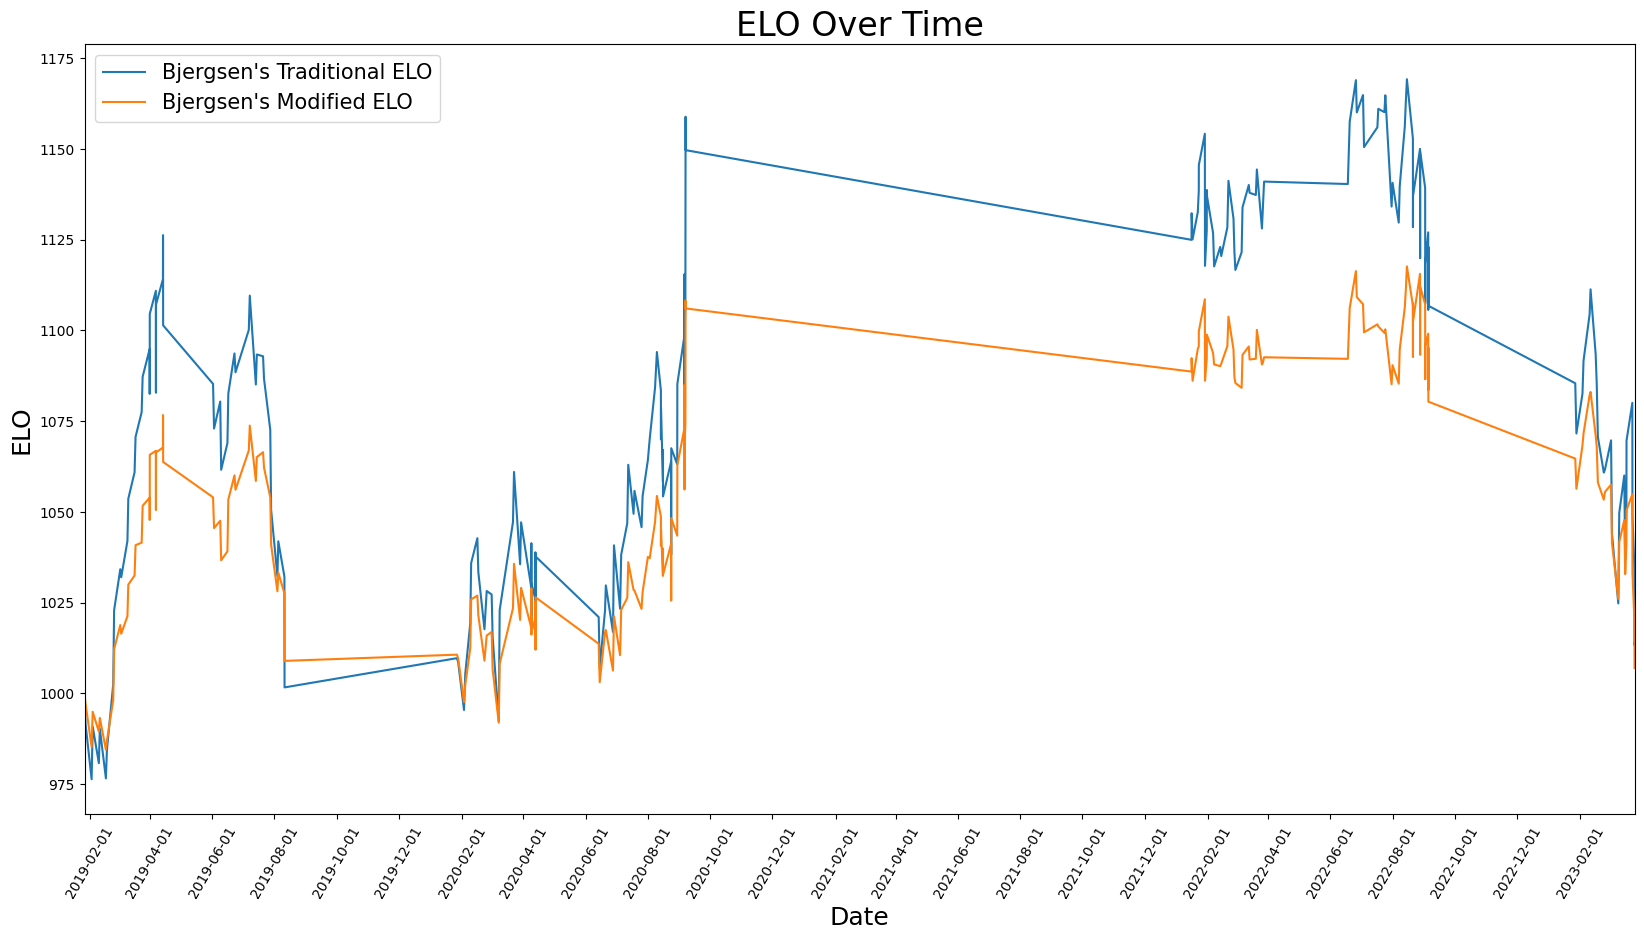

In [73]:
plot_player_ELO("Bjergsen", "LCS")

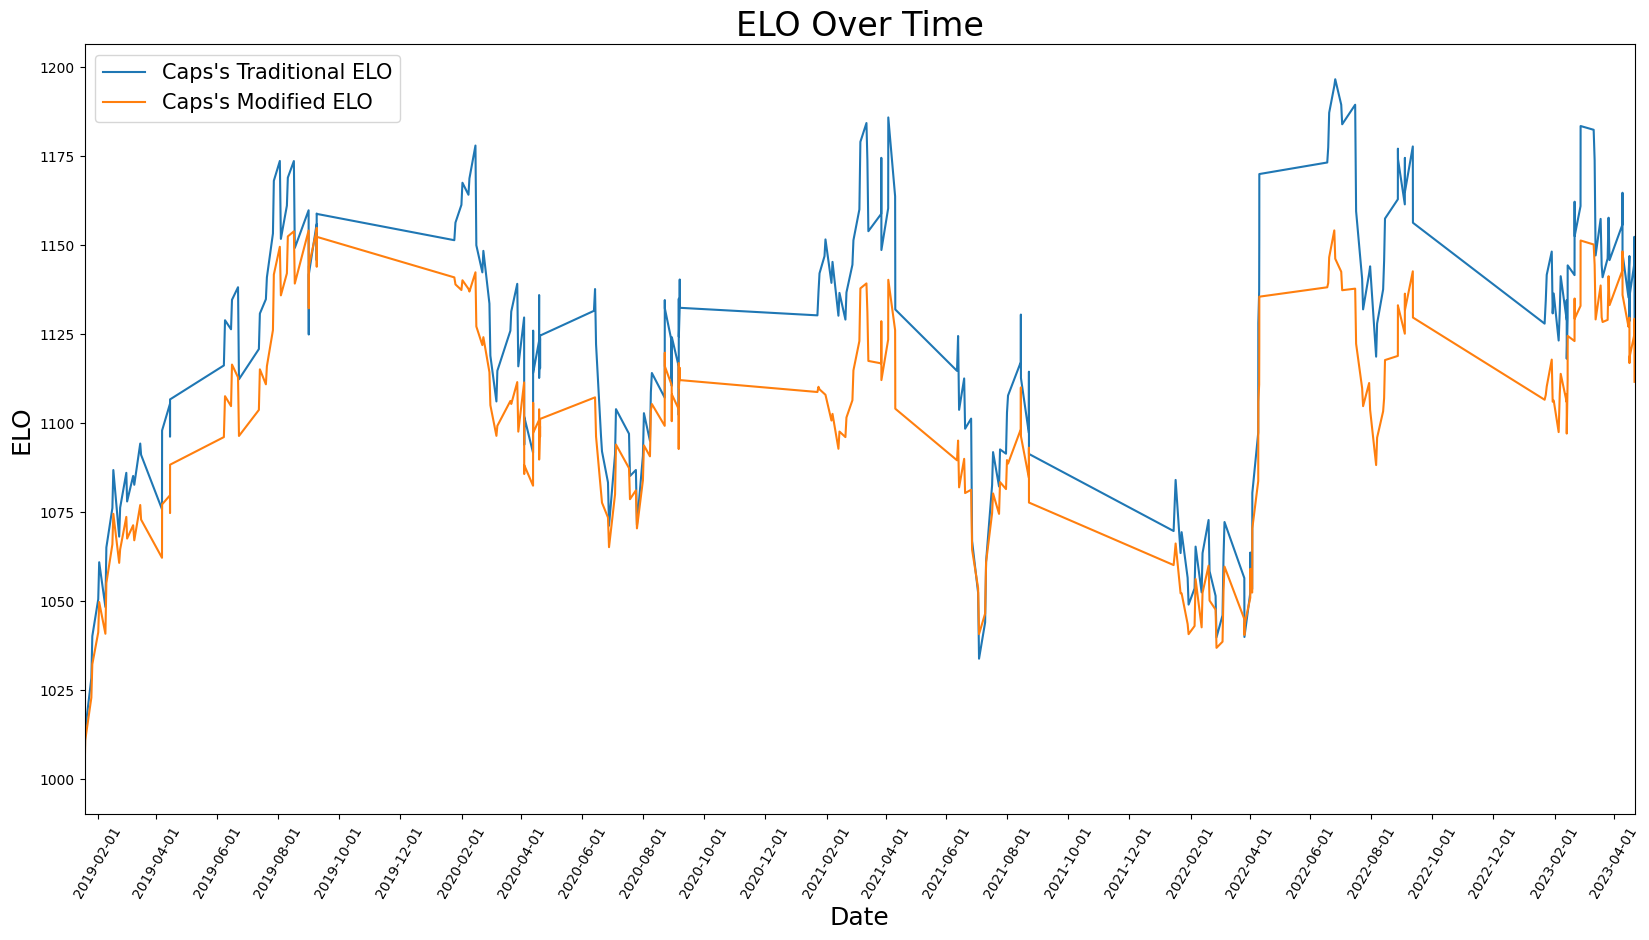

In [74]:
plot_player_ELO("Caps", "LEC")

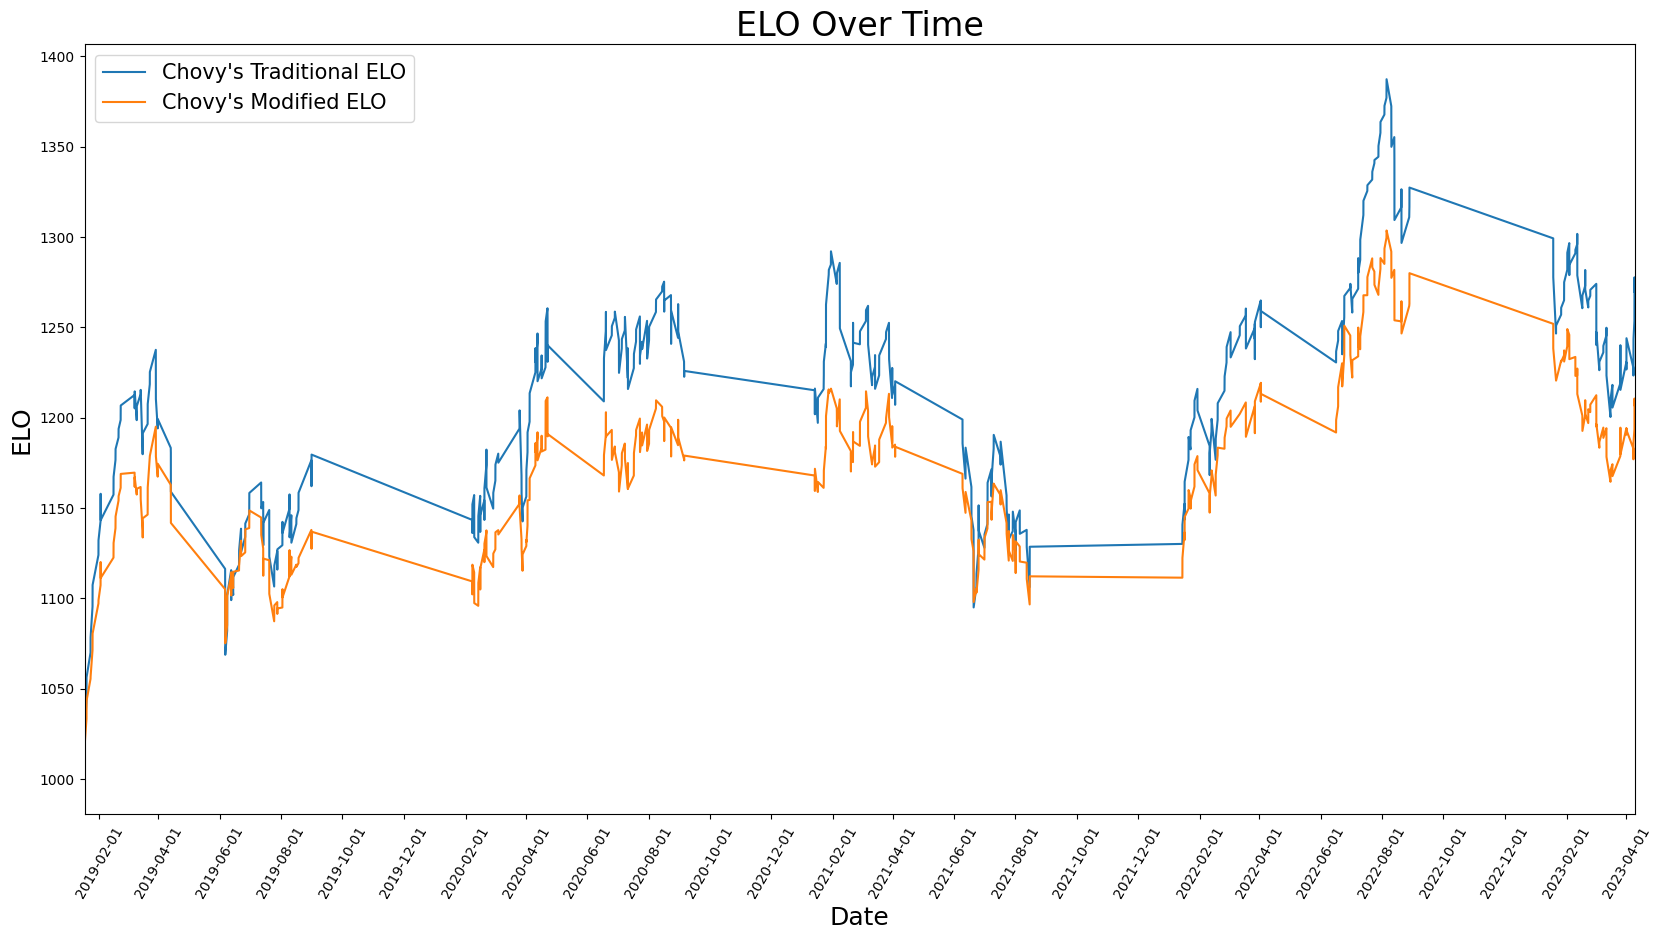

In [75]:
plot_player_ELO("Chovy", "LCK")

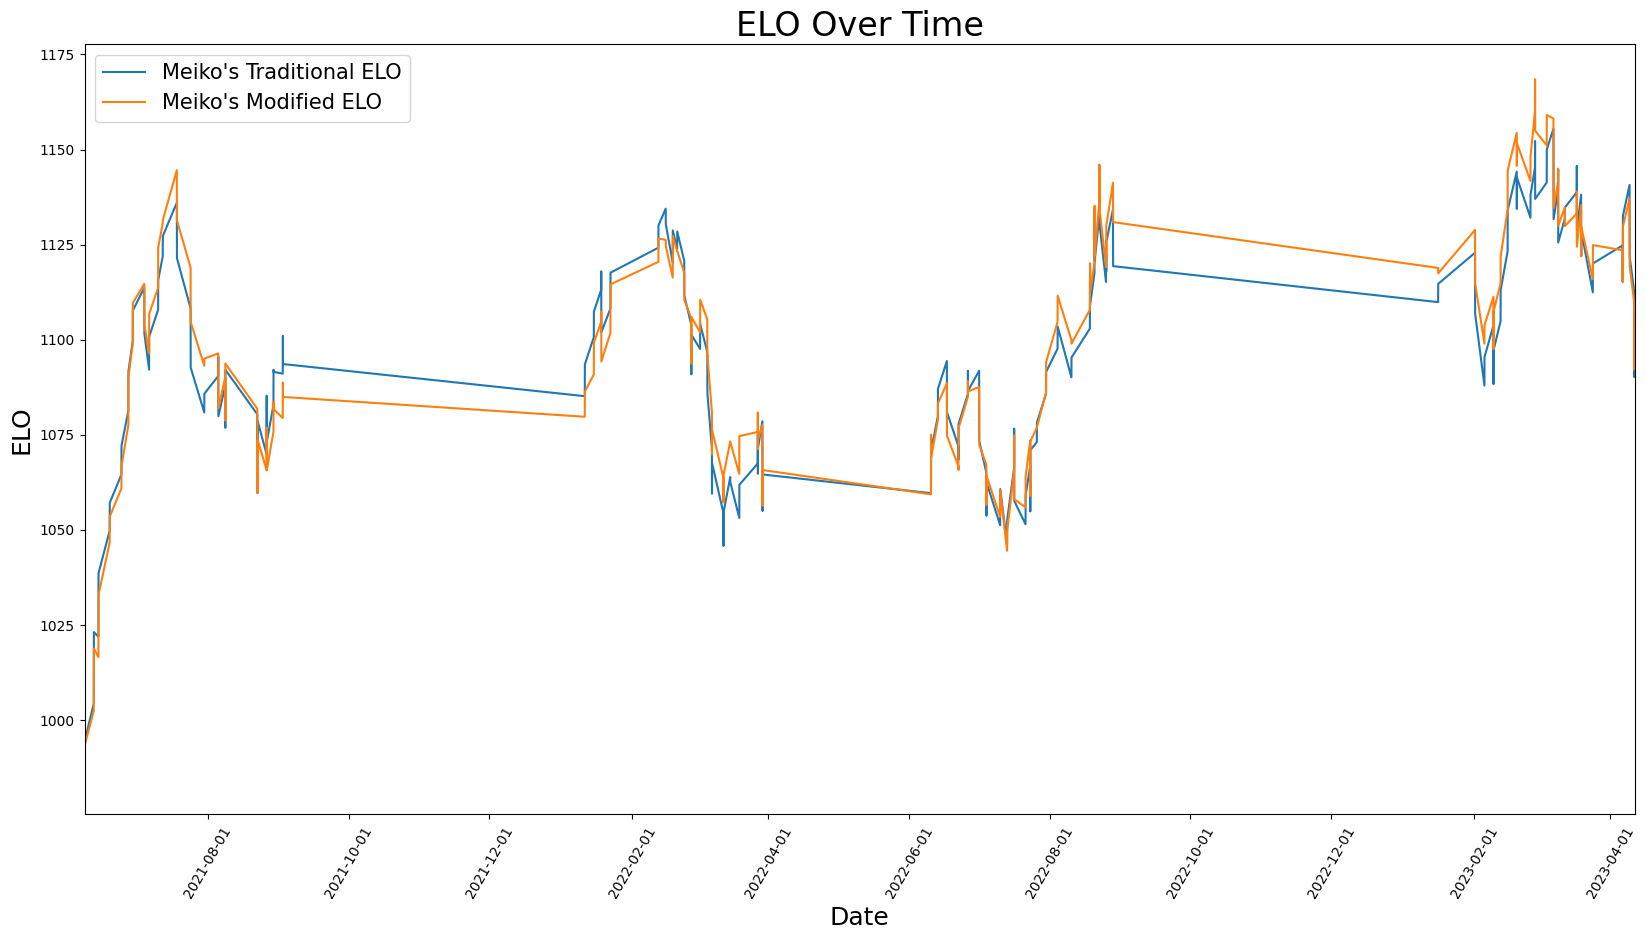

In [76]:
plot_player_ELO("Meiko", "LPL")

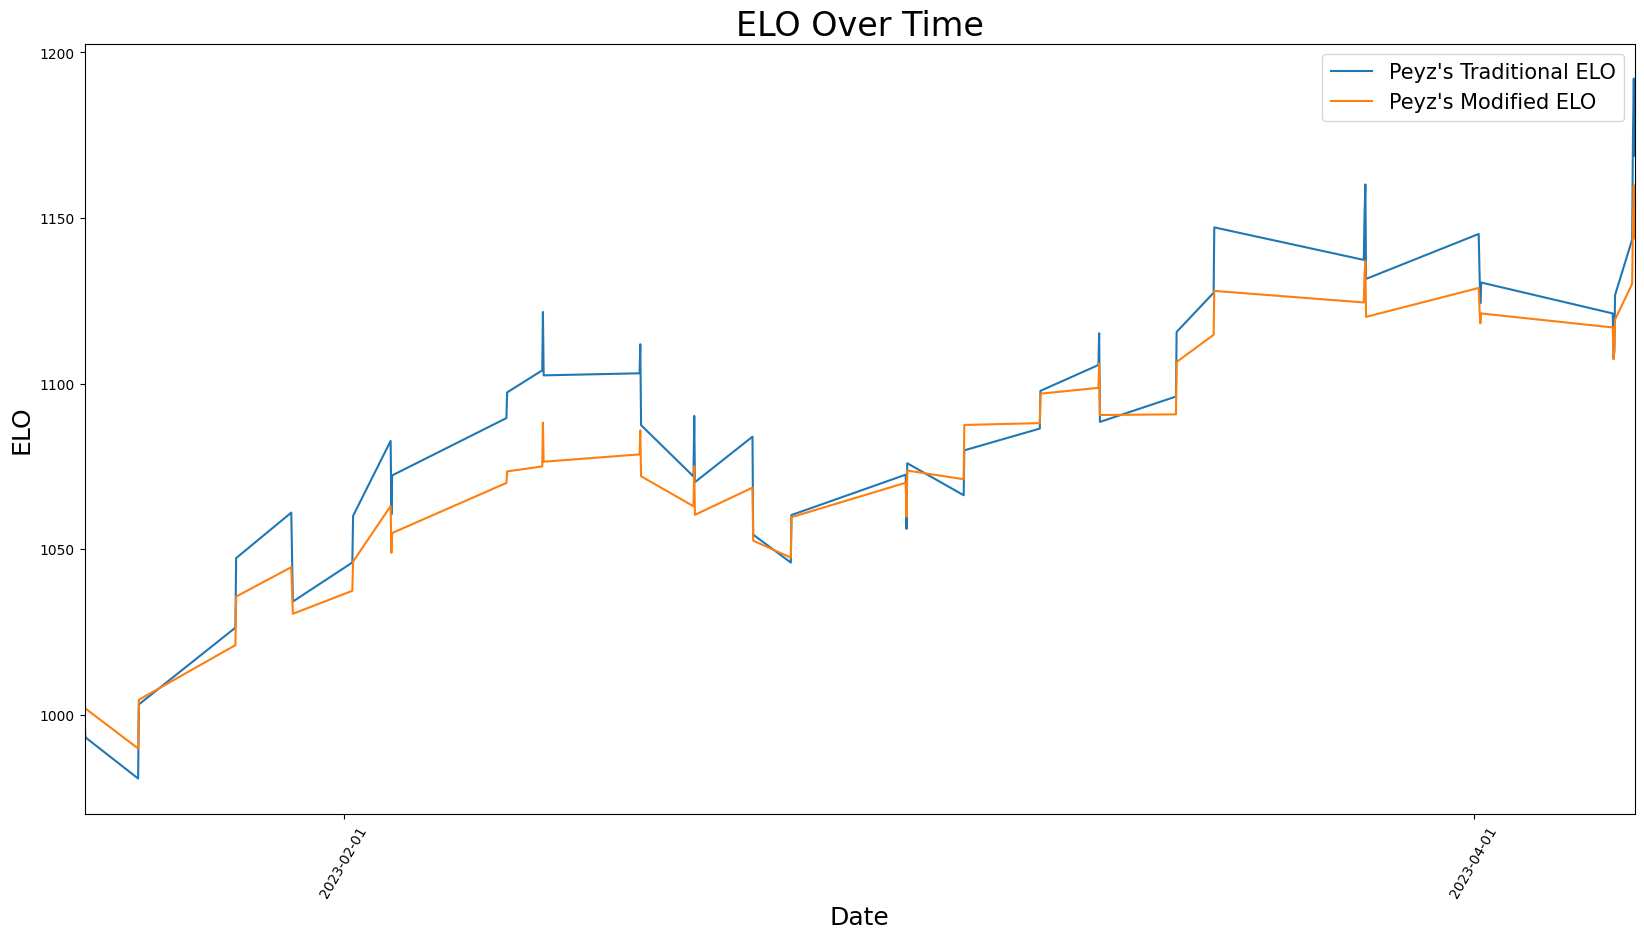

In [77]:
plot_player_ELO("Peyz", "LCK")

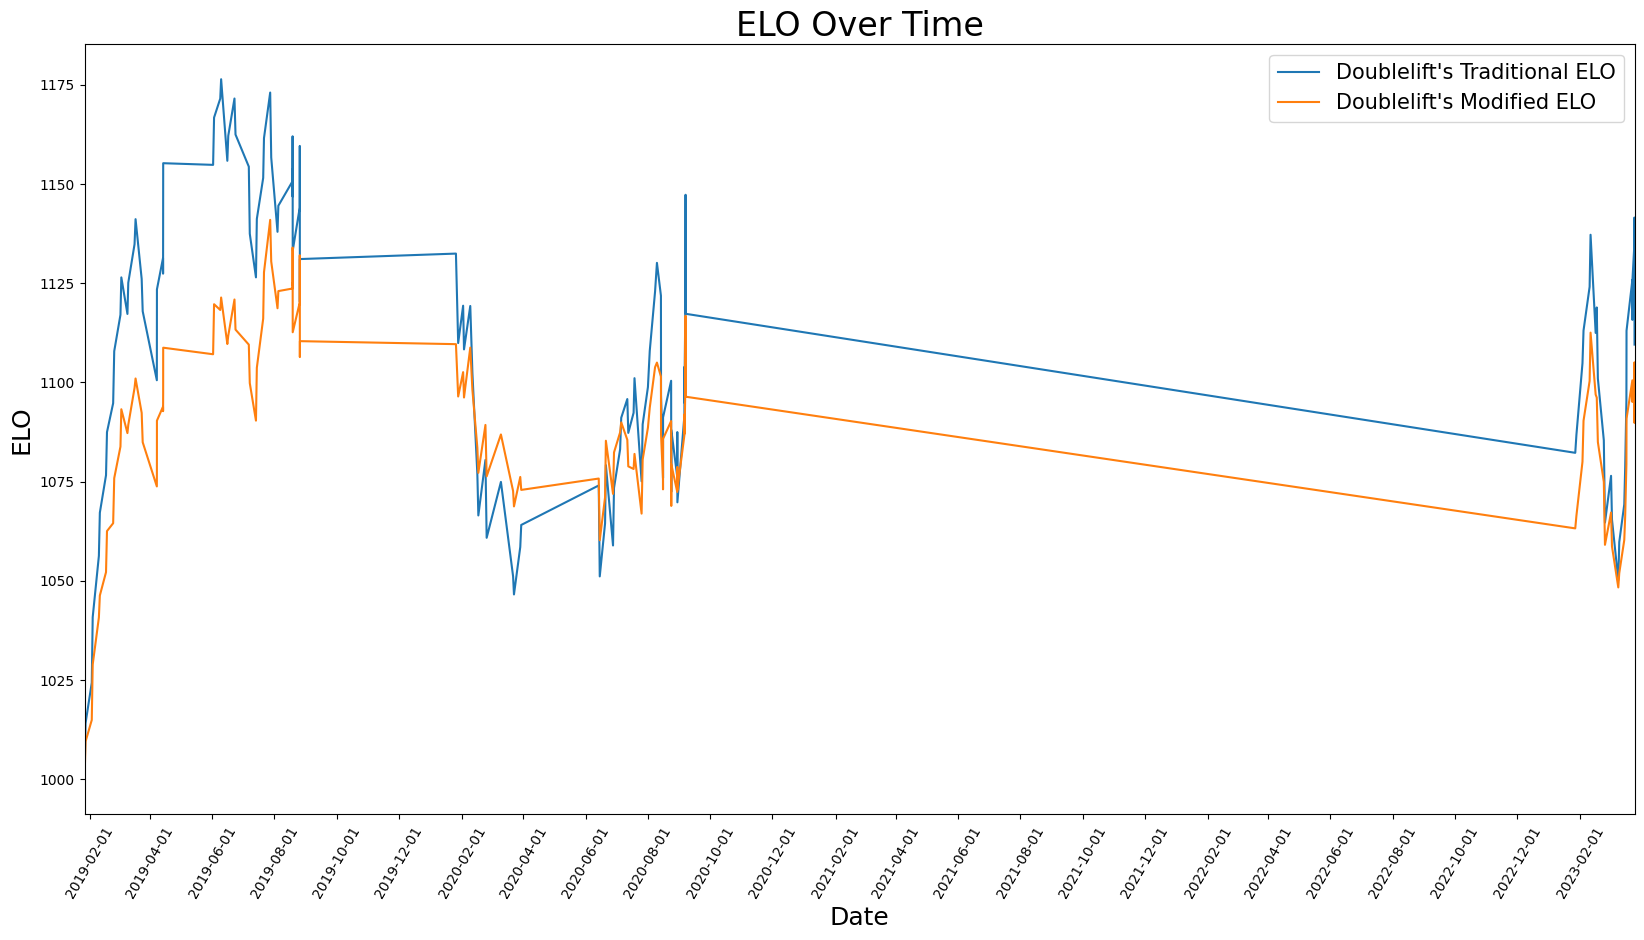

In [78]:
plot_player_ELO("Doublelift", "LCS")

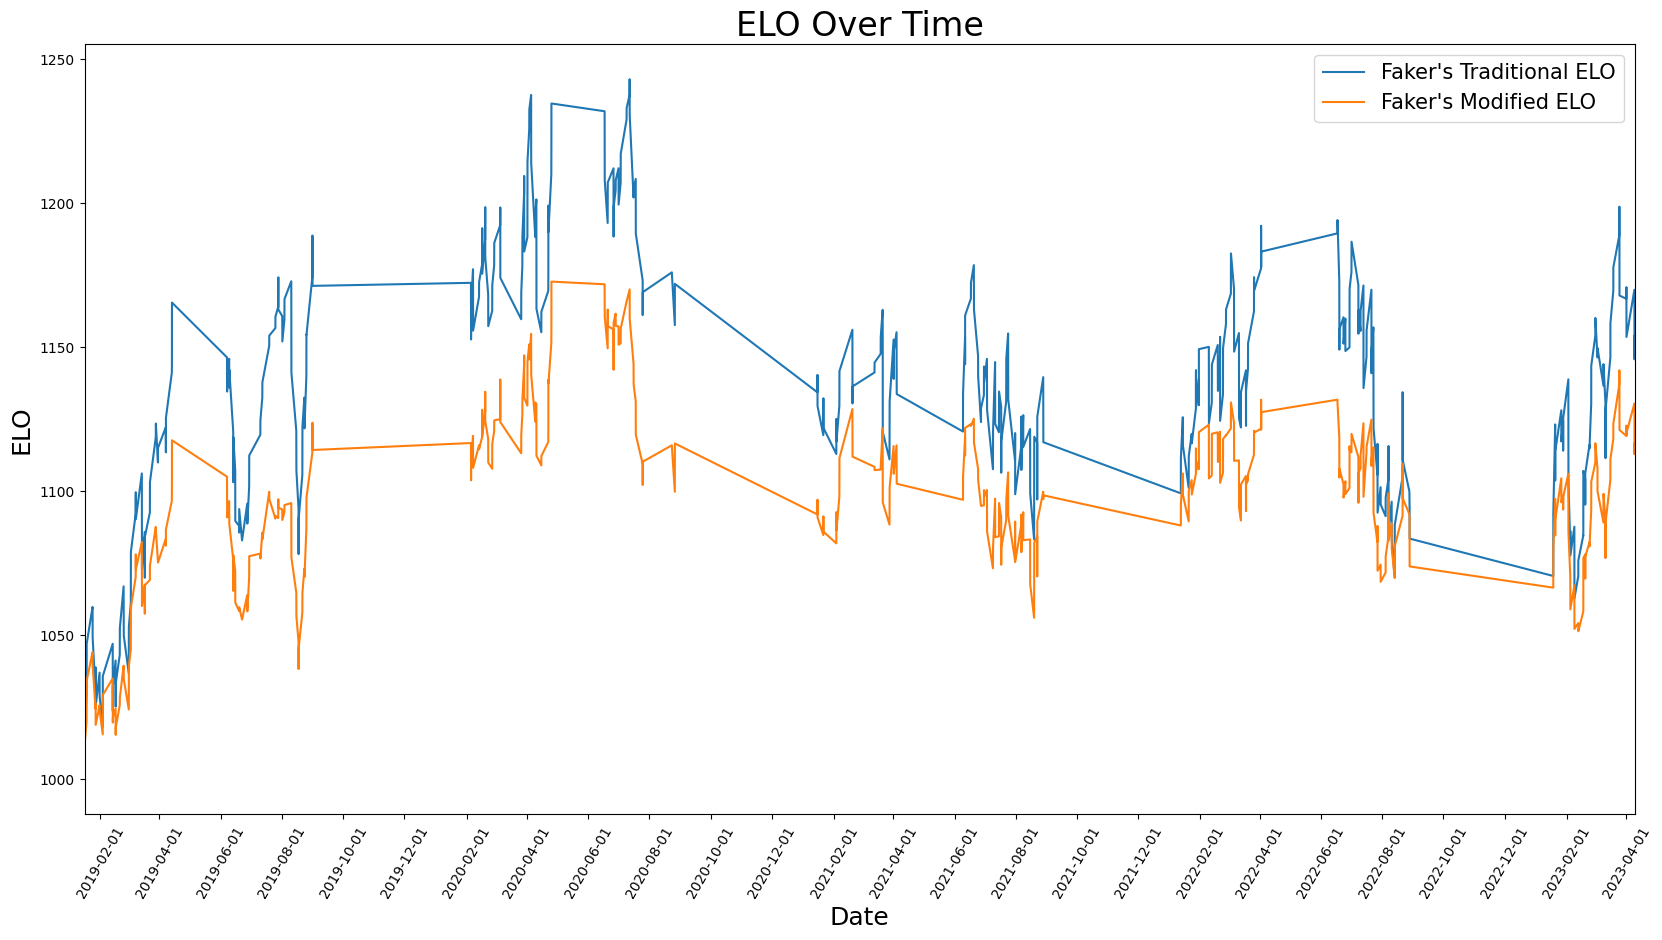

In [79]:
plot_player_ELO("Faker", "LCK")